In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# cd /content/drive/MyDrive/Colab Notebooks/人工智慧於數位訊號分析之應用/project1

/content/drive/MyDrive/Colab Notebooks/人工智慧於數位訊號分析之應用/project1


In [3]:
# !git clone https://github.com/IanChen5273/Music-emotion.git

Cloning into 'Music-emotion'...
remote: Enumerating objects: 490, done.
remote: Total 490 (delta 0), reused 0 (delta 0), pack-reused 490
Receiving objects: 100% (490/490), 520.56 MiB | 17.64 MiB/s, done.
Checking out files: 100% (457/457), done.


In [84]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
      #tf.config.experimental.set_virtual_devices('GPU')
      for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [85]:
import joblib
import librosa
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, add, Flatten, Dropout, Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import xlrd

In [86]:
# DataPath = '/content/Music-emotion/music-emotion/song/'
DataPath = '/content/drive/MyDrive/Colab Notebooks/人工智慧於數位訊號分析之應用/project1/Music-emotion/music-emotion/song/'
os.chdir(DataPath)
xlsx_module = xlrd.open_workbook('MusicData.xlsx')
xlsx_sheet = xlsx_module.sheets()[0]
data_info = []
for i in range(1, xlsx_sheet.nrows):
    data_info.append(xlsx_sheet.row_values(i))

In [97]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/人工智慧於數位訊號分析之應用/project1/Music-emotion/music-emotion/song/archive (2).zip"
!unzip "/content/drive/MyDrive/Colab Notebooks/人工智慧於數位訊號分析之應用/project1/Music-emotion/music-emotion/song/MER_audio_taffc_dataset.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/人工智慧於數位訊號分析之應用/project1/Music-emotion/music-emotion/song/MER_audio_taffc_dataset.zip
   creating: Q1/
  inflating: Q1/MT0000040632.mp3     
  inflating: Q1/MT0000082187.mp3     
  inflating: Q1/MT0000249842.mp3     
  inflating: Q1/MT0000364027.mp3     
  inflating: Q1/MT0000392975.mp3     
  inflating: Q1/MT0000414517.mp3     
  inflating: Q1/MT0000442827.mp3     
  inflating: Q1/MT0000540286.mp3     
  inflating: Q1/MT0000664362.mp3     
  inflating: Q1/MT0000992846.mp3     
  inflating: Q1/MT0001053268.mp3     
  inflating: Q1/MT0001189913.mp3     
  inflating: Q1/MT0001217651.mp3     
  inflating: Q1/MT0001236649.mp3     
  inflating: Q1/MT0001335920.mp3     
  inflating: Q1/MT0001340713.mp3     
  inflating: Q1/MT0001418045.mp3     
  inflating: Q1/MT0001521543.mp3     
  inflating: Q1/MT0001586807.mp3     
  inflating: Q1/MT0001605268.mp3     
  inflating: Q1/MT0001671399.mp3     
  inflating: Q1/MT0001680969.mp3     
  inflating: 

In [99]:
happy_files = os.listdir(DataPath+'happy')
relax_files = os.listdir(DataPath+'relax')
sad_files = os.listdir(DataPath+'sad')
angry_files = os.listdir(DataPath+'angry')
Q1_files = os.listdir(DataPath+'Q1')
Q2_files = os.listdir(DataPath+'Q2')
Q3_files = os.listdir(DataPath+'Q3')
Q4_files = os.listdir(DataPath+'Q4')

In [ ]:
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
class SVM:
    def __init__(self):
        pass

    def Train(self, DataPath, Features, Labels):
        """Train data with SVM model

        Parameters
        ----------
        DataPath : string
            The path where you store the data. Note that the path must contain every split music data and
            MusicData.xlsx
        """
        # Features, Labels = self.LoadFeature(DataPath)

        #MeanValue = np.array(np.mean(Features, axis=0))
        #DiffValue = np.array(np.max(Features, axis=0) - np.min(Features, axis=0))
        #Features = (Features - MeanValue) / DiffValue

        X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.1, random_state=42)

        svm_model = XGBClassifier(n_estimators=100)
        svm_model.fit(X_train, y_train.ravel())
        os.chdir(DataPath)
        joblib.dump(svm_model, 'music_xgboost_data')

        print('train = ', svm_model.score(X_train, y_train))
        print('val = ', svm_model.score(X_test, y_test))

    def Predict(self, ModelPath, InputData):
        """Predict the input with the given model

        Parameters
        ----------
        ModelPath : string
            The path where you store the model.
        InputData : string
            The path of input data, predict one data at one time.
        """
        X_test = self.FeatureExtraction(InputData)
        loaded_model = joblib.load(ModelPath)
        result = loaded_model.predict(X_test)

        return result

    def FeatureExtraction(self, DataPath):
        """Extract the feature for the given file

        Parameters
        ----------
        DataPath : string
            The path where your data is, only allows the file of wav and wma format.
        """
        y, sr = librosa.load(DataPath, sr=22050, mono=True, duration=4)
        time = librosa.get_duration(y=y, sr=sr)
        if int(time) < 4:
            return None

        feature_mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=sr, n_mfcc=1)
        print()
        print("feature_mfcc shape: ",feature_mfcc.shape)
        print("feature_mfcc: ",feature_mfcc)
        
        feature_mfcc = feature_mfcc.reshape((1, feature_mfcc.shape[1] * feature_mfcc.shape[0]))
        feature_rolloff = librosa.feature.spectral_rolloff(y=y, sr=22050, hop_length=sr, roll_percent=0.85)
        print("feature_rolloff shape: ",feature_rolloff.shape)
        print("feature_rolloff: ",feature_rolloff)
        
        feature_spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=22050, hop_length=sr, n_bands=1)
        print("feature_spectral_contrast shape: ",feature_spectral_contrast.shape)
        print("feature_spectral_contrast: ",feature_spectral_contrast)


        feature_spectral_contrast = feature_spectral_contrast.reshape(
            (1, feature_spectral_contrast.shape[1] * feature_spectral_contrast.shape[0]))
        
        feature_rms = librosa.feature.rms(y=y, hop_length=sr)
        print("feature_rms shape: ",feature_rms.shape)
        print("feature_rms: ",feature_rms)
        
        feature_combine = np.hstack((feature_rms, feature_mfcc))
        feature_combine = np.hstack((feature_combine, feature_rolloff))
        feature_combine = np.hstack((feature_combine, feature_spectral_contrast))

        return feature_combine

    def LoadFeature(self, DataPath):
        """Load features and labels from the directory.

        Parameters
        ----------
        DataPath : string
            The path where you store the data. Note that the path must contain every split music data and
            MusicData.xlsx
        """
        os.chdir(DataPath)
        xlsx_module = xlrd.open_workbook('MusicData.xlsx')
        xlsx_sheet = xlsx_module.sheets()[0]
        data_info = []
        for i in range(1, xlsx_sheet.nrows):
            data_info.append(xlsx_sheet.row_values(i))

        features = np.array([])
        music_label = []
        for i in range(len(data_info)):
            print("\rExtracting feature ({}/{})".format(i, len(data_info)), flush=True, end='')
            print(" : {}/{}".format(data_info[i][1], data_info[i][2] + data_info[i][5]), flush=True, end='')

            os.chdir(data_info[i][1])

            feature = self.FeatureExtraction(data_info[i][2] + data_info[i][5])
            os.chdir('..')

            if feature is None:
                continue

            if features.shape[0] == 0:
                features = feature
            else:
                features = np.vstack((features, feature))

            arousal_s = data_info[i][3] - 50
            valence_s = data_info[i][4] - 50
            if arousal_s >= 0 and valence_s >= 0:  # Joy
                music_label.append(0)
            elif arousal_s >= 0 and valence_s < 0:  # Tension
                music_label.append(1)
            elif arousal_s < 0 and valence_s >= 0:  # Peacefulness
                music_label.append(2)
            elif arousal_s < 0 and valence_s < 0:  # Sadness
                music_label.append(3)

        os.chdir(DataPath)
        for i, happy_file in enumerate(happy_files):
            print(f'{i}/{len(happy_files)}')
            feature = self.FeatureExtraction(DataPath+'happy/'+happy_file)
            if feature is None:
                continue
            if features.shape[0] == 0:
                features = feature
            else:
                features = np.vstack((features, feature))
            music_label.append(0)
        for i, angry_file in enumerate(angry_files):
            print(f'{i}/{len(angry_files)}')
            feature = self.FeatureExtraction(DataPath+'angry/'+angry_file)
            if feature is None:
                continue
            if features.shape[0] == 0:
                features = feature
            else:
                features = np.vstack((features, feature))
            music_label.append(1)

        for i, relax_file in enumerate(relax_files):
            print(f'{i}/{len(relax_files)}')
            feature = self.FeatureExtraction(DataPath+'relax/'+relax_file)
            if feature is None:
                continue
            if features.shape[0] == 0:
                features = feature
            else:
                features = np.vstack((features, feature))
            music_label.append(2)
        for i, sad_file in enumerate(sad_files):
            print(f'{i}/{len(sad_files)}')
            feature = self.FeatureExtraction(DataPath+'sad/'+sad_file)
            if feature is None:
                continue
            if features.shape[0] == 0:
                features = feature
            else:
                features = np.vstack((features, feature))
            music_label.append(3)
        os.chdir('..')
        print('\rExtract complete', flush=True)

        return features, np.array(music_label)

In [ ]:
model = SVM()
model.Train('/content/drive/MyDrive/Colab Notebooks/人工智慧於數位訊號分析之應用/project1/Music-emotion/music-emotion/song/', Features, Labels)

train =  0.9231805929919138
val =  0.5662650602409639


In [ ]:
# model = SVM()
# Features, Labels = model.LoadFeature(DataPath)

Extracting feature (0/450) : Grand_Polonaise_op_16/split_001.wav
feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-213.95807 -268.70004 -266.58218 -231.09042 -179.1355 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1862.62207031 1754.95605469 1679.58984375 1485.79101562 1690.35644531]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.5474606  14.43545945  9.44195488 10.15850265 15.93012711]
 [29.70753753 68.01778927 68.27413374 59.17876867 42.75361303]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07246291 0.06357716 0.09761825 0.11155665 0.14522327]]
Extracting feature (1/450) : Grand_Polonaise_op_16/split_002.wav
feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-268.673   -267.29932 -256.04883 -212.80508 -222.39049]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 979.76074219 1711.88964844 1464.2578125  1916.45507812 1378.125     ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[26.62940063 41.98174072 13.62946173 11.52142636 13.55

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-796.07104 -573.19257 -428.85214 -428.09717 -456.8879 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1927.22167969 1787.25585938 2390.18554688 2077.95410156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.73742028 15.67154432 12.19882268 13.44000277 17.34330251]
 [22.73742028 67.3990105  69.86360015 69.74497587 37.150296  ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.00363326 0.01341362 0.02171063 0.00653397]]
Extracting feature (68/450) : L_ Horloge de Flore mv_II/split_002.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-903.9326  -502.11676 -416.2222  -410.92273 -367.39108]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         2390.18554688 2713.18359375 2530.15136719 2013.35449219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.97413897 20.06876445 20.65808112 19.64525003 10.50320427]
 [16.97413897 71.42406536 64.92033084 68.07651892 31.99257418]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.01278729 0.01498804 0.01879264 0.00811073]]
Extracting feature (69/450) : L_ Horloge de Flore mv_II/split_003.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-882.08264 -491.47614 -470.6702  -434.53256 -420.04092]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1162.79296875 1259.69238281 1733.42285156 1679.58984375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.58653038 19.28853212 15.08933567 15.64243959 18.57010552]
 [19.58653038 62.88269289 68.60399499 68.50990328 44.29575511]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.00662029 0.00895814 0.0105687  0.00584292]]
Extracting feature (70/450) : L_ Horloge de Flore mv_II/split_004.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-745.04987 -400.89847 -391.661   -437.03812 -305.53226]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1776.48925781 1507.32421875 1776.48925781 1948.75488281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.15925776 12.97691971 16.5060676  11.56329594  9.54112813]
 [20.15925776 71.40523538 69.42493551 69.70955349 36.89648797]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.01569504 0.03743534 0.01091643 0.02336102]]
Extracting feature (71/450) : L_ Horloge de Flore mv_II/split_005.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-744.2794  -380.5825  -391.42596 -401.94418 -250.8704 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1765.72265625 1927.22167969 1765.72265625 2077.95410156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.53090303 12.9731129   9.57320384 12.02031864  3.63503132]
 [13.53090303 69.88315049 69.42677071 70.93105079 43.22062994]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.01830786 0.0206492  0.01299467 0.04791243]]
Extracting feature (72/450) : L_ Horloge de Flore mv_II/split_006.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-742.87177 -305.8547  -326.80914 -290.55637 -282.554  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         3660.64453125 3348.41308594 3100.78125    3057.71484375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.93936056 16.3035074  11.86411049 11.10117774 23.22701443]
 [15.93936056 62.55212658 62.00808037 62.85817029 50.32168994]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.0170585  0.04007493 0.02206756 0.02708542]]
Extracting feature (73/450) : L_ Horloge de Flore mv_II/split_007.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-782.8223  -336.25986 -319.27316 -345.75464 -443.18243]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1787.25585938 2390.18554688 1981.0546875  1884.15527344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.42162224 18.37758891 12.84709621 10.02857661 18.10425034]
 [19.42162224 67.99949388 68.53836894 71.09956289 42.21038686]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.02300939 0.03068626 0.017468   0.0065273 ]]
Extracting feature (74/450) : L_ Horloge de Flore mv_II/split_008.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-821.7758  -392.01422 -354.77145 -322.79147 -316.12662]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         2465.55175781 2777.78320312 1927.22167969 1894.921875  ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.42280674 27.7400792  16.06405293 12.70134195 18.6672071 ]
 [22.42280674 68.95166321 70.38429153 68.2068521  47.19151198]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.01823738 0.02413564 0.02446564 0.02690988]]
Extracting feature (75/450) : L_ Horloge de Flore mv_II/split_009.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-748.19977 -337.10233 -369.65555 -365.45267 -300.83478]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1959.52148438 1959.52148438 2002.58789062 2390.18554688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.98844681 15.66233624 10.36160893 16.34705097  6.12157384]
 [18.98844681 69.47467804 72.37845116 66.87094552 36.74826547]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.04777668 0.0208533  0.02329777 0.02474217]]
Extracting feature (76/450) : L_ Horloge de Flore mv_II/split_010.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-768.07965 -431.40674 -430.5256  -375.28595 -387.68295]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         2131.78710938 2357.88574219 2293.28613281 2616.28417969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.61043646 21.88202869 15.94289005 10.81028178  8.91018566]
 [17.61043646 67.0815029  69.5498177  71.69922598 45.43028049]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.01045797 0.03488662 0.0244174  0.02225185]]
Extracting feature (78/450) : L_ Horloge de Flore mv_II/split_012.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (79/450) : L_ Horloge de Flore mv_II/split_013.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-755.2549  -344.9934  -381.88043 -332.54556 -325.77652]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         2110.25390625 2088.72070312 2088.72070312 1701.12304688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.8203921  27.30573647  9.8790006  16.83521252 13.8203921 ]
 [13.8203921  68.37328642 67.85824005 69.56985886 45.09990149]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.02809753 0.01484598 0.04361393 0.01939457]]
Extracting feature (80/450) : L_ Horloge de Flore mv_II/split_014.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-754.23676 -333.99457 -343.1265  -381.76938 -336.42404]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1787.25585938 2228.68652344 1614.99023438 2400.95214844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.66588037 18.83956398 15.49122157 19.5119935  24.89398168]
 [22.66588037 68.29907584 68.73873065 67.45156262 30.6021749 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.04281099 0.0224357  0.01634215 0.01248268]]
Extracting feature (82/450) : L_ Horloge de Flore mv_II/split_016.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (84/450) : L_ Horloge de Flore mv_II/split_018.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-821.5229  -390.66763 -433.62607 -364.46927 -336.31317]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         2304.05273438 1981.0546875  1754.95605469 2282.51953125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.05576857 15.29378139 14.24068863 19.13417041 18.26364932]
 [22.05576857 65.52083928 66.94880519 69.46782218 36.06270624]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.0121377  0.01448717 0.02832724 0.01719046]]
Extracting feature (85/450) : L_ Horloge de Flore mv_II/split_019.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-822.68964 -399.95752 -411.20303 -414.24164 -395.02625]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1690.35644531 1819.55566406 1798.02246094 1787.25585938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.08022924 10.38958838 11.68235512 12.82916731 19.43707681]
 [19.08022924 68.27535209 66.18786307 66.28517396 44.43052582]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.01170053 0.0202554  0.01089318 0.00993525]]
Extracting feature (86/450) : L_ Horloge de Flore mv_II/split_020.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-715.7868  -296.2583  -287.47574 -300.65628 -292.2273 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         2228.68652344 2971.58203125 2680.88378906 2325.5859375 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.41707    12.70249003 16.48416357 11.92979798 27.46042756]
 [19.41707    66.10692591 66.58335325 73.61128974 39.02718613]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.02344779 0.03889538 0.06481528 0.02213784]]
Extracting feature (87/450) : L_ Horloge de Flore mv_II/split_021.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-780.30975 -412.62616 -406.88107 -394.13248 -322.63974]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1765.72265625 1485.79101562 2099.48730469 2067.1875    ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.38166186 14.13919914 16.66369498  8.25881875  7.35577765]
 [15.38166186 68.4368941  72.28193296 68.52846242 43.69855013]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.01160912 0.03202023 0.01600842 0.02692412]]
Extracting feature (88/450) : L_ Horloge de Flore mv_II/split_022.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-718.7255  -396.7728  -402.82306 -378.70004 -422.107  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1991.82128906 2347.11914062 2982.34863281 2745.48339844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.14878364 12.65696044 12.95507527 12.20787616 12.72784216]
 [23.14878364 71.12534426 73.81535984 67.41397079 37.76146764]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.03977257 0.05936618 0.02755652 0.01845258]]
Extracting feature (89/450) : L_ Horloge de Flore mv_II/split_023.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-869.89343 -488.41028 -428.14728 -495.688   -362.54794]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         2121.02050781 2174.85351562 2368.65234375 2110.25390625]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.55997564 19.53651963 17.46379164 13.84026102 13.9904447 ]
 [20.55997564 65.87373062 72.82628521 66.42522361 36.4138226 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.00953246 0.01430208 0.00493211 0.01437105]]
Extracting feature (90/450) : Etude Op_72 No_2/split_001.wav
feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-721.5531  -268.69284 -309.20703 -359.23975 -314.5733 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1485.79101562 1367.35839844 1055.12695312 1184.32617188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.45231184 10.59719524 16.96653135 19.01814562 24.3345576 ]
 [17.45231184 74.87786002 74.56602742 71.25731674 50.3919759

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-499.932   -429.96536 -321.6496  -354.86627 -304.9369 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1184.32617188 1442.72460938 1604.22363281 1076.66015625 1302.75878906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[25.16860232 28.57877215 19.06786704 23.68456373 10.13626637]
 [38.70882746 61.79467258 66.25095259 62.39754658 38.7015854 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.00629316 0.01726148 0.02529548 0.02860407 0.04657914]]
Extracting feature (174/450) : Gabriel_s Oboe from The mission/split_002.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-282.82016 -212.00195 -172.34906 -190.37508 -161.19379]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2217.91992188 2207.15332031 2433.25195312 1991.82128906 2174.85351562]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.0132935  33.87828799 32.76382301 34.62927503 15.34306405]
 [40.0773613  66.71903194 63.99769897 65.91539298 41.62563675]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02722823 0.0713051  0.11641169 0.09666598 0.09446701]]
Extracting feature (175/450) : Gabriel_s Oboe from The mission/split_003.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-186.39346 -151.3632  -173.49089 -160.06746 -181.55566]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2217.91992188 2002.58789062 2239.453125   2476.31835938 2670.1171875 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.00412717 34.37137648 30.15509296 45.94618124 23.89872781]
 [41.69212969 64.87853424 68.17972372 64.02269334 43.23918985]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08703925 0.15874138 0.14371938 0.12171058 0.07761499]]
Extracting feature (176/450) : Gabriel_s Oboe from The mission/split_004.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-181.24532 -148.34575 -185.10095 -165.60396 -161.57642]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1959.52148438 2433.25195312 2347.11914062 2336.35253906 1959.52148438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[25.54541841 28.67507201 25.23026037 40.63000003 21.8444323 ]
 [40.89745884 62.5590374  66.95171277 66.85315155 38.207073  ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08135521 0.09569744 0.07595544 0.14468788 0.09574071]]
Extracting feature (177/450) : Gabriel_s Oboe from The mission/split_005.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-136.60942 -159.04955 -169.6971  -184.2629  -173.09503]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2982.34863281 2756.25       2648.58398438 2077.95410156 1582.69042969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.36525375 32.3295683  35.01093597 24.33027064  9.35633501]
 [37.99467465 63.92176204 62.91218527 64.14233897 41.38671167]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0936062  0.1392369  0.20303677 0.12889959 0.14266191]]
Extracting feature (178/450) : Gabriel_s Oboe from The mission/split_006.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-222.69101 -167.57747 -144.06804 -151.97401 -144.71263]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4134.375      2648.58398438 2874.68261719 2648.58398438 2745.48339844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.51085134 25.43977501 25.91088202 28.51537189 22.03821427]
 [35.86777387 65.22243248 63.51850236 64.74131575 43.02122784]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04551784 0.08446354 0.11784425 0.09594009 0.09559745]]
Extracting feature (179/450) : Gabriel_s Oboe from The mission/split_007.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-141.94499 -108.1079  -137.76001 -133.85326 -117.3582 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2207.15332031 2874.68261719 2616.28417969 2971.58203125 2013.35449219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.71972295 32.49600236 28.93853702 37.58761463 25.69862888]
 [41.00906259 65.84697698 68.04897556 64.45640898 39.24482899]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1044603  0.17087553 0.19017546 0.1615731  0.13377708]]
Extracting feature (180/450) : Gabriel_s Oboe from The mission/split_008.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-182.98058 -139.60304 -135.30124 -121.41061  -88.21088]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2454.78515625 2325.5859375  2960.81542969 2971.58203125 2239.453125  ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 6.74910227 25.90392762 34.39833061 39.561453   25.57963035]
 [40.0193781  66.09149413 66.61247252 66.54029091 44.56552524]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07366347 0.15892278 0.11517621 0.1533651  0.18424623]]
Extracting feature (181/450) : Gabriel_s Oboe from The mission/split_009.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -96.57553 -128.36722 -124.70424 -137.6787  -108.73525]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2906.98242188 3789.84375    3003.88183594 3003.88183594 2282.51953125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.7542369  29.7902983  32.43348218 30.44263337 18.12809655]
 [38.35498681 59.72900251 63.50331187 65.93663736 40.48617421]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.12154028 0.16378117 0.19467245 0.17459309 0.19697854]]
Extracting feature (182/450) : Gabriel_s Oboe from The mission/split_010.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-143.21288 -153.0193  -149.27264 -183.40828 -161.50952]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1614.99023438 2357.88574219 2411.71875    2228.68652344 2228.68652344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.43231395 25.48782907 37.85276388 26.4083703   9.57031923]
 [38.45404294 67.52881684 66.80837778 63.29960058 43.79698626]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15825437 0.12445717 0.14374883 0.0852087  0.10617215]]
Extracting feature (183/450) : Gabriel_s Oboe from The mission/split_011.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-223.73766 -175.21025 -149.16971 -182.6633  -125.88092]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1184.32617188 2357.88574219 2357.88574219 2573.21777344 2024.12109375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 6.89027513 26.76675899 37.69454796 28.65388396 22.82729723]
 [41.95081491 68.04570912 64.19853257 65.99966846 43.16243311]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08703598 0.1508472  0.19662619 0.15724851 0.1827122 ]]
Extracting feature (184/450) : Op_28 Preludes No_8/split_001.wav
feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-669.87085 -342.39288 -247.63521 -295.9171  -172.94955]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1227.39257812 1485.79101562 1410.42480469 1668.82324219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.0084414  21.80976699 14.23733464 17.99755489 10.51589377]
 [17.0084414  74.02326116 74.94657065 73.83441922 36.662

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-579.7853  -161.50142 -371.73926 -175.03148 -159.70169]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6696.82617188 3703.7109375  2422.48535156 2691.65039062 2950.04882812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[29.16998801 21.27367415 26.47123778 19.90031262 16.45802306]
 [29.29119809 62.44074846 62.40288946 65.34229404 43.63042517]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.00046835 0.14584404 0.02013473 0.1325253  0.07223391]]
Extracting feature (354/450) : Adagio from the Easter Oratorio/split_002.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-267.0556  -362.70508 -302.8728  -325.82538 -226.55379]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2540.91796875 2454.78515625 2476.31835938 2971.58203125 2185.62011719]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.82594769 26.84179736 20.9500012  17.34164062 21.68928263]
 [38.29363626 68.21493502 64.87570644 66.26811785 36.46500449]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02466559 0.0139991  0.02323137 0.02127374 0.04067323]]
Extracting feature (355/450) : Adagio from the Easter Oratorio/split_003.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-266.88644 -306.10672 -309.2259  -377.24396 -276.3754 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2454.78515625 2756.25       2993.11523438 1582.69042969 1647.29003906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.45908423 26.40215199 15.7471279  20.40552242 18.58866897]
 [40.78292498 62.90196456 64.61577471 69.70481946 41.85069209]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03245392 0.02377875 0.03293596 0.05946903 0.03316035]]
Extracting feature (356/450) : Adagio from the Easter Oratorio/split_004.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-271.5292  -306.69843 -309.49265 -361.60187 -201.0077 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2142.55371094 2950.04882812 2217.91992188 2217.91992188 2228.68652344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.17023905 13.50520087 15.94485965 20.05551724 15.66795576]
 [35.97694183 67.48718191 67.79171035 71.2543683  42.6703687 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02663739 0.02303252 0.06366768 0.10535257 0.05946099]]
Extracting feature (357/450) : Adagio from the Easter Oratorio/split_005.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-213.35106 -296.18378 -311.4668  -348.5733  -287.60385]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2217.91992188 1991.82128906 1991.82128906 1335.05859375 1475.02441406]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 8.61923204 26.46752454 15.91397976 26.67479428 11.59898818]
 [37.8631226  69.97392166 68.05377687 69.31741992 45.32174756]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04773854 0.08302134 0.14002457 0.04214567 0.02865902]]
Extracting feature (358/450) : Adagio from the Easter Oratorio/split_006.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-257.3806  -310.86783 -329.7149  -348.0318  -234.798  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2239.453125   1733.42285156 2487.08496094 1690.35644531 2002.58789062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.94222441 21.21886648 13.45725336 28.26694905 17.05592092]
 [40.69812117 72.05295953 68.21222506 69.58559211 40.48283338]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03599871 0.06032178 0.0506717  0.07558617 0.04737823]]
Extracting feature (359/450) : Adagio from the Easter Oratorio/split_007.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-443.1247  -274.44568 -141.55281 -294.42322 -220.62581]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6104.66308594 1690.35644531 2659.35058594 2002.58789062 2573.21777344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.94013315 24.12498713 28.76905756 17.07107708  8.60390258]
 [33.14497847 68.51769764 62.62638635 70.57833159 37.02779092]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0028526  0.06430733 0.11970682 0.03315401 0.04613995]]
Extracting feature (360/450) : Adagio from the Easter Oratorio/split_008.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-197.76707 -368.4225  -307.57153 -308.95328 -225.82985]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1647.29003906 1658.05664062 1970.28808594 2293.28613281 2024.12109375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.69977654 16.33247825 18.47848019 16.26744251 16.42174205]
 [36.96019222 68.0372516  65.69622806 60.48344979 43.0315478 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07985003 0.02032915 0.02627515 0.03357613 0.07478982]]
Extracting feature (361/450) : Adagio from the Easter Oratorio/split_009.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-366.25653 -279.39484 -373.99237 -232.08606 -264.25467]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2670.1171875  1959.52148438 1754.95605469 2594.75097656 1884.15527344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.44494208 19.34734662 14.66404485 19.82069145 16.27302991]
 [40.44537891 66.59118515 68.22577486 64.49036577 44.61868745]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.011847   0.05465769 0.05110542 0.03598783 0.04651596]]
Extracting feature (362/450) : Adagio from the Easter Oratorio/split_010.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-255.75084 -401.7586  -284.9745  -378.60406 -246.28195]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2960.81542969 2002.58789062 3746.77734375 2217.91992188 1970.28808594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.73842217 19.85064392 20.96437349 19.29687861 18.93743027]
 [38.20042871 67.24193925 58.24835638 62.58719413 46.07060937]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03170958 0.01144753 0.0211315  0.01952542 0.03695348]]
Extracting feature (363/450) : Adagio from the Easter Oratorio/split_011.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-266.55356 -343.5416  -472.68265 -355.94504 -278.8708 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3133.08105469 2314.81933594 2034.88769531 1830.32226562 2756.25      ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.70305898 21.91550617 12.14286711 18.22190547 22.67085711]
 [37.71195611 66.61239488 63.22196518 68.7592922  39.39488289]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02345398 0.03074308 0.00669051 0.02260828 0.02337413]]
Extracting feature (364/450) : Adagio from the Easter Oratorio/split_012.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-289.2731  -329.45087 -427.575   -305.4959  -183.89325]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3111.54785156 1507.32421875 1507.32421875 1776.48925781 1981.0546875 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.85615321 18.91519005 11.30765927 20.6833374  18.63870779]
 [35.83044012 70.63563913 65.59991257 68.92276095 38.31464761]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03630351 0.03385707 0.05780484 0.07115248 0.08246735]]
Extracting feature (365/450) : Adagio from the Easter Oratorio/split_013.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-206.5627  -209.53084 -158.73492 -214.21184 -175.32402]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2853.14941406 2379.41894531 2228.68652344 2260.98632812 2260.98632812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[31.413795   26.50854182 29.25583982 23.8314526  17.82365287]
 [36.38449794 64.70246118 68.56714956 68.51288021 44.46472761]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06187146 0.07659787 0.14524347 0.11132307 0.13573413]]
Extracting feature (366/450) : Adagio from the Easter Oratorio/split_014.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-115.020966 -267.66263  -203.96146  -229.47296  -194.33376 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2476.31835938 1507.32421875 2960.81542969 2960.81542969 2476.31835938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.67881246 23.95198141 23.81181226 28.75615751  9.75196522]
 [33.77090073 66.6731525  63.53222911 65.68254668 43.90143277]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.12381369 0.20094086 0.06702077 0.05161527 0.08355962]]
Extracting feature (367/450) : Adagio from the Easter Oratorio/split_015.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-385.46927 -325.50922 -341.91855 -289.33755 -394.27643]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2121.02050781 3143.84765625 2670.1171875  2217.91992188 1431.95800781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.4357044  17.63682669 18.02314552 18.43324595 10.14882825]
 [41.21838102 58.26624588 66.31613244 68.39763487 49.90448664]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0125379  0.01611136 0.02284763 0.03325332 0.03529167]]
Extracting feature (368/450) : Adagio from the Easter Oratorio/split_016.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-359.37378 -253.63036 -150.66858 -277.06287 -208.83717]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2002.58789062 2734.71679688 3165.38085938 2239.453125   3348.41308594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.47456071 17.90339107 20.39819117 11.58326961  4.85992444]
 [38.52826754 64.05506352 61.82292457 69.31302453 37.26661331]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01923312 0.06605344 0.09211283 0.04286619 0.04602857]]
Extracting feature (369/450) : Adagio from the Easter Oratorio/split_017.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-225.97275 -313.68985 -206.16519 -175.07536 -253.71793]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1851.85546875 1679.58984375 2325.5859375  2239.453125   2379.41894531]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.13922456 29.20442567 25.89076039 23.89014613 12.09241736]
 [41.05761062 64.06071617 62.84987758 65.06291374 40.80768408]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08407109 0.06327371 0.10281757 0.17937021 0.03884378]]
Extracting feature (370/450) : Rebonds B/split_001.wav
feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-734.673   -544.5842  -191.35844 -579.74725 -461.10034]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.          732.12890625 2476.31835938  968.99414062  473.73046875]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.08030611 30.65782762 29.27527509 28.98662557 21.57736772]
 [23.08030611 67.47116576 61.5394011  66.93936664 46.96743193]]
fe

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-756.12787 -259.76984 -339.18076 -351.8121  -299.47363]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5652.46582031 4543.50585938 1991.82128906 2551.68457031 2853.14941406]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.80242531 21.53826369 15.37173097 22.10099334 20.16604893]
 [48.28150078 64.68879114 70.73814089 65.0470389  38.04960285]]
feature_rms shape:  (1, 5)
feature_rms:  [[8.7185676e-05 2.0513291e-02 2.3345679e-02 3.9968129e-02 2.2310004e-02]]
Extracting feature (387/450) : Concerto for oboe and small orchestra mv_I/split_002.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-313.8744  -412.90625 -373.84955 -378.09814 -304.09662]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2207.15332031 2250.21972656 2207.15332031 2519.38476562 2357.88574219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[26.5065818  17.29137837 10.24082523 16.47640389  8.60410025]
 [43.04792195 65.63940857 64.97229108 61.75992234 42.87497456]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02432832 0.01546326 0.01843318 0.01787893 0.02753238]]
Extracting feature (388/450) : Concerto for oboe and small orchestra mv_I/split_003.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (389/450) : Concerto for oboe and small orchestra mv_I/split_004.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-355.39786 -388.1026  -279.16513 -295.24014 -267.09552]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1798.02246094 2799.31640625 2271.75292969 2594.75097656 3843.67675781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.97882115 17.64593117 28.82340867 14.72272678  9.81241895]
 [38.28896007 67.83413517 64.79796859 65.60820277 37.11653143]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01779184 0.02129204 0.03357522 0.03750068 0.04537457]]
Extracting feature (390/450) : Concerto for oboe and small orchestra mv_I/split_005.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-338.27524 -461.3329  -369.3534  -394.33792 -267.4429 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2045.65429688 2497.8515625  3165.38085938 1798.02246094 3197.68066406]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.2545521  13.27457148 18.31884113 14.40834564 20.3930162 ]
 [38.18755092 68.92013982 70.53647039 71.48067414 37.53990913]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02011243 0.02240478 0.03455129 0.04032081 0.03629718]]
Extracting feature (391/450) : Concerto for oboe and small orchestra mv_I/split_006.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-218.43309 -283.01694 -281.29095 -351.7163  -267.9389 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3133.08105469 2637.81738281 2099.48730469 2400.95214844 2562.45117188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.57487232  6.95193082 12.93955881 15.94550026  5.81059884]
 [40.5080058  61.27819856 67.82360375 64.94065679 41.24622965]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0380773  0.02994687 0.04225256 0.01773402 0.03257541]]
Extracting feature (392/450) : Concerto for oboe and small orchestra mv_I/split_007.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (393/450) : Concerto for oboe and small orchestra mv_I/split_008.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-393.06616 -341.8139  -317.48343 -336.88446 -269.33145]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1776.48925781 1754.95605469 3122.31445312 3692.94433594 2637.81738281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.52514719 22.41612503 21.62197841 11.98246276  8.66859654]
 [35.85945918 70.6769567  66.59562365 63.12518039 32.76172585]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01151363 0.0505357  0.03343366 0.02156252 0.01633323]]
Extracting feature (394/450) : Concerto for oboe and small orchestra mv_I/split_009.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-428.60916 -332.24478 -263.23645 -334.86417 -215.0606 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1485.79101562 4188.20800781 1808.7890625  1970.28808594 1851.85546875]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.63027824 14.78943785 14.11298471  9.7762474   4.54526655]
 [39.31343646 67.98318338 65.39487702 66.48320104 43.10454116]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01022784 0.01994321 0.04662512 0.02496983 0.05069569]]
Extracting feature (395/450) : Concerto for oboe and small orchestra mv_I/split_010.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-385.87628 -317.16193 -300.47055 -320.1336  -377.62393]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1754.95605469 3133.08105469 2110.25390625 2508.61816406 2497.8515625 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.52189941 17.57558449 14.6679648  21.76440453 23.58325905]
 [43.72931527 67.99140051 70.0222845  67.29531711 45.0430861 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01627126 0.02804892 0.04654336 0.0290836  0.01341347]]
Extracting feature (396/450) : Concerto for oboe and small orchestra mv_I/split_011.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-497.48517 -454.50284 -361.2304  -467.1685  -470.10593]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1894.921875   1399.65820312 1281.22558594 1722.65625     947.4609375 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.89726686 18.99881591 22.25724262 13.17740064 31.45361024]
 [46.65637491 66.51784125 68.12218828 64.78354301 46.05091426]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.00433088 0.01064052 0.02763962 0.00833585 0.01139688]]
Extracting feature (397/450) : Concerto for oboe and small orchestra mv_I/split_012.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-422.6472  -346.49152 -425.3438  -367.7266  -282.44617]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1399.65820312 2271.75292969  979.76074219 2077.95410156 2099.48730469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.54607751 12.20803089 24.01889141 16.67145577 19.16925278]
 [36.98402506 69.32641619 70.40524484 67.43738691 32.71915411]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01011091 0.02746572 0.02432699 0.02190754 0.03121182]]
Extracting feature (398/450) : Concerto for oboe and small orchestra mv_I/split_013.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-274.32318 -221.57686 -198.4581  -172.49286 -158.73665]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2379.41894531 3111.54785156 1959.52148438 3154.61425781 2680.88378906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.60638108 19.40110507 23.17778743 20.45974782 19.72294594]
 [36.62842832 66.22326998 65.07252466 65.49243412 39.47019251]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02722578 0.04644727 0.07507694 0.05411823 0.07575236]]
Extracting feature (399/450) : Concerto for oboe and small orchestra mv_I/split_014.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-460.49866 -332.95993 -365.4725  -401.67307 -339.65616]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1937.98828125 3186.9140625  2142.55371094 3574.51171875 3531.4453125 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.74131158 21.62814283 13.15167243 25.7517231  20.03591101]
 [45.13014588 67.0544454  70.74512892 70.43616132 41.02468082]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.00608988 0.01938198 0.01812342 0.02199952 0.01083167]]
Extracting feature (400/450) : Concerto for oboe and small orchestra mv_I/split_015.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-315.31796 -354.20102 -292.15125 -346.00348 -309.47104]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3477.61230469 1905.68847656 3617.578125   2853.14941406 2357.88574219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.85519195 14.17863182 13.60950456 13.29595825 20.475961  ]
 [39.04102864 67.24570581 65.80724674 63.5260494  41.32217329]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0169151  0.01850105 0.04864046 0.01381961 0.02546655]]
Extracting feature (401/450) : Concerto for oboe and small orchestra mv_I/split_016.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-333.1382  -236.24718 -328.8961  -274.9418  -258.82343]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2982.34863281 1754.95605469 2691.65039062 2670.1171875  2024.12109375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[34.40566687 20.35383497 25.21367478 19.98304959 20.45293616]
 [36.04576642 68.30062188 67.68699863 67.58414959 42.24141865]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01447502 0.07538031 0.0336025  0.02883417 0.04131706]]
Extracting feature (402/450) : Concerto for oboe and small orchestra mv_I/split_017.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-281.82474 -221.38254 -264.78912 -224.85909 -250.85675]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3380.71289062 2508.61816406 2616.28417969 2928.515625   3046.94824219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.34904299 11.56125548 12.98078157 21.8753922  31.15729255]
 [41.69956493 66.29692534 68.12396263 63.45693456 40.69932603]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03894504 0.05282085 0.04607068 0.04246786 0.06568392]]
Extracting feature (403/450) : Concerto for oboe and small orchestra mv_I/split_018.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -94.94055 -265.41904 -312.62024 -386.568   -346.5818 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4231.27441406 3025.41503906 2271.75292969 4920.33691406 2293.28613281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.85195179 18.91670198 14.87205591  9.96885232 19.60405259]
 [35.78754717 69.61043031 66.83612742 66.1331104  41.13939663]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11078938 0.03620819 0.03520397 0.02736795 0.01183455]]
Extracting feature (404/450) : Concerto for oboe and small orchestra mv_I/split_019.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-482.61227 -359.22885 -315.6386  -409.9061  -332.93417]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1518.09082031 1571.92382812 2207.15332031 1959.52148438 1604.22363281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.02835983 23.83615648  8.63065368 11.51207652  9.12058059]
 [43.42104791 74.13360348 68.61261681 70.50418243 49.14609913]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.00716248 0.04908711 0.03302237 0.02236007 0.02538501]]
Extracting feature (405/450) : Concerto for oboe and small orchestra mv_I/split_020.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-357.36435 -421.73145 -464.34286 -352.12747 -391.66736]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2024.12109375 2153.3203125  2110.25390625 2874.68261719 1496.55761719]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.60895306 13.13585869 21.75608921 24.83672815  8.32815315]
 [36.856018   70.18042919 69.77091391 61.58563422 44.1975619 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01540449 0.02676583 0.02360284 0.00975534 0.01838349]]
Extracting feature (406/450) : Concerto for oboe and small orchestra mv_I/split_021.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-308.78983 -296.35947 -266.35577 -285.72958 -369.09216]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2293.28613281 2250.21972656 3186.9140625  1916.45507812 1410.42480469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.95867697 18.84667627 16.11592315 17.72776864 13.18959869]
 [46.3797046  71.11067736 69.51688092 62.39903333 46.86204247]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02964564 0.04251977 0.04084114 0.03433752 0.01914546]]
Extracting feature (407/450) : Concerto for oboe and small orchestra mv_I/split_022.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-264.70358 -266.63617 -264.8509  -258.37683 -249.59877]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1981.0546875  1808.7890625  3305.34667969 2993.11523438 2400.95214844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.73627796 19.61669255 16.23255156 10.52556119 13.85511653]
 [42.90270214 70.41225125 65.45610343 65.86307757 46.57179454]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04347835 0.04607713 0.03171436 0.04154423 0.0278174 ]]
Extracting feature (408/450) : Concerto for oboe and small orchestra mv_I/split_023.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-275.94028 -285.54575 -323.62912 -223.93317 -284.04034]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1722.65625    2831.61621094 1518.09082031 2971.58203125 2034.88769531]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.075355   12.53254084 16.6866331  18.34193745 19.43283738]
 [49.56941087 65.34378534 70.99629749 64.40148391 33.68672715]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05643811 0.03497141 0.04300122 0.04659395 0.04432159]]
Extracting feature (409/450) : Concerto for oboe and small orchestra mv_I/split_024.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-202.96556 -323.48376 -158.14265 -327.1015  -166.93248]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2540.91796875 3359.1796875  3499.14550781 3122.31445312 3251.51367188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.96204935 12.84926714 25.68841727 10.47734004 16.56804583]
 [37.19695345 67.28645895 57.42401599 65.34775343 38.13739988]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05158738 0.02989043 0.05019587 0.01917353 0.07944066]]
Extracting feature (410/450) : Siciliana/split_001.wav
feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-865.67694 -559.045   -500.62262 -486.78793 -494.3733 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         1335.05859375 1130.49316406  829.02832031  667.52929688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.09332347 11.35238298 21.3986363  25.8026219  20.68848518]
 [22.09332347 68.56310646 67.42660767 72.04421079 48.77391998]]
fe

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -71.49884 -128.83961  -78.86156 -139.36061 -129.31154]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4425.07324219 4877.27050781 5803.19824219 3014.6484375  3165.38085938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.93140773 22.93183511 25.83625105 16.8071007   9.92364302]
 [34.65415256 56.06585692 54.87194364 60.94720139 37.52205217]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10470149 0.10018149 0.1621402  0.08782119 0.1252656 ]]
1/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-29.504126 -73.220345 -42.74808  -93.72386  -73.880974]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7149.0234375  5501.73339844 7041.35742188 3542.21191406 4586.57226562]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.85577703 19.15222556 14.44749537 15.43205864 20.49433658]
 [31.75556888 56.82706716 49.7915966  59.53019067 34.42641074]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11816006 0.25009152 0.13136977 0.12908815 0.11072001]]
2/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-125.71866   -80.68318    38.713924 -145.49248   -56.97579 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2885.44921875 7364.35546875 5684.765625   3714.47753906 2411.71875   ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 5.59049532 22.93527069 19.73383717 12.87799354 13.15350756]
 [36.7706822  49.223862   51.46273253 56.31882931 42.24804219]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.14170092 0.16971251 0.26941308 0.10982636 0.24429464]]
3/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -69.111305 -128.21445   -98.66317   -88.05489  -120.01847 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5135.66894531 6190.79589844 6018.53027344 5404.83398438 4457.37304688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.9934914  21.47310531 21.36035072 20.20645035 19.18906318]
 [34.79416508 51.44964606 52.07103792 55.33070505 36.11843609]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.16225065 0.07348167 0.07829484 0.0904692  0.09045493]]
4/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-48.85995   11.11233  -45.842953  10.055577 -26.666555]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4931.10351562 4823.4375     5243.33496094 6309.22851562 4640.40527344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 4.85245825 12.89709452 24.48881383 21.50224512 11.84496487]
 [33.36098609 58.97796396 55.90603165 52.59006137 33.047654  ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.16814977 0.19980903 0.14508499 0.19576593 0.13500658]]
5/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-105.837944 -218.18912  -157.26508  -171.86798   -55.137215]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5598.6328125  4306.640625   3983.64257812 3251.51367188 4898.80371094]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.58595377 23.57832779 24.84810238 16.99785465 21.59292366]
 [32.00130971 55.56786745 53.18810363 60.62807546 37.64757581]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10319965 0.08218186 0.11339761 0.09256569 0.1547301 ]]
6/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-115.84685 -186.3471  -113.97444 -153.14265 -170.47456]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6664.52636719 4608.10546875 7030.59082031 5932.39746094 5781.66503906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.7372548  31.42331553 19.05343534 16.59728925 16.13833165]
 [41.51372726 56.02972106 49.52652051 53.01668612 31.83374419]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05945565 0.06019228 0.06245526 0.08388336 0.04355243]]
7/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-113.97791  -183.8756    -92.653206 -160.58153   -85.515274]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3186.9140625  2756.25       5157.20214844 3466.84570312 3003.88183594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.34949964 27.09940563 21.51286576 17.94751364 10.76292119]
 [37.18294978 66.02329088 61.39650733 61.43034865 41.36838727]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09334851 0.06729601 0.09865429 0.08036299 0.14346401]]
8/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[33.151695 12.88969  15.590787  4.805604 39.965454]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6718.359375   4823.4375     5028.00292969 4769.60449219 3962.109375  ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.38230058 15.8978988  15.67575822 35.15449646 12.94689817]
 [31.57769232 55.90166983 52.80142937 57.760635   38.09017059]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.24631187 0.26347724 0.23361854 0.26966965 0.35995254]]
9/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-54.825893   4.730725 -63.391525 -88.42034   -8.12997 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4446.60644531 5953.93066406 4263.57421875 5813.96484375 5329.46777344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.04660061 21.77415366 20.88108448 33.3393795  15.69479136]
 [31.83556182 50.65488201 52.3304273  53.00985656 32.74294536]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1511115  0.14688209 0.22273622 0.10442784 0.21620406]]
10/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -96.52046  -170.10786   -44.349133  -36.903915  -85.23575 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5846.26464844 4705.00488281 4984.93652344 6147.72949219 6040.06347656]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.22129607 13.91559141 16.86540193 19.91416088 23.9279742 ]
 [29.64298801 72.17640301 72.35722241 71.67418398 32.86270135]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04979749 0.0293062  0.13273694 0.11452508 0.09189425]]
11/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-131.292   -158.61517 -106.87388 -106.7974   -75.6765 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2454.78515625 4155.90820312 3445.3125     3617.578125   4758.83789062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.63083762 21.51474618 23.46768011 20.55056917 14.19966473]
 [38.50154891 54.86996059 54.55327504 56.78072139 31.32662861]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.16422038 0.06776858 0.16292483 0.15673819 0.14475113]]
12/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-102.113335 -122.78818  -210.01175  -169.1645   -107.02117 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5017.23632812 4909.5703125  3219.21386719 6546.09375    5415.60058594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[32.62680704 13.05997102 14.16875699 21.87239525 26.42022776]
 [29.52087717 64.51100094 62.0868785  57.21700665 34.69267719]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10732066 0.094312   0.11806332 0.09594245 0.12659459]]
13/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-141.08298  -133.58951   -59.941704 -101.50956   -78.36967 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5458.66699219 6169.26269531 6503.02734375 5157.20214844 5577.09960938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.94918962 23.66993326 19.39921639 24.26278359 12.96652016]
 [30.62593252 54.15422119 51.55338792 55.56985333 33.81479442]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13051097 0.05723014 0.07607762 0.15952742 0.10262924]]
14/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-117.23122 -113.6194  -127.60937 -134.73692 -138.6147 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5264.86816406 6675.29296875 6524.56054688 6912.15820312 5900.09765625]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[29.18712111 23.86889084 14.96606617 25.50705764 12.38159032]
 [35.36524604 43.54339283 44.42333288 43.17795624 34.83270793]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07341795 0.05636442 0.0419177  0.04628903 0.049797  ]]
15/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -33.610344 -110.038895  -61.08381   -48.134933   18.84195 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5060.30273438 3079.24804688 4974.16992188 3434.54589844 5167.96875   ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.93036301 24.30673108 13.97876791 30.68157632 15.87109786]
 [34.53234885 65.79886911 54.0736862  54.33797454 33.51873203]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.33819547 0.34758157 0.29044318 0.27171662 0.26072636]]
16/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -34.484303  -74.59849  -158.4888    -37.390038 -144.5656  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3251.51367188 5157.20214844 1981.0546875  3768.31054688 1410.42480469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.88622501 13.9392312  24.29026289 16.02409187 33.1142277 ]
 [39.91539174 55.64000711 62.19809746 57.36164834 42.00863997]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.4204263  0.15645897 0.17012744 0.2904946  0.2035464 ]]
17/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -94.362114  -16.54334  -118.23674   -93.00898   -44.11891 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5178.73535156 6524.56054688 6126.19628906 6621.45996094 6772.19238281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.1954769  13.56579628 18.15207241 12.34784864 11.38723257]
 [30.94207337 46.34843115 55.8489891  52.60167108 31.16446801]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11543317 0.15523137 0.08226194 0.07306067 0.17972387]]
18/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -80.67361  -86.4866  -137.51213  -99.24923  -99.3528 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5028.00292969 5049.53613281 4403.54003906 4866.50390625 4855.73730469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.47628686 43.39555172 24.27162437 20.58397255 21.82649819]
 [32.48683371 54.01603096 54.10325641 53.5663367  36.27684945]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.17363231 0.14262547 0.14815955 0.16223128 0.15535113]]
19/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-105.35649  -67.76222  -22.46124  -89.20553  -44.92719]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5695.53222656 7192.08984375 5770.8984375  8441.015625   5598.6328125 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.72259169 31.56399865 21.10183468 24.81315458 11.85191018]
 [31.05578852 49.5669946  53.87993652 47.27685028 35.53757537]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.14997819 0.17343019 0.1477781  0.12678108 0.17659554]]
20/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ 15.695727 -23.92057  -82.00119  -27.93232   49.711845]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7687.35351562 7321.2890625  3520.67871094 7375.12207031 8430.24902344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[41.58204094 15.80905063 24.91560072 20.68304379 12.62851705]
 [32.06048668 51.60919485 59.35277772 47.31924952 27.84800743]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.5314949  0.19181119 0.20201518 0.21768823 0.22468014]]
21/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-127.03108 -114.35719 -122.16578  -70.97305 -130.81287]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5049.53613281 4188.20800781 4457.37304688 4145.14160156 4059.00878906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.28654864 23.31545052 24.13565152 20.97537057 19.65356515]
 [33.32432053 60.49679426 65.05729165 69.49773847 38.84704503]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05392966 0.08768135 0.0543429  0.08581378 0.07125697]]
22/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -71.10849  -220.27774  -116.965836  -36.125027 -148.5476  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5975.46386719 6040.06347656 4231.27441406 7924.21875    3111.54785156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[31.12436678 23.20229727 19.26748894 16.25805694 19.28471233]
 [28.75772942 59.96216894 72.68356102 64.72686644 33.32257119]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1576112  0.05943333 0.06838416 0.08750148 0.09215072]]
23/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -27.467083  -72.1671    -97.97268   -20.917765 -107.49555 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4931.10351562 6901.39160156 4705.00488281 6233.86230469 5641.69921875]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.24844945 18.8683286  15.40851118 14.85993931 20.48237121]
 [33.65498369 54.18876935 55.30713542 50.61770197 35.5789974 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.18872288 0.13392514 0.16623811 0.29040813 0.15428132]]
24/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-121.21676  -225.79388  -240.38152  -138.56252  -117.117004]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6696.82617188 2185.62011719 4015.94238281 4920.33691406 2648.58398438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.87316633 16.57690139 14.0062841  18.85182887  4.34120355]
 [34.18783301 73.60069076 72.10078393 73.39497201 40.04299291]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11315662 0.09440065 0.02853978 0.0759319  0.15104336]]
25/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-136.62277  -109.741554 -155.96301  -148.07906  -119.07356 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3154.61425781 3057.71484375 3111.54785156 3639.11132812 3208.44726562]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.0627381  15.1505961  18.49945703 14.06017991 22.91276369]
 [38.81444936 74.15137623 71.1055218  72.20690551 42.8403586 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07476858 0.1259491  0.08523843 0.09582992 0.11901557]]
26/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-103.50724  -159.15857   -17.29886  -106.216736 -145.88023 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4812.67089844 5297.16796875 7493.5546875  5329.46777344 4468.13964844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.61972663 24.97352125 12.26181561 10.09651014 21.97370231]
 [33.50164276 56.61003048 47.5169443  52.4412869  35.54233879]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10859192 0.07097248 0.1026199  0.07961173 0.0541183 ]]
27/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -81.17695 -212.92653 -109.05469  -83.28741 -125.16039]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4446.60644531 2433.25195312 4102.07519531 3983.64257812 3509.91210938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[28.64620074 21.86934493 21.62958799 16.59554523 22.40820531]
 [36.57425393 62.36243492 60.35324853 57.41721846 37.06855846]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0837929  0.06275485 0.08871713 0.10089748 0.08683117]]
28/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-704.75543 -288.35797 -241.50336 -227.45314 -175.09163]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[8591.74804688 1776.48925781 2099.48730469 3499.14550781 3036.18164062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.66538312 15.71389517 11.93747843 19.26804718 29.64079804]
 [20.30416302 62.38608514 54.12893683 55.20279307 34.67222684]]
feature_rms shape:  (1, 5)
feature_rms:  [[2.6156258e-07 4.5506444e-02 5.7677582e-02 4.8204333e-02 8.9566983e-02]]
29/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -62.086163  -98.469864 -213.97112  -122.16176  -111.20225 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4791.13769531 6018.53027344 5620.16601562 5630.93261719 5200.26855469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.41752173 18.62223884 20.35900184 14.16315868 20.43973064]
 [32.84600697 49.37917062 52.96066063 55.7382169  38.18316218]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10151386 0.11492799 0.0275934  0.07015511 0.0784409 ]]
30/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -69.32852    -8.304255  -60.519733 -111.06267    36.95728 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7245.92285156 6136.96289062 6233.86230469 6406.12792969 6233.86230469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.24215293 21.10207711 28.08448123 19.48576276 16.73728588]
 [35.37284882 51.3123596  55.60094886 52.59922226 31.02443438]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07531071 0.17408031 0.10070961 0.05895781 0.18890737]]
31/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-161.8533   -86.50985 -138.25996 -182.80504 -115.39226]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5157.20214844 4898.80371094 4285.10742188 5426.3671875  4801.90429688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.26314377 18.88411824 23.85803128 15.02025412 17.3540492 ]
 [31.99621305 52.13715537 53.86949911 52.89084852 38.62482442]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05426898 0.116056   0.06414236 0.0625493  0.04960218]]
32/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -14.702597 -155.00659   -53.303623 -119.13519  -109.41147 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4931.10351562 5878.56445312 5189.50195312 5447.90039062 5071.06933594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.49019611 25.6213931  24.73130712 27.29960107 17.46877502]
 [31.586865   64.72159967 60.38230781 60.83925327 38.14076393]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13852179 0.06675532 0.10430146 0.06384758 0.07519992]]
33/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-206.04823 -199.47551 -215.48967 -161.79562 -150.01561]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4328.17382812 3832.91015625 4532.73925781 4586.57226562 5060.30273438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[42.97218271 33.34242083 17.90830597 18.90167017 20.82765408]
 [33.98007544 56.75734986 57.86839155 52.7240501  34.59871983]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05911587 0.06743398 0.05670417 0.05334183 0.03887901]]
34/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-192.26912 -208.04092 -180.71219 -148.32997 -211.49707]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4629.63867188 5404.83398438 5760.13183594 5932.39746094 4338.94042969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[31.3581604  19.17557374 24.84401491 21.68246272 19.62518496]
 [36.25849575 55.2150799  50.74298194 51.68301694 35.97133356]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03088542 0.0307305  0.03390687 0.03213494 0.02591261]]
35/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -60.63984   -44.951332 -102.17427   -81.71476  -109.82303 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5006.46972656 5803.19824219 6169.26269531 7224.38964844 7375.12207031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[37.47301555 19.50900612 18.70719955 22.77898146 13.34225916]
 [35.20748431 48.52363814 51.54423997 46.95318945 27.25816441]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.16049448 0.16087505 0.10403977 0.08941174 0.0769235 ]]
36/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -94.018326  -70.62473   -98.30144   -83.208786 -133.76451 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5813.96484375 6707.59277344 6987.52441406 5275.63476562 6309.22851562]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.70528592 15.44905801 21.60540056 18.62999912 17.90134772]
 [36.68104963 48.20660822 51.12170635 47.75656084 30.0007865 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.12926987 0.08539504 0.08301788 0.2020898  0.06224918]]
37/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-68.966774  -28.701647    3.9015088 -31.96931   -75.998    ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5006.46972656 4145.14160156 6266.16210938 6955.22460938 3380.71289062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.74911366 23.52363978 19.43259752 20.67066494 17.26952048]
 [34.00294285 51.79605639 49.60548433 52.26436486 39.02904426]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.19082212 0.33356908 0.32377625 0.25654832 0.3214322 ]]
38/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -74.701454 -104.068665 -119.06318   -98.379425  -93.51154 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6255.39550781 6696.82617188 5996.99707031 6578.39355469 7105.95703125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 7.35493154 16.77182728 17.44366265 18.81371487 22.13110117]
 [32.1463117  51.9472415  52.88727139 55.17829664 29.53623903]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.12597127 0.11879063 0.12994058 0.07037543 0.11261285]]
39/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-205.16946  -84.79402 -162.99031  -77.86843 -151.53862]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5910.86425781 7073.65722656 4435.83984375 5835.49804688 1991.82128906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[37.6310534  17.65825044 16.1378028  24.85668022 19.34254306]
 [34.69780338 48.80306105 52.20059855 50.41153805 32.48822303]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07094168 0.11954415 0.1122257  0.18591301 0.31950933]]
40/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-129.03325 -165.8411  -175.01976 -148.79031 -148.37944]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2465.55175781 3294.58007812 3897.50976562 3725.24414062 3165.38085938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.69450452 22.91218362 22.47759151 21.59186393 14.76218812]
 [39.71052703 61.78323555 59.95107955 59.61784721 41.1102672 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10697161 0.0812211  0.06482385 0.09304405 0.07900009]]
41/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-135.3134   -108.90243  -118.513756 -134.04099  -124.93458 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3983.64257812 4780.37109375 4446.60644531 4328.17382812 4295.87402344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.57450775 25.5920495  17.96094431 21.18873541 18.16527776]
 [36.10955018 57.74818606 58.28731517 61.65565941 36.95217408]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05177611 0.0606912  0.05051387 0.06920929 0.06330661]]
42/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-138.52716   -82.410706  -63.84268   -77.23671    46.957325]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7364.35546875 5609.39941406 6438.42773438 5458.66699219 7192.08984375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.72290925 27.6947111  16.2364845  24.64384939 12.68577054]
 [34.38427981 51.76992071 54.18417572 57.90021729 29.61454317]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03942921 0.0774434  0.09283196 0.09040572 0.16875347]]
43/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-219.38669  -191.31705   -19.411226  -61.626884  -89.21223 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7245.92285156 6158.49609375 6061.59667969 5297.16796875 4963.40332031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 7.00208358 30.00192718 20.41892839 32.92848623  9.05239779]
 [28.67920834 53.91369431 54.64669182 58.25086678 34.04539098]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01347641 0.03219947 0.13254456 0.09800496 0.08472419]]
44/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-188.26688  -120.052734  -89.607735 -152.83054   -43.555927]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6556.86035156 5824.73144531 5760.13183594 5232.56835938 5394.06738281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[25.21916441 12.80400954 15.50765394 24.42756335 11.49470672]
 [30.04166263 53.25980534 50.73115363 57.27179732 34.42249905]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09476785 0.06886755 0.09180325 0.05744931 0.08213415]]
45/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-201.23868 -155.26854 -138.3764    20.39573  -82.55037]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6718.359375   6459.9609375  6481.49414062 5953.93066406 6363.06152344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[28.70632852 19.44956054 20.07471148 28.0911178  18.86701855]
 [29.72854103 55.25648521 64.44539319 57.11157199 30.72699548]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02299718 0.06487536 0.043724   0.15640092 0.08387994]]
46/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-11.409087 -43.127563 -72.66234  -65.90145   27.500692]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4651.171875   4715.77148438 3779.07714844 4317.40722656 5921.63085938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.1192865  27.8895337  17.11452759 20.91048123 12.9911022 ]
 [33.96200794 57.28709225 55.62229793 52.80106261 35.80141532]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.181479   0.16459087 0.15317163 0.14314075 0.20441146]]
47/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -49.227684 -201.52492   -32.911446 -186.3875   -130.00734 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7095.19042969 5394.06738281 8193.38378906 3671.41113281 5415.60058594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.43165894 19.92903148 12.96650674 23.75280058 12.96600976]
 [30.91367019 52.90425819 45.09038033 56.33222852 34.53067224]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.12488805 0.06817909 0.09045633 0.08107848 0.08369926]]
48/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-16.931776 -19.988842 -55.61045  -82.24184  -65.25146 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6470.72753906 5889.33105469 5318.70117188 5275.63476562 4715.77148438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[27.30734674 20.1542482   7.57552684 11.36518925 17.84024462]
 [31.47917775 53.90799835 56.3280341  56.0100873  35.1366426 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.20215939 0.19517624 0.1230262  0.10636749 0.11590399]]
49/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -61.360226   19.793554   30.599016  -47.961933 -129.50745 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[8225.68359375 7622.75390625 6686.05957031 6233.86230469 4780.37109375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.88372102 35.00805665 14.82054403 18.83233887 26.79166112]
 [26.73769243 50.74913835 47.43424209 46.60209349 34.85475593]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10053216 0.27362037 0.2376684  0.38942102 0.20619965]]
50/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -0.63060635 -90.05317    -87.78339    -75.820145   -42.442245  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4382.00683594 3316.11328125 3326.87988281 3251.51367188 4091.30859375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.05422489 25.88578252 18.63347615 25.58947045 29.15289291]
 [37.2594853  61.81421422 61.89430644 62.32150072 34.26925945]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.32231227 0.31015903 0.34510672 0.33699113 0.21323556]]
51/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-376.0647  -129.76715  -85.06479 -141.47433  -91.97444]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3466.84570312 5867.79785156 6427.66113281 5480.20019531 6793.72558594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.59922386 12.54516576  7.71442341 20.07950293 10.11067618]
 [31.67311653 71.65323532 73.93860074 74.20344014 30.77905797]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02527513 0.07040931 0.09080923 0.0788656  0.07142319]]
52/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-627.5128  -114.16434  -57.99989  -86.7013   -84.48964]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[8580.98144531 3542.21191406 5017.23632812 5049.53613281 3736.01074219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.61531287 17.23846083 21.42922784 20.7119305  15.06506976]
 [33.54771427 71.26609051 57.47731134 68.56469787 37.45425403]]
feature_rms shape:  (1, 5)
feature_rms:  [[7.5596478e-07 1.3231006e-01 1.5365335e-01 1.5342265e-01 1.7141947e-01]]
53/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-195.0348    -17.19487   -82.64849  -116.344505  -22.711323]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6470.72753906 5480.20019531 4920.33691406 6180.02929688 5060.30273438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.85044498 18.34532292 23.3246553  23.48108558 13.12922226]
 [31.89353504 54.95623177 57.5012762  57.23954556 33.83722004]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02718957 0.12833096 0.0951436  0.0722824  0.11555813]]
54/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-140.54813    23.875282 -103.55105  -161.72849   -38.366634]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4349.70703125 6050.83007812 6223.09570312 2906.98242188 5307.93457031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.41315947 22.66704043 17.20467457 20.56426712 12.85788487]
 [36.76727237 48.87513948 51.56362462 51.61120194 35.88254356]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03681528 0.1449692  0.10867044 0.12072654 0.13005763]]
55/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -28.051245  -37.18842   -60.63365  -127.63593  -148.24507 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4672.70507812 3703.7109375  3402.24609375 2110.25390625 2637.81738281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 8.39543693 17.38499051 20.48869858 21.04518858 22.90396637]
 [36.77877391 58.48197813 56.50354784 60.01910437 38.92331647]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.24608883 0.16923264 0.23212558 0.18387595 0.12687501]]
56/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-234.1272  -149.18225 -155.94319 -177.01642 -146.09457]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3445.3125     3068.48144531 2939.28222656 2551.68457031 2745.48339844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.0881433  24.60246532 22.80131278 20.94194538 21.66504344]
 [29.45235512 67.6651255  63.89828338 64.32826348 36.67168397]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07607637 0.23526044 0.15947755 0.23374285 0.13631606]]
57/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -61.783344 -163.70647  -169.6516    -93.47731   -73.474304]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4435.83984375 4661.93847656 4521.97265625 4715.77148438 5770.8984375 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.63698738 20.29288042 21.35979976 25.22054928 25.1743998 ]
 [38.49296042 60.82742352 60.1670428  54.50154938 31.82977448]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13590577 0.08478229 0.07069248 0.11225525 0.13882379]]
58/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-105.23023  -117.61694   -57.024727  -41.572037 -126.07245 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6180.02929688 3348.41308594 5275.63476562 4371.24023438 3316.11328125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.62829728 22.9515124  20.01590857 35.86700107 11.90535095]
 [37.72819342 55.26663405 51.85786147 52.20603607 40.56357171]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.12094996 0.10831244 0.24431966 0.13194492 0.12112818]]
59/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -18.837702    -43.06062     -76.58152    -117.13077      -0.60907036]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6373.828125   6007.76367188 6944.45800781 5415.60058594 6556.86035156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.4866345  17.44044258 23.71600634 14.77969764 13.93526987]
 [30.9280578  52.40293405 51.85621324 53.64870834 29.79293026]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13567793 0.13610889 0.12221314 0.10927287 0.13074076]]
60/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-110.84755 -139.57426 -162.60822  -96.1194   -95.29449]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4188.20800781 4974.16992188 3628.34472656 4005.17578125 3520.67871094]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.77910494 16.69596569 28.60514316 15.04288259 21.03483757]
 [33.08014558 68.34804598 62.18155694 60.4843001  38.06839876]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10593794 0.05161724 0.0973433  0.1063886  0.16620645]]
61/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-127.53996  -119.97613    -7.60759   -10.155121   -7.136432]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4694.23828125 5900.09765625 5609.39941406 5577.09960938 5813.96484375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.64295743 20.40769464 21.00193017 14.83139634 12.85913354]
 [34.84010389 53.84782297 50.91260787 52.78520683 35.92853445]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08097113 0.11478169 0.17230564 0.14597498 0.14287852]]
62/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[  2.465139    28.865253    61.373512   -54.926456     0.21713811]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7708.88671875 7493.5546875  6944.45800781 5803.19824219 5770.8984375 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.54754625 16.35432172 20.09530129 22.01785288 17.08301684]
 [33.36398212 49.26371639 47.47176372 51.55105363 32.16829424]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.22697198 0.21761294 0.25615326 0.14417937 0.22372703]]
63/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-32.73391    10.906989   -1.2674333  46.203114  -77.04943  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3983.64257812 5846.26464844 3413.01269531 4209.74121094 2239.453125  ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.44113159 24.41866861 18.51471622 16.81971132 21.84688848]
 [33.54399611 55.39348525 59.46845727 57.6217645  39.22894213]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.2114457  0.23582217 0.29656273 0.3061082  0.19853713]]
64/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -15.225787  -80.17958   -87.94473  -118.51856   -39.236877]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5684.765625   5673.99902344 7353.58886719 4392.7734375  7504.32128906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[27.0309912  17.41666979 19.39153405 16.01426995 12.86204615]
 [31.53734946 52.12608279 49.44363852 56.75488149 33.70546614]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.17894994 0.15031385 0.11655869 0.14711638 0.13281149]]
65/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-104.33463  -101.31359  -153.96338  -151.28377   -62.112633]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4532.73925781 4295.87402344 4758.83789062 4952.63671875 6406.12792969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.06207715 13.21081352 21.55650754 21.68025827 20.27021028]
 [34.65350184 56.18148338 51.98511814 49.97114973 33.39923941]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07357816 0.07789503 0.05263904 0.05087422 0.08570036]]
66/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-23.06924   11.025323  13.593352 -58.05087  -36.35376 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4532.73925781 6492.26074219 5103.36914062 4672.70507812 4597.33886719]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.76480364 17.1388491  20.97216063 21.17044844 21.02674763]
 [31.30332407 50.57045069 47.70742085 54.92889083 34.37078878]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.144883   0.17429228 0.16452488 0.1423887  0.1832    ]]
67/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-17.767422 -65.526955 -39.749348 -48.163578 -18.12715 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5286.40136719 3919.04296875 3972.87597656 3779.07714844 3639.11132812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[27.73507367 30.11221306 23.19375794 22.282033   10.80112764]
 [35.92436396 58.66119945 60.01744362 60.95095899 33.68577682]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1897236  0.21020786 0.32987532 0.22284816 0.21666726]]
68/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-31.739683 -21.993841  15.803577 -31.599243 -18.223951]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4231.27441406 5609.39941406 5351.00097656 5641.69921875 4145.14160156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.86403042 15.19119018 17.67473912 20.42334394 12.1801239 ]
 [33.86494609 52.56861707 56.47217275 55.68671395 35.8495814 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15071367 0.12956034 0.16840278 0.1243325  0.1634948 ]]
69/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-618.86816    -98.24617    -39.901653     2.3468082  -46.97806  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         5803.19824219 6233.86230469 6341.52832031 6093.89648438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.61652631 20.16477738 23.78443465 10.40599422 21.06572088]
 [15.61652631 53.46361299 56.02055134 49.33643107 34.70415057]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.16389216 0.14206365 0.13110444 0.12631014]]
70/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -29.378908 -117.70097    -4.727264  -81.679825  -55.898617]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5609.39941406 6535.32714844 4618.87207031 5232.56835938 4521.97265625]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.42202322 14.09868682 21.46195138 18.09072187  8.5012737 ]
 [33.809881   71.26103902 64.28476748 59.29942452 37.71526837]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.14348872 0.10878534 0.21510229 0.16366631 0.13898742]]
71/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-116.758224 -112.167336 -113.38148  -201.18283   -90.69505 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5738.59863281 5512.5        5340.234375   3337.64648438 6427.66113281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.40111777 26.70584046 16.18202283 22.32383423 18.96751733]
 [32.6020317  51.49543136 52.58469829 58.06522961 31.1032529 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09874675 0.09541879 0.09309115 0.0959354  0.1659596 ]]
72/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-163.0232  -140.78514 -153.69702 -119.52111 -194.70004]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2207.15332031 4198.97460938 4231.27441406 4651.171875   2271.75292969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.97432578 22.16928949 11.9266425  20.78245084 25.90041244]
 [36.21960294 73.35957716 69.40666    74.219932   39.00195853]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07666386 0.09435759 0.08487423 0.10154257 0.06397126]]
73/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-132.1181   -150.83089  -123.841225  -66.39769  -167.9845  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3186.9140625  3757.54394531 3186.9140625  4112.84179688 3197.68066406]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[28.52682312 25.83957798 22.43469741 14.9029091  23.51960665]
 [38.35649632 62.25481194 63.35515007 58.83588957 39.00653522]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09059833 0.08469346 0.10446669 0.12126908 0.05669527]]
74/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-142.69894 -164.88109 -193.63014 -130.23444 -167.46089]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7235.15625    5986.23046875 6642.99316406 6438.42773438 6406.12792969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.82206391 23.14142467 21.81223648 13.61935383  8.36214628]
 [31.75307457 50.92010952 51.27618827 52.64779685 44.16309571]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04470015 0.04354874 0.08838695 0.07216852 0.04011016]]
75/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -13.913617    -4.5002723    0.5470506  -39.82294   -102.044365 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4091.30859375 4188.20800781 4382.00683594 5544.79980469 5641.69921875]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.3962081  16.71966198 19.93461875 22.69343879 15.0978591 ]
 [35.00606555 62.03766117 62.05619523 67.02453437 36.34288927]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.2641509  0.2230023  0.2686025  0.1442349  0.09043314]]
76/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[  5.7314987 -29.069462   -8.495576  -23.554985  -18.91148  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5867.79785156 6965.99121094 6492.26074219 6180.02929688 6589.16015625]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.99241341 24.83826093 24.75479479 28.65571752 17.22200813]
 [34.81226619 50.73210725 50.7719651  48.73329984 31.16818159]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.30070674 0.23879936 0.2155867  0.1564302  0.15174317]]
77/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-44.96223  -52.9277   -76.756355 -70.70922  -14.873125]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5297.16796875 5824.73144531 4414.30664062 3079.24804688 6233.86230469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.17718164 20.62173363 24.51283011 19.8390356  23.79097403]
 [32.24348996 52.55266133 53.24737805 55.70956489 30.20883222]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.17080246 0.19686098 0.22985896 0.33452535 0.4346897 ]]
78/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -14.868795 -118.92571   -66.4731     -7.330404  -21.504267]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6266.16210938 3854.44335938 6330.76171875 5221.80175781 5749.36523438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.32609765 21.72107169 17.45780138 21.33337845  7.84118086]
 [33.29437399 57.83267866 56.36493673 55.28990914 33.01238856]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.21294457 0.09301126 0.11488439 0.31507576 0.10674946]]
79/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-151.03505 -189.18384  -78.27199  -79.02214  -45.48819]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6223.09570312 5727.83203125 5943.1640625  6782.95898438 6492.26074219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.21390142 22.20172546 23.35681101 19.19623758  6.81994642]
 [30.21727722 55.78208612 49.94348293 49.4821335  33.33194829]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04381437 0.02582045 0.14082897 0.04822959 0.10845391]]
80/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-45.83862  -51.19827  -76.911934 -46.744682 -21.576735]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5706.29882812 4446.60644531 5426.3671875  5620.16601562 7181.32324219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.54680965 19.84033159 16.9227334   9.68998277 13.32896993]
 [35.83033894 59.54943024 57.73115171 54.29323364 34.08005064]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11336415 0.30329967 0.19627362 0.18607555 0.18044034]]
81/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-715.77966  -175.33212   -78.42319   -71.998314 -150.32632 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         2810.08300781 4608.10546875 3811.37695312 3068.48144531]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.21439598 21.91859865 19.39562471 15.27879187 12.62330622]
 [14.21439598 63.50221125 59.61091287 55.00867717 37.8894591 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.06813999 0.10766541 0.12814036 0.06502038]]
82/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -57.188976  -99.35242  -135.9121    -53.065685 -143.00533 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5824.73144531 5286.40136719 5878.56445312 6050.83007812 5900.09765625]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[29.6679935  31.24683759 27.03521351 21.11032032 20.85523411]
 [34.66596111 55.3740753  53.16150942 53.38004213 33.65277564]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15673769 0.07435349 0.05042972 0.09108572 0.04381943]]
83/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-633.6737  -170.1681  -127.71059  -82.34848 -131.89697]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         2982.34863281 2648.58398438 4080.54199219 3003.88183594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.32082639 12.5162346  14.54468063 19.04867016 22.83718561]
 [20.32082639 72.36329953 70.02791783 64.32695571 36.93689838]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.1195919  0.11611556 0.1247835  0.10361394]]
84/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-193.13521 -187.42067 -141.0749  -164.75993 -163.13744]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2680.88378906 3875.9765625  4920.33691406 2013.35449219 2056.42089844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.73293621 25.63993925 21.39577096 24.33116324 22.45058612]
 [35.28467303 61.41566212 57.40354583 62.82966495 41.81891366]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07966368 0.09342568 0.09899932 0.20292044 0.20145768]]
85/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-39.71402  -85.296715 -72.23156  -96.86892  -65.07121 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4672.70507812 5943.1640625  4166.67480469 3962.109375   4328.17382812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.83785379 28.429719   18.84733294 23.02674582 17.43383714]
 [33.63073234 57.7746004  61.91984045 58.51489237 37.35787478]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15392177 0.11909066 0.13875651 0.12434401 0.14404076]]
86/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -62.086163  -98.469864 -213.97112  -122.16176  -111.20225 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4791.13769531 6018.53027344 5620.16601562 5630.93261719 5200.26855469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.41752173 18.62223884 20.35900184 14.16315868 20.43973064]
 [32.84600697 49.37917062 52.96066063 55.7382169  38.18316218]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10151386 0.11492799 0.0275934  0.07015511 0.0784409 ]]
87/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -75.07342 -108.71499 -167.87685 -111.19698  -85.09179]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4468.13964844 3552.97851562 3488.37890625 3326.87988281 3994.40917969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.4403278  19.51368659 25.88926855 27.78432455 13.67469259]
 [36.90162211 67.43865551 67.16419029 62.66161787 39.38186812]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11219753 0.09080005 0.08232927 0.11276063 0.11328769]]
88/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ 23.225233  -38.780693  -37.89566    51.950138   11.6350765]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4554.27246094 4134.375      3854.44335938 5738.59863281 4984.93652344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.78438161 20.90742679 19.04202084 13.6567439  22.04513613]
 [38.5871657  73.36040726 75.26013216 72.317124   38.13532379]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.5210416  0.24644108 0.27385294 0.24865526 0.31415078]]
89/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[  6.497221 -99.02791  -54.931076 -47.79617  -27.694921]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5566.33300781 4177.44140625 2282.51953125 3326.87988281 7504.32128906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.08216285 11.89188139 15.52263147 15.29281286 19.80823595]
 [32.50400235 55.90258424 60.27349079 55.27939435 32.26356941]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.23038547 0.08734818 0.3145684  0.15626517 0.11523434]]
90/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-636.85895  -138.37892   -43.21335  -117.745445  -94.92721 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         3617.578125   4349.70703125 3725.24414062 3983.64257812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.19024207  9.24470329 26.43536363 17.42332003 19.19245754]
 [20.19024207 71.22840453 70.55228301 64.71247728 36.98527064]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.07766718 0.17380112 0.08092802 0.10689685]]
91/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -22.839907 -109.91991   -40.984905 -104.56478   -87.772156]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4888.03710938 4425.07324219 5964.69726562 4554.27246094 3628.34472656]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.13096317 22.13266881 23.86855063 16.64156446 13.81851814]
 [30.38402369 54.77711504 54.71285798 55.02906617 41.83234021]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.26544136 0.10990488 0.17537667 0.07924213 0.16041857]]
92/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-115.621956  -94.629684 -110.588104 -130.97412   -74.14028 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4295.87402344 4952.63671875 4457.37304688 4974.16992188 5264.86816406]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.53667356 35.08327221 21.01775558 16.15123741 13.42280406]
 [35.58416894 65.8606169  60.32596378 63.38916449 31.81259655]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10494047 0.13680616 0.15763465 0.11407313 0.11180961]]
93/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-180.15622 -184.93488 -179.00494 -196.81465 -157.61583]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5318.70117188 6223.09570312 5157.20214844 6223.09570312 6826.02539062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 8.5306442  22.02099532 24.04833447 26.49799663 20.26429295]
 [33.28476847 70.86141457 71.80942071 73.48355416 28.88919351]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02934681 0.0266724  0.03919261 0.03764148 0.02445301]]
94/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-569.604     -58.96515   -22.845785 -260.90033  -197.3234  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         3262.28027344 6449.19433594 1238.15917969 6136.96289062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.83653681 25.66309099 20.89508349 17.15157792 11.67082821]
 [21.83653681 50.59141372 59.73230411 58.5730418  34.13066539]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.27895662 0.25238177 0.1252969  0.03678844]]
95/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-122.66427  -178.57756  -169.03784   -89.559685 -158.67363 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5889.33105469 5426.3671875  6653.75976562 6750.65917969 5275.63476562]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[26.62992408 10.88935285 28.08031856 16.3561062  15.98576097]
 [35.97309644 57.43217764 53.49888771 44.09271463 32.99662077]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07672461 0.06005376 0.06256109 0.07106222 0.05073618]]
96/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -34.225307 -111.142845  -11.725637  -49.330418 -146.95927 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6750.65917969 4392.7734375  6072.36328125 4468.13964844 3197.68066406]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.80344592 20.71621347  7.6270618  23.57462058 21.12246487]
 [31.12439113 67.82884701 53.1423717  61.18525556 36.56421088]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.17050166 0.11258022 0.1715737  0.14698921 0.05307084]]
97/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-160.59512 -192.7187  -141.52477 -220.18433 -164.27362]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3682.17773438 3251.51367188 4349.70703125 2939.28222656 3854.44335938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.33667744 31.78265667 22.83838463 21.59550843 14.08844105]
 [33.38960107 63.62002885 51.94061126 66.66077489 36.9174945 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07605322 0.06161392 0.10778705 0.06006186 0.08693077]]
98/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-104.584595 -134.10884  -135.93373   -54.859512  -77.78821 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5081.8359375  4791.13769531 3940.57617188 5318.70117188 3316.11328125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.91338001 18.00576275 23.23026559 18.29822256 27.89035221]
 [35.24668149 54.35325063 60.45098496 54.09920365 37.20073192]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05873524 0.08587655 0.08483014 0.14018367 0.14328146]]
99/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -56.427105 -104.64958   -69.94821   -57.054897 -175.64005 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5577.09960938 5135.66894531 5900.09765625 5383.30078125 3854.44335938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.80826178 18.18831069 23.34477099 15.94872797 23.95446658]
 [31.82397983 55.59155186 54.31695041 59.96364473 34.89005383]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.36233565 0.11918174 0.28818852 0.14051272 0.14167444]]
0/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-127.62682 -102.70441  -80.51023  -52.73284  -52.77532]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2347.11914062 4231.27441406 4349.70703125 5953.93066406 5038.76953125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.7305553  15.52087379 21.7239922  23.86887014 20.06996425]
 [37.68690757 72.00313564 72.08546912 71.17911574 43.18203393]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10026282 0.11679292 0.22010931 0.15785621 0.25342655]]
1/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-111.452354 -171.67743  -113.21063   -88.19237   -89.77848 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3413.01269531 3133.08105469 5221.80175781 4920.33691406 5910.86425781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.94088152 20.22126196 32.59836397 21.70650652 26.85067752]
 [34.95078562 60.13208291 54.32801647 54.73202796 28.8744092 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07629263 0.04851016 0.08563532 0.08244515 0.13460848]]
2/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -67.74783 -101.85311 -145.03908 -134.49648 -115.59914]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4349.70703125 3811.37695312 2357.88574219 3445.3125     4059.00878906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.15828843 25.340232   20.38928304 17.41008372 16.84618519]
 [34.03375257 54.04518425 61.41249261 65.04223498 38.18115058]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.12379278 0.1704805  0.17323083 0.11448204 0.145947  ]]
3/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-200.3787  -229.9488  -202.85866 -230.92047 -198.93074]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1431.95800781 1119.7265625  1561.15722656 1324.29199219 1830.32226562]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.85800916 25.31128169 20.60474584 23.32678622 14.54255418]
 [41.0057685  66.47011419 51.86574586 65.60668721 41.30870266]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10541557 0.1221424  0.12204412 0.13645943 0.07118276]]
4/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-380.76486 -176.21664  -99.18469 -183.08632 -180.99997]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3639.11132812 2939.28222656 2906.98242188 2971.58203125 2336.35253906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.22818907 17.12643385 13.62024581 27.39199946 17.13320993]
 [32.86334038 67.86176322 61.07264899 69.35322334 40.59711713]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0087861  0.07140109 0.1810697  0.09760585 0.07517111]]
5/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-130.30171  -187.31577  -118.63217  -121.307495 -116.54167 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3025.41503906 1787.25585938 3779.07714844 5232.56835938 3671.41113281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.97521185 15.80357994 13.83788547 14.10917222 19.16848409]
 [37.22741372 64.25935152 62.68340171 58.25682169 35.66586815]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10624065 0.14112212 0.12337475 0.12852521 0.12611313]]
6/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-216.53505 -197.7427  -165.93105 -189.69078 -196.56757]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3488.37890625 4661.93847656 5286.40136719 5447.90039062 5512.5       ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.25829109 19.68451002 20.32763185 25.16068726 19.58846247]
 [33.66158753 52.83885989 51.23926855 52.12366261 34.2499663 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15378287 0.06673203 0.11303996 0.08659583 0.07605541]]
7/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-155.10193  -228.48328  -180.50664  -118.916435 -123.52092 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1152.02636719 1421.19140625  904.39453125 3552.97851562 1485.79101562]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 8.54810656 25.54436698 24.24290022 17.25073775 13.51461683]
 [43.5170587  67.00691054 66.98672378 56.27073796 39.53143417]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.16683787 0.09892214 0.24954265 0.13696395 0.20577362]]
8/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-268.7161  -337.62186 -413.4371  -236.4989  -213.82617]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5544.79980469  775.1953125   484.49707031 5426.3671875  4457.37304688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[29.15283715 15.91192181 19.83427896 19.59876131 12.81163137]
 [30.81393813 74.00377143 70.71429769 66.42686468 37.71826904]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04024499 0.06475186 0.06519464 0.04881285 0.06078767]]
9/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -58.959965 -116.18454  -104.34902   -79.7876   -127.26888 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3639.11132812 2196.38671875 2756.25       2799.31640625 2099.48730469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.08547415 13.9678386  13.6400101  25.48707265 26.84768046]
 [29.71981443 61.65781118 57.59558312 59.67491844 37.69223958]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.33578634 0.29434958 0.24271345 0.31162038 0.24655151]]
10/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-156.53375  -82.27652 -139.77823 -137.1493  -141.28027]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4166.67480469 3369.94628906 3682.17773438 2519.38476562 2304.05273438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 7.33319929 38.41459985 12.34206498 19.13857635 11.2907461 ]
 [36.62926521 66.40208488 63.05794053 66.15810227 40.48413099]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06683084 0.14215107 0.0970057  0.11953451 0.10057142]]
11/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-247.12648  -91.32525 -251.1657  -168.32008 -181.02356]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1841.08886719 3369.94628906 1388.89160156 3886.74316406 6567.62695312]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[25.58366295 18.02030102 20.21685525 20.53279954 11.54360164]
 [40.61783889 73.98563826 72.3177237  70.01430926 30.71304798]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05798255 0.14197165 0.06456405 0.07227328 0.04254214]]
12/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -97.934135 -163.29413  -166.28131  -144.8434   -105.98048 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3617.578125   1022.82714844 2196.38671875 3714.47753906 6556.86035156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.88657525 19.67362292 19.40753704 32.39836852  7.61055813]
 [32.07032501 67.3380885  59.78383417 55.46153664 33.58981331]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.32633626 0.30408454 0.20416123 0.14006194 0.15230191]]
13/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -80.4767  -106.23844 -141.57452   28.15218  -67.34253]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3617.578125   3079.24804688 3068.48144531 6007.76367188 2228.68652344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.15281281 19.96716153 34.9282507  21.4936657  10.87724844]
 [35.17541956 58.61474575 61.69828742 52.78695055 40.65924456]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13150133 0.13848023 0.09000542 0.17628643 0.26047158]]
14/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-120.12218  -88.05976 -186.08147 -213.96904 -109.09665]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3025.41503906 5663.23242188 7568.92089844 5383.30078125 3585.27832031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.27709215 10.75499268 11.57130447 15.41972592 20.04301233]
 [35.2864194  54.1614214  50.27686892 59.4464098  35.37851901]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11535183 0.0969805  0.03274293 0.0353005  0.09097984]]
15/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-173.76506 -300.59467  -73.91362 -189.51666 -111.57796]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 602.9296875   441.43066406 4306.640625   3962.109375   5792.43164062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.67741429 30.39155481 24.31169481 16.87001765 22.32404815]
 [41.31202821 69.80594207 58.59816143 60.93251515 29.90804462]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.25187635 0.15830834 0.17647125 0.23172428 0.278718  ]]
16/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-121.054184 -150.1722   -170.77269  -162.25972  -161.83156 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6675.29296875 2799.31640625 1981.0546875  2454.78515625 3423.77929688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.61602003 14.6356837   9.8897573  17.27105609 20.50417354]
 [31.90797851 60.91548616 63.76950967 58.39074885 37.60798021]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07335905 0.07579097 0.06609987 0.05718162 0.04387934]]
17/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-116.712906  -56.80092    20.557596   51.217403  -23.142538]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4349.70703125 4995.703125   7342.82226562 7482.78808594 7439.72167969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.74759266 25.50875757 20.66368415 20.49147937 19.81078797]
 [25.02994114 47.78998385 45.2411154  47.38482693 27.87025521]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.4691275  0.5286818  0.47163776 0.42469493 0.3664069 ]]
18/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -28.693321  -26.184347   38.589764 -112.73194   -74.32677 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4683.47167969 6879.85839844 6481.49414062 3208.44726562 4489.67285156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.14487424 19.58406529  8.10729462 13.25419558 18.05689148]
 [34.39739393 53.12713808 46.38369897 57.42860252 34.02097727]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.2416847  0.22718592 0.23035227 0.12847072 0.12653382]]
19/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -39.751842  -88.66571   -47.80212  -185.16936     8.612051]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6136.96289062 5038.76953125 4866.50390625 3229.98046875 5103.36914062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.63575229 15.39806612 24.33386226 15.94317098 11.75654689]
 [34.48287115 75.27583995 69.10892938 69.926673   34.45282824]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1555415  0.12597564 0.17034823 0.0777102  0.25734037]]
20/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-285.38095 -239.34012 -271.53848 -301.48798 -276.79916]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3143.84765625 2196.38671875 2950.04882812 3133.08105469 2487.08496094]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.59285871 20.98762469 22.71829394 22.40781553 27.36659289]
 [37.47886461 60.39652005 61.87486381 58.38025273 41.56365481]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01772137 0.03973935 0.02438106 0.02184498 0.02168501]]
21/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-240.16197  -144.11923   -79.21063   -43.89562   -80.250084]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1625.75683594 2917.74902344 3811.37695312 5781.66503906 3692.94433594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.9656245  23.53381439 16.67349298 18.85978034 11.64971238]
 [35.65408411 70.72479266 66.55921629 57.26894123 34.81050551]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0773653  0.13203415 0.12709321 0.12553835 0.14026533]]
22/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -43.93296   -33.695553  -34.975376  -91.515366 -172.45393 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2583.984375   3994.40917969 4295.87402344 2917.74902344 2379.41894531]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[26.33799431 11.71503057 15.8316204  13.74347128 16.52883442]
 [37.1136668  57.25104016 57.90610865 59.00868826 38.64337981]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.20581035 0.22665165 0.22272936 0.14922456 0.12408207]]
23/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -62.929165 -115.374176 -257.6633   -243.82137  -177.91148 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4005.17578125 4295.87402344 1399.65820312 1130.49316406 2820.84960938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 3.7522189  13.85840115 17.10598075 13.86092161  6.99533715]
 [35.66215216 69.52827893 66.89793971 67.92835038 40.46864797]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15404442 0.10477747 0.13381611 0.2518614  0.07763724]]
24/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-154.196    -86.20838 -167.35464 -130.51799  -56.78757]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3046.94824219 4586.57226562 2390.18554688 4145.14160156 5663.23242188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.88701676 15.75556833 19.01531627 17.13554043 15.55185973]
 [36.17816264 53.8831174  64.69376179 55.63834361 37.20740256]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10600138 0.08932345 0.07789318 0.09170828 0.08980741]]
25/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -54.18477  -136.63039   -86.029854  -44.625866 -171.70792 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5329.46777344 2207.15332031 2465.55175781 3262.28027344  990.52734375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.8867806  19.17378279 17.8985503  16.98117946 31.90299654]
 [30.05622213 59.9798046  59.39989524 58.33082372 41.61895749]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11924443 0.26422688 0.36034915 0.34043947 0.2978924 ]]
26/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-253.08374  -248.06448  -267.74823  -177.43336  -124.654976]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1561.15722656 2648.58398438 1679.58984375 2594.75097656 1679.58984375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.40192416 13.68019842 16.84042323 15.07388615 18.13696049]
 [37.77718806 62.90850829 71.47771645 58.14011315 42.24071493]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04864937 0.03577095 0.04911877 0.07385588 0.2001362 ]]
27/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-114.37985   -92.67872  -117.91575   -90.618385  -97.569275]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3520.67871094 3929.80957031 4112.84179688 3940.57617188 3499.14550781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.62853625 14.56007831 19.06902381 21.31511776  6.7079823 ]
 [36.68642136 70.42050333 70.11138478 69.14704926 36.97741577]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10333002 0.1353928  0.13579303 0.16161805 0.09745122]]
28/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-133.45247 -144.12315 -167.76501  -80.61285 -211.32933]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1884.15527344 3962.109375   2282.51953125 2713.18359375 1367.35839844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.46672144 18.32540465 17.77576199 10.70860546 13.97810937]
 [38.27039714 54.17547562 59.31469504 58.54012732 41.06837594]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.16769944 0.14578657 0.10888294 0.22507237 0.09119806]]
29/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -97.44649   -96.77548  -119.71714   -90.553406  -82.81099 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4629.63867188 2627.05078125 3294.58007812 3122.31445312 4048.2421875 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.71131068 21.33456076 16.88973218 20.43717172 22.54058765]
 [32.31910379 60.8697922  65.85350634 56.33778483 34.34950948]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09476868 0.17684568 0.16000515 0.22936267 0.12146238]]
30/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -13.436311  -47.236786 -104.764015  -71.88508   -62.86564 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4263.57421875 2993.11523438 2422.48535156 2400.95214844 2217.91992188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.65608535 18.82995555 19.79195268 14.07049034 11.61765586]
 [31.47764319 61.40626618 65.9118911  62.10050461 39.04687076]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.24348064 0.20943712 0.16997945 0.19750915 0.2382266 ]]
31/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-145.26932 -157.99953 -163.09206 -160.00136  -95.43794]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2142.55371094 2659.35058594 2702.41699219 2583.984375   2670.1171875 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.71476123 18.68958933 17.97059358 10.15129099 12.53858615]
 [40.68006902 63.36197465 60.79235395 65.37049725 37.55543972]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08773789 0.09845707 0.08282957 0.08614229 0.13550124]]
32/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-30.686617 -38.0809   -51.806393 -47.603405 -77.00519 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5673.99902344 4726.53808594 5975.46386719 4468.13964844 4382.00683594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.9923423  15.17567498 14.65742072 21.94647711 18.24516652]
 [33.13482433 50.97346686 53.04731007 57.41558485 35.10571818]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.18685453 0.27612877 0.17117779 0.1936489  0.16318728]]
33/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-129.93747  -112.670715  -92.526825 -139.58354  -190.55634 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2347.11914062 4748.07128906 4877.27050781 3283.81347656 1851.85546875]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.86388622 20.34525876 14.5524638  14.81803919 19.54160787]
 [36.77023429 58.57973787 57.93227916 66.00885652 43.21415748]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.24987486 0.16833447 0.20460713 0.16778602 0.14785221]]
34/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -82.43483  -135.53549  -106.593185 -168.15283  -140.06754 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5910.86425781 6718.359375   5986.23046875 4920.33691406 4823.4375    ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.78296798 12.06426903 14.87474756 11.31398428 10.81508031]
 [30.94649908 51.45168342 57.56161297 54.50158095 38.95671416]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10202802 0.04301854 0.06211374 0.05119717 0.05608466]]
35/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -96.1097    -72.70497  -153.69916  -137.55342   -70.955925]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3779.07714844 3714.47753906 2820.84960938 2896.21582031 5060.30273438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.18250388 15.24639641 21.68391856 18.1926448  14.20233135]
 [33.25885886 58.74204344 62.35814802 59.04570426 33.43516231]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.21253167 0.18250272 0.1336063  0.14505385 0.14467412]]
36/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -58.959965 -116.18454  -104.34902   -79.7876   -127.26888 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3639.11132812 2196.38671875 2756.25       2799.31640625 2099.48730469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.08547415 13.9678386  13.6400101  25.48707265 26.84768046]
 [29.71981443 61.65781118 57.59558312 59.67491844 37.69223958]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.33578634 0.29434958 0.24271345 0.31162038 0.24655151]]
37/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-140.04399  -83.06056 -158.00175 -206.8387  -214.47487]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2433.25195312 3832.91015625 2110.25390625 1550.390625   2077.95410156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[37.00284422 22.12809089 22.42931598 26.67005134 20.88841407]
 [35.85621148 50.33347403 54.53268106 61.57007008 35.41834227]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.16480733 0.17808567 0.18778811 0.17397901 0.12234421]]
38/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-22.022272     0.09458663 -12.013072     9.693182     4.925897  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4295.87402344 4478.90625    4608.10546875 4661.93847656 5566.33300781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.17757618 21.16192348 18.23320412 15.77148333 11.0848391 ]
 [34.49558606 54.84949586 58.14336099 52.18742889 30.65544926]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.27787963 0.36132985 0.27726474 0.30433702 0.3588624 ]]
39/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -27.733017   -6.022705  -29.454256  -76.18925  -113.12428 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6007.76367188 6944.45800781 4446.60644531 3036.18164062 2691.65039062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.66832154 13.66066178 33.70807599 16.43209264 17.01571584]
 [29.74449184 49.36534026 51.86325085 56.46054842 40.36709401]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13678707 0.15795815 0.23544037 0.2198262  0.21042025]]
40/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-228.09187 -244.5548  -299.461   -239.58408 -199.97375]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1744.18945312 2400.95214844 1130.49316406 1388.89160156 2164.08691406]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.65582763 12.86722553 17.25413699 24.98054436 19.53948432]
 [43.17903236 62.60525871 69.6545315  67.53131787 39.78013733]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06007776 0.0380594  0.05598249 0.07642818 0.05779616]]
41/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-57.82792    50.731922   -9.182893  -33.72711    -4.3550687]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4931.10351562 7601.22070312 6739.89257812 4468.13964844 7105.95703125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.97089593 25.4482117  21.72147962 22.81334889 15.85929827]
 [31.5395111  48.41909257 46.80226375 51.56790849 28.99357604]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15751815 0.29739404 0.39164788 0.23497424 0.28710446]]
42/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-44.300198 -73.971    -11.244753 -79.86818  -13.166864]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6233.86230469 4575.80566406 7041.35742188 6018.53027344 7881.15234375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[25.6084858  19.36729666 12.24338583 19.34481824 22.02843433]
 [29.41960635 55.12657467 48.69275514 55.28727959 28.37203278]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.14566186 0.17104326 0.13600458 0.1613723  0.16444585]]
43/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-145.94032  -127.12846   -91.49581  -129.3245   -123.927666]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2583.984375   3456.07910156 2756.25       2487.08496094 2734.71679688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.87780118 20.78041195 23.62989642 21.55373412 23.26483257]
 [45.730587   59.47843897 69.42712685 69.17099723 33.49185645]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15167755 0.11489606 0.16105841 0.2823167  0.17440465]]
44/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-219.42674 -172.54669 -329.18475 -347.52777 -303.2109 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1550.390625   2659.35058594 1324.29199219 1313.52539062 1259.69238281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.64119405 14.68594062 28.81482721 26.31053873 16.83649932]
 [41.82151818 61.50231396 66.38308153 65.29085005 38.04751331]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0850448  0.07650151 0.05197642 0.05015098 0.0561484 ]]
45/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-114.83782  -136.40955   -93.457954 -137.0021   -108.44497 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2637.81738281 2067.1875     3811.37695312 2121.02050781 3283.81347656]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.47305269 14.82905899 16.97047829 18.17503264 22.33154424]
 [36.52473171 60.913523   59.9838827  65.79135332 35.70729734]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11797168 0.12044165 0.11081257 0.11695705 0.08599304]]
46/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-165.53468 -196.98807 -184.61533 -193.65662 -207.93092]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4037.47558594 2239.453125   2540.91796875 2174.85351562 2400.95214844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.15095051 13.99825562 14.50346593 16.97422449 15.49489896]
 [31.88081985 68.62595296 68.53779817 69.20786474 36.03403286]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06483921 0.07402419 0.08015951 0.07995224 0.06347144]]
47/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-44.300198 -73.971    -11.244753 -79.86818  -13.166864]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6233.86230469 4575.80566406 7041.35742188 6018.53027344 7881.15234375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[25.6084858  19.36729666 12.24338583 19.34481824 22.02843433]
 [29.41960635 55.12657467 48.69275514 55.28727959 28.37203278]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.14566186 0.17104326 0.13600458 0.1613723  0.16444585]]
48/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-114.453415  -92.137695  -97.454704 -100.837875 -205.11357 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5900.09765625 3703.7109375  5135.66894531 5318.70117188 2896.21582031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.05572652 18.63685681 16.90230429 17.71706542 21.53188111]
 [28.07479424 56.63501573 59.08515954 55.54752563 34.30336807]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.2267273  0.20101473 0.154954   0.16285124 0.0635931 ]]
49/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[  63.9893    -10.333991  -37.201843  -29.551884 -110.798485]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6233.86230469 6567.62695312 7730.41992188 5921.63085938 1668.82324219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.24101501 24.46118994 15.93145705 11.19997983 12.08416549]
 [30.86937037 55.56516024 51.25649781 51.33433333 39.26454368]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.32745782 0.23764533 0.23036762 0.36405444 0.2162853 ]]
50/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-143.44887  -64.23849 -151.81873 -166.3129  -249.39644]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4726.53808594 6363.06152344 1830.32226562 1614.99023438  645.99609375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.54880522 12.71858707  9.76821774 17.42124234 19.48578288]
 [34.87404014 48.37065316 60.92435565 62.61114697 40.08943163]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07344153 0.07899226 0.14514296 0.13962775 0.19257924]]
51/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-127.30584 -102.76699 -145.15004 -140.09012 -112.2149 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5512.5        5523.26660156 5760.13183594 5889.33105469 5318.70117188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.96027757 18.77205371 23.34589406 16.25763574 24.31468642]
 [31.23309552 71.86392811 73.16279794 70.29029652 33.71072544]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10170554 0.07483398 0.07248313 0.08508568 0.06727432]]
52/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -48.788597  -68.798134  -72.87235  -216.59694   -93.74352 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6416.89453125 6276.92871094 5566.33300781 3972.87597656 6696.82617188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.24423586 12.54789565 20.85828157 16.5905387  20.38013452]
 [30.29345905 50.74479427 58.00715711 60.95207089 32.31377102]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10625171 0.09809296 0.09253326 0.05365009 0.07564956]]
53/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-10.143044 -20.08456  -87.96358  -47.592506 -52.489525]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4801.90429688 4844.97070312 4145.14160156 6040.06347656 2982.34863281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[25.64025931 20.53349052 25.16507984 22.10804911 13.01058859]
 [33.40561935 61.8976658  63.09870778 55.89584066 41.10248306]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.19361061 0.19670677 0.23242083 0.2251247  0.2598701 ]]
54/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-109.09918  -20.62657  -79.86586  -70.5142   -66.78464]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2745.48339844 4091.30859375 3133.08105469 3929.80957031 2627.05078125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.56710259 27.23796572 16.79767402 16.45160663 16.2255015 ]
 [36.60007345 62.16710223 60.02514294 59.30684334 38.22926547]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.12744069 0.22338945 0.15475388 0.14340232 0.26240385]]
55/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -67.22644  -105.56427   -88.499214 -104.28984   -98.151764]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2734.71679688 3014.6484375  2713.18359375 3402.24609375 2648.58398438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.54645363 20.15936507 23.5986524  24.25722543 25.51451274]
 [34.21493448 71.09169159 62.70823676 71.4952313  38.82967416]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.23638196 0.12628622 0.19333597 0.12909894 0.15733112]]
56/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-279.1012  -322.7081  -253.7535  -223.33554 -300.5626 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 882.86132812  925.92773438 1485.79101562 1765.72265625 1087.42675781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.25585424 16.57228486 11.30382724 12.2364142  12.46479249]
 [32.77067825 72.40752054 74.44131741 73.54274807 46.43833819]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06962159 0.06806941 0.08502833 0.10452391 0.08455141]]
57/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-12.074439  -52.81418    -0.3505635 -16.097675  -39.391136 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5598.6328125  5673.99902344 4705.00488281 4974.16992188 3122.31445312]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.85749001 18.48368383 15.94697276 30.81141103 21.26263297]
 [32.7485814  55.96236926 52.85876799 50.1330943  36.86756775]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.18138812 0.11579634 0.23962396 0.16861528 0.19647838]]
58/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-207.91089 -242.94057 -284.46942 -258.0808  -164.19193]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2508.61816406 1948.75488281  322.99804688 2465.55175781 2487.08496094]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.9411036  15.64572563 18.55923007 27.74987866 14.75650266]
 [36.65928587 70.85546796 67.74857368 71.26583573 50.38923657]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.058038   0.06551667 0.29006392 0.03982734 0.09669805]]
59/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-143.70955 -182.54405 -183.44913 -182.00192 -167.18098]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3133.08105469 2034.88769531 2056.42089844 3057.71484375 1367.35839844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.38549027 25.01237259 26.22174383 22.87214754 14.3156484 ]
 [34.8277288  55.19270162 57.24747863 54.15350199 36.76477013]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.14746344 0.13464269 0.16478252 0.12527378 0.20831972]]
60/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-261.13586 -215.23337 -175.5008  -226.7217  -231.7013 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1711.88964844 1937.98828125 1367.35839844  904.39453125 1044.36035156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.09154253 27.95356331 24.2435824  26.50790253 14.89001424]
 [37.79266364 61.58504259 69.33484203 69.14046572 44.69008742]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07482072 0.08416746 0.1834235  0.19100726 0.09914951]]
61/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-244.84596 -216.74507 -226.61003 -288.63028 -163.13353]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2347.11914062 3445.3125     5297.16796875 2627.05078125 5921.63085938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.94998623 14.92776688 13.95446855 22.6442931  26.56856682]
 [33.3368019  55.64964952 56.22201042 57.66368565 33.27282551]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0778776  0.03660651 0.04776426 0.03730938 0.0588502 ]]
62/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -71.211845  -76.173775  -44.109573 -135.13733  -112.45355 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5264.86816406 7310.52246094 5749.36523438 2411.71875    1862.62207031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.82810874 28.74650027 18.10054796 27.56003674 17.20363792]
 [34.63966322 51.62856279 50.78321356 53.95821087 39.57676677]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.19184771 0.0986694  0.20519036 0.21776558 0.19170742]]
63/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-277.30203 -293.9169  -356.45584 -166.5324  -252.1822 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[409.13085938 376.83105469 366.06445312 861.328125   441.43066406]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.43508813 20.56022026 21.75911097 19.59014875 19.31160813]
 [30.87580845 63.8750067  66.33864034 61.66058999 38.24077151]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.2245993  0.21685818 0.14047684 0.34529057 0.17186508]]
64/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-417.03625 -414.16614 -267.08984 -219.69104 -239.686  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 968.99414062  861.328125   2831.61621094 3466.84570312 3359.1796875 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.01426505 16.69813394 17.39009934 21.03240506 14.078137  ]
 [39.04254782 63.26163748 61.95197075 59.77997135 39.7914917 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01476568 0.017044   0.02864055 0.03323155 0.03113665]]
65/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-189.43466 -249.61635 -122.20188 -213.89876 -221.60767]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2627.05078125 2519.38476562 4209.74121094 2648.58398438 1981.0546875 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.82547176 19.18031431 26.14243441 30.21604248 13.98086217]
 [37.72071828 60.84077535 60.17104528 67.8161453  43.22346492]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0614921  0.0527875  0.06384549 0.07834242 0.06649934]]
66/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -59.567883  -74.888504  -57.690567  -73.8816   -131.66685 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3725.24414062 3972.87597656 3919.04296875 3596.04492188 1754.95605469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.44896013 15.22225296 14.78637587 13.30783846 16.61154507]
 [31.40996683 57.75871888 59.72830343 55.34007721 42.48938607]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.17406663 0.1546037  0.20499334 0.1294248  0.19022912]]
67/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-241.49983 -239.17538 -206.3855  -226.31961 -255.56966]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3025.41503906 2519.38476562 2142.55371094 2670.1171875  3273.046875  ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 8.04640001 18.8754083  16.31750021 21.2753514  16.74164271]
 [36.87025251 70.52777337 70.24835184 69.38612441 51.59782178]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06601924 0.06375103 0.10750337 0.07212509 0.04365043]]
68/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-183.42105 -226.05916 -159.25504 -130.90201 -175.76402]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1270.45898438 1173.55957031 1959.52148438 1679.58984375 1410.42480469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.85407315 10.09062278 12.86852087 15.17616187 13.94899307]
 [40.47646467 68.06320861 65.89698291 62.22161367 40.16081315]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1462767  0.13895047 0.09412982 0.16549146 0.13191764]]
69/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-189.0161  -194.56372 -195.6678  -155.32965 -179.86682]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3251.51367188 2454.78515625 3165.38085938 2196.38671875 1765.72265625]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[25.85498272 24.79413383 24.96185616 19.96003726 13.85178261]
 [35.31074019 59.20428802 57.74087697 60.12942865 47.05411011]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10354535 0.12550464 0.09377294 0.11912505 0.1053348 ]]
70/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -74.98492   -85.44676  -103.29648   -81.21377   -44.145664]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2497.8515625  2368.65234375 2454.78515625 2347.11914062 3068.48144531]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.30056413 18.68084512 21.86186209 18.4946818  23.60776808]
 [38.87833795 66.44070695 61.54259997 70.19606469 36.20095781]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.28986266 0.21872762 0.30991548 0.2521366  0.24830623]]
71/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -74.53299 -142.434   -137.75551 -110.20637 -149.73651]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3219.21386719 3003.88183594 3068.48144531 2648.58398438 2637.81738281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.79334503 12.73231767 32.25007129 17.76415023 13.27364965]
 [36.71922869 71.53388806 68.69797967 66.42877922 38.55446986]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.17176268 0.13708143 0.11177763 0.11310934 0.08020891]]
72/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-106.38342 -127.19274 -158.15048 -145.49768 -132.84682]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2971.58203125 2153.3203125  2379.41894531 2508.61816406 1388.89160156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.84904805 19.71352184 26.83331358 22.96396929 28.4192208 ]
 [33.76906792 61.15300159 63.12589908 62.35426615 41.75882096]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.29843277 0.37279898 0.19361219 0.25912318 0.42086464]]
73/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-239.33902 -243.94588 -166.4173  -200.58418 -180.2165 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1851.85546875 1173.55957031 2131.78710938  796.72851562 1065.89355469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[31.76029277 27.46480671 21.9584907  25.54957084  9.32989638]
 [36.88670231 61.64291334 58.08477282 64.17484901 47.59929255]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07519942 0.1219027  0.11055618 0.19337794 0.15149467]]
74/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-135.0307  -156.21143 -163.93462 -178.11426 -158.72095]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7353.58886719 5028.00292969 4715.77148438 4371.24023438 3090.01464844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.33679017 18.51352604 17.97766923 18.84538503 30.16497158]
 [30.15874611 54.05235221 52.51677203 57.40746046 35.44587753]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07018688 0.07059648 0.06725864 0.0588861  0.07501261]]
75/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[  -6.15922   -76.62606   -74.245674 -176.0898    -98.26028 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3962.109375   3456.07910156 3348.41308594 2282.51953125 3477.61230469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.32800682 25.43630595 20.65439479 22.2016891  19.92692927]
 [32.96571991 70.59239191 57.66201917 68.26495313 38.55116436]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.18149003 0.1255274  0.2153627  0.11330485 0.1425252 ]]
76/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-56.282974 -62.965973 -74.22023  -87.34328   17.380632]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4920.33691406 3466.84570312 4295.87402344 3994.40917969 5706.29882812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.89465147 19.41183975 18.40739779 21.86167848 18.31717664]
 [28.56351612 53.68282858 53.06698834 58.05544919 30.36813234]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.20008323 0.18297754 0.15144487 0.1479856  0.2369872 ]]
77/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-251.0424  -275.6487   -93.51519 -214.03217 -215.96776]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2314.81933594 3692.94433594 3391.47949219 2465.55175781 2411.71875   ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[30.8699857  18.98087469 17.83047529 18.2754382  28.77559046]
 [37.06772177 66.62526286 65.04279878 71.1569107  42.05028052]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05048681 0.03616447 0.07601326 0.06423384 0.07481188]]
78/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-221.9626  -334.40448 -181.77438 -227.8473  -173.93184]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1184.32617188  538.33007812 1367.35839844 2605.51757812 2594.75097656]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.03776236 18.51440462 18.35539131 11.1326347  13.20404194]
 [35.31640101 68.04193012 64.87984403 66.66198917 43.07054645]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1263797  0.09055889 0.11354106 0.09360655 0.08407348]]
79/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-159.29613 -179.9919  -169.53642 -159.78377 -186.19427]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2583.984375   2637.81738281 3154.61425781 3811.37695312 1787.25585938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.91784054 22.32183242 19.50645728 17.4531493  15.00758519]
 [36.3594273  59.01603816 58.99863635 55.24184329 44.51201997]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11272846 0.10559986 0.09342806 0.10400672 0.10099594]]
80/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-197.91222  -156.68607  -283.69867  -206.79886   -33.230434]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 979.76074219 2971.58203125  409.13085938  872.09472656 6363.06152344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.53578487 27.52018125 26.42442648 24.34428728 27.16006027]
 [44.81884222 64.61874855 65.92510668 67.36576288 30.5041336 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.14091213 0.22060482 0.15463836 0.21563925 0.2099179 ]]
81/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-257.57117 -299.98355 -280.44186 -173.71773 -275.8963 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 678.29589844  979.76074219 1798.02246094 3725.24414062  829.02832031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.73516299 18.15348865 17.29627138 17.17384539 22.51126728]
 [34.99232969 70.2559279  69.71891215 73.57534248 43.13603696]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.29692036 0.08385769 0.06344476 0.10137174 0.10648738]]
82/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -91.48154 -156.3367  -169.8199   -95.26602 -115.51687]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2400.95214844 2648.58398438 2293.28613281 2444.01855469 3090.01464844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.65821586 17.7048928  19.69410924 20.01863762 14.44637268]
 [39.04731991 65.36666571 63.41229741 64.95323638 39.83974866]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.2601665  0.18155569 0.15812153 0.27876166 0.13849817]]
83/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-271.16214 -194.78482 -131.37878 -165.97661 -130.82951]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 699.82910156 1431.95800781 1658.05664062  807.49511719  968.99414062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.98639445 15.75938086 23.34170654 15.07768495 14.39673652]
 [43.01619817 67.44017367 66.44597336 62.66246504 40.28825382]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09779484 0.10725477 0.20664982 0.2141853  0.23662692]]
84/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-218.61043 -180.41106 -168.36407 -227.57138 -131.65817]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2131.78710938 3606.81152344 3133.08105469 1507.32421875 6007.76367188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.53657217 18.87323919 21.07604009 21.50540004 16.63558645]
 [40.71018229 56.27627377 56.2983934  61.72294826 33.32638295]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04889135 0.12229972 0.06511118 0.07558617 0.05437538]]
85/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -90.062485  -42.129017 -144.46773   -89.272446 -218.62878 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4005.17578125 7622.75390625 3574.51171875 6115.4296875  4069.77539062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[26.81243259 27.51949369 23.79886003 22.40447652 20.36520004]
 [32.9272622  45.08453292 59.41831974 50.70034879 29.70118598]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1556021  0.25106192 0.26519862 0.10978612 0.09077315]]
86/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-203.18811 -245.5093  -219.80779 -239.2341  -162.67352]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6115.4296875  6244.62890625 7999.58496094 5846.26464844 5254.1015625 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.94803948 15.49750349 15.88128903 21.80564093 16.91783824]
 [27.34798419 49.8949756  42.63826908 51.07593733 29.00598875]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06687057 0.02841295 0.03190017 0.031533   0.12061203]]
87/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-225.79228 -208.30205 -168.30942 -175.14423 -220.49216]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4963.40332031 5609.39941406 5351.00097656 3897.50976562 5480.20019531]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[27.11344195 23.93211712 24.62799908 17.06388471  9.64411072]
 [34.90399104 52.39477025 54.42178822 53.8356447  34.29341972]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02874901 0.03824203 0.04714818 0.12559286 0.03945962]]
88/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-101.6242    -51.936573  -62.38656   -56.569363  -74.06697 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3703.7109375  4661.93847656 4963.40332031 4231.27441406 4285.10742188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.06425332 20.93363601 17.52421415 35.04863711 13.73248706]
 [34.88539096 55.89899845 52.97406696 56.11946655 36.68053937]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09204916 0.12899177 0.1028581  0.10281245 0.10109551]]
89/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-145.40414  -163.45465  -106.28502  -110.036545 -179.9192  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1162.79296875 3154.61425781 4338.94042969 1679.58984375 2820.84960938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.11662193 20.43396726 20.55440115 25.22983967 21.97356497]
 [36.37225439 56.38720347 57.24965734 55.8184485  35.56301906]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.27411532 0.10175343 0.12324914 0.28553963 0.10986961]]
90/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-141.29451  -106.68551  -149.31343  -125.223045 -136.01501 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2282.51953125 3186.9140625  2723.95019531 3025.41503906 2454.78515625]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.77931847 25.35804916 21.57342342 23.69832106 19.93847444]
 [34.5781027  60.84870655 64.59185216 63.60406688 37.14941805]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.14389168 0.15487312 0.15281707 0.14156815 0.17003171]]
91/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-17.463326 -52.073334 -64.30908  -42.47605  -47.4899  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[8268.75       3972.87597656 2400.95214844 4059.00878906 2723.95019531]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.48017141 14.6480115  20.1210652  14.74508081 14.60489935]
 [31.35993368 63.65920025 62.41688987 62.67953031 39.20575626]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.18869118 0.19348752 0.34191632 0.21243522 0.31319937]]
92/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-183.15634  -121.31538  -122.42443  -145.93263   -53.461273]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2110.25390625 1227.39257812 1701.12304688 1894.921875   2745.48339844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.75316746 22.44900822 22.30557579 27.04362136 10.96641332]
 [38.58997291 59.18169934 61.346688   59.45024054 37.932879  ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13344187 0.23543605 0.23382072 0.17150629 0.2264289 ]]
93/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-242.20413 -290.7948  -231.32996 -277.41864 -221.92514]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1604.22363281 1841.08886719 2885.44921875 1819.55566406 1528.85742188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[30.37854778 17.5960704  26.21298055 19.95188211 25.2038733 ]
 [40.29190994 63.50615688 60.46817275 65.75374897 38.93655473]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07240352 0.0453684  0.04324405 0.04780967 0.10369972]]
94/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-17.248766 -53.2985   -77.34936  -13.541721 -68.26059 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2659.35058594 2950.04882812 2917.74902344 3229.98046875 2422.48535156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.64792451 21.7082224  16.28796463 16.30489917 12.71288075]
 [36.66374214 61.25131557 60.44386416 58.13343658 40.49720631]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.2102526  0.18780813 0.21492155 0.2055014  0.25489667]]
95/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-210.5697  -142.1737  -173.75182 -164.73692 -154.58852]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4425.07324219 5447.90039062 6718.359375   6319.99511719 5437.13378906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.48856004 29.47495628 20.45698356 20.83351664 24.84468417]
 [34.7970337  56.33879411 56.3320982  57.72916332 32.43898341]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04309676 0.0712213  0.0517035  0.04533211 0.07108814]]
96/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-211.2475  -243.15858 -245.56146 -264.61426 -196.20773]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2680.88378906 1776.48925781 1270.45898438 1216.62597656 1410.42480469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.62985697 15.2534919  18.91930756 16.43129935 18.99623306]
 [31.19472875 66.94943548 70.10548136 70.74248695 36.83934388]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11368821 0.12739803 0.12898092 0.09233308 0.18653308]]
97/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-304.06235  -313.11908   -90.99219  -144.19247   -35.534885]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1195.09277344 1130.49316406 3122.31445312 2863.91601562 3746.77734375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.95198042 22.90750902 20.17298895 18.57957894 11.21344548]
 [45.90186467 71.84885308 75.8816699  74.88906504 35.31521224]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0556356  0.05374102 0.14353612 0.10098071 0.21899185]]
98/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-118.37622  -85.2118   -87.17805 -123.24928 -124.99027]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3832.91015625 5318.70117188 6944.45800781 4403.54003906 5717.06542969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.73596826 17.93878161 19.55938033 25.73365487 25.02326792]
 [33.38142387 56.37441362 51.14641036 53.56637622 31.94815013]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07342371 0.10033461 0.09999642 0.06412593 0.05519635]]
99/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-200.98074 -277.4834  -218.10735 -363.86935 -254.9832 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2454.78515625 2454.78515625 2928.515625   1754.95605469 1055.12695312]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.84518108 21.45737516 23.66064657 19.01308342 20.7321754 ]
 [34.58053583 67.96167549 59.62750899 67.78988904 38.69066985]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08585506 0.0342203  0.0813256  0.02785786 0.1095234 ]]
0/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-383.22318 -359.02625 -352.14954 -521.056   -551.6881 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 570.62988281  796.72851562 1776.48925781  947.4609375   850.56152344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.1574358  30.81106315 26.47522993 22.30151537 19.19314124]
 [38.57221659 71.65669943 66.3311195  61.97703146 41.45284922]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03560079 0.10318103 0.04216823 0.00862402 0.00409628]]
1/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-275.71368 -456.9826  -497.09903 -359.06204 -245.51262]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1679.58984375 1055.12695312 1001.29394531 1475.02441406 1787.25585938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.62477017 27.53054832 27.33392291 19.76782571 20.6796495 ]
 [31.52623575 72.87475609 71.15631925 74.21537317 36.00342128]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0708071  0.01229181 0.00718333 0.09073511 0.10828718]]
2/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-225.38052 -267.61963 -112.4939   -51.23781 -177.06126]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2110.25390625 3994.40917969 4478.90625    5480.20019531 2777.78320312]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.98400802 16.85637392 14.7144206  20.9242432  19.96165424]
 [38.46785796 73.08068476 73.96453561 73.30936445 40.74966819]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11591171 0.04361359 0.18043257 0.18469368 0.10263959]]
3/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-172.88408   -141.83347   -265.11755   -200.50417     -1.4593498]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1970.28808594 2810.08300781  979.76074219 2357.88574219 7816.55273438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[31.35137934 30.72165633 30.66604709 26.14449781 19.3744686 ]
 [37.50489771 65.03833674 64.2504474  56.85987795 31.17917706]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.19505301 0.18640733 0.16143349 0.09804282 0.17017777]]
4/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-316.54385 -286.07828 -372.05722 -388.35138 -342.86917]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1388.89160156 1108.95996094  656.76269531  645.99609375  936.69433594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.43427992 21.03172574 24.76364686 33.96419436 16.20028433]
 [32.62112399 61.28607179 61.61983085 62.72456236 42.62502911]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0275519  0.08076172 0.0802405  0.16306913 0.06323572]]
5/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-253.86072 -284.06186 -406.31757 -382.79776 -381.96295]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1335.05859375 1776.48925781 1162.79296875 1388.89160156  882.86132812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.78648041 17.2746386  19.01059881 21.31900153 32.58048984]
 [33.46737432 73.35661504 72.90151749 72.74281378 49.60732624]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0611847  0.06144946 0.03726299 0.08030729 0.03693731]]
6/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-187.00821 -361.64243 -306.21115 -335.99854 -322.12576]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[990.52734375 549.09667969 990.52734375 495.26367188 721.36230469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.81499423 30.44472383 29.09971232 26.54976232 15.65276535]
 [46.62167392 71.19124527 67.65400869 67.2503356  45.53732948]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.23412003 0.12384313 0.07941306 0.15003835 0.07854038]]
7/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-344.051   -503.2238  -456.8026  -559.9212  -439.89832]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1324.29199219  882.86132812 1173.55957031  753.66210938  882.86132812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 6.34020426 27.81903681 35.83797602 22.64123129  0.77850088]
 [46.56495135 74.38210804 74.72625732 70.7603218  36.64163439]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03756547 0.01589581 0.03236855 0.01471095 0.02437652]]
8/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-139.45398   -89.734436 -137.71179  -101.01096  -104.811226]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2648.58398438 4468.13964844 4435.83984375 2950.04882812 3951.34277344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.90953765 18.44427855 23.64638684 21.67520704 17.55080084]
 [37.99595064 56.23731838 58.24360142 59.14124805 39.6996973 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09706242 0.13720915 0.09134641 0.15991518 0.12514386]]
9/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-321.55005 -400.35278 -383.44193 -365.60065 -343.05502]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1496.55761719 1238.15917969 1087.42675781 1108.95996094 2088.72070312]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.17872849 14.30803083 20.62814921 18.2162529   7.16595819]
 [42.7377072  66.23383799 65.48479128 66.40994173 45.9783391 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02172289 0.03981279 0.04029819 0.05787702 0.01628288]]
10/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-199.7284  -292.68033 -198.39265 -389.535   -196.07228]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1065.89355469  861.328125   4446.60644531  689.0625     1754.95605469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.56252722 16.31347783 32.39137064 16.76457029 20.58187604]
 [41.12520028 71.77344916 57.06168259 74.07038194 37.8480873 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13242142 0.09268419 0.11640731 0.0909493  0.08562546]]
11/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-205.73613 -254.17006 -388.11218 -393.44034 -240.79901]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1776.48925781 2045.65429688 1130.49316406 1614.99023438 1959.52148438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.2222204  21.85934277 21.39995872 28.73581734 20.84382239]
 [39.65240745 59.12425763 60.21580645 57.33468382 39.3345419 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10113402 0.04568359 0.02178568 0.02355606 0.08401259]]
12/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-283.45175 -392.06412 -216.72006 -346.1077  -290.91937]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3122.31445312  452.19726562 5297.16796875  581.39648438  452.19726562]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[35.67075943 42.74818916 23.75050329 31.13674596 11.46384318]
 [40.39553272 72.31861364 71.14302746 73.05260005 48.53030476]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10094589 0.06734796 0.07796351 0.07038029 0.18306327]]
13/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-243.8351  -325.7162  -284.65628 -251.40921 -218.6429 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1830.32226562 1464.2578125  1528.85742188 1636.5234375  1399.65820312]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.17097042 18.70344568 19.26059527 14.86685551 26.00534722]
 [38.23438078 70.17611501 66.4736238  67.85511889 44.32835873]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05623197 0.0372174  0.05985706 0.06292697 0.11202929]]
14/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-195.47018 -179.10222 -171.53932 -185.50737 -174.55492]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1593.45703125 2605.51757812 8344.11621094 3477.61230469 7924.21875   ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.55029747 32.31416982 16.36843818 30.29009814  9.33876119]
 [45.72993668 58.61324256 48.36015641 57.28988382 30.11651016]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11186107 0.09988206 0.03870015 0.10171475 0.03027873]]
15/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-326.41382 -216.13544 -248.63733 -237.8883  -210.56633]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 861.328125   2616.28417969 1065.89355469 2196.38671875 1001.29394531]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.09662139 27.14696245 26.53685811 25.03960877 29.4555632 ]
 [38.62702903 65.61281005 63.10840707 58.80217514 37.09744346]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.12633173 0.17417176 0.1289061  0.11288934 0.21108527]]
16/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-178.37102  -215.2828   -253.41473  -206.12119   -98.382996]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3714.47753906 3359.1796875  1798.02246094 6567.62695312 5157.20214844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.39973861 18.25809709 20.39767406 12.45341994 15.41775105]
 [36.95418623 56.31977124 56.94994718 51.72155466 40.68428792]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07173943 0.07415104 0.10495766 0.07338538 0.13028334]]
17/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-474.4495  -433.27496 -364.1118  -201.12727 -391.05032]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1195.09277344  592.16308594  656.76269531 4285.10742188  581.39648438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.65742464 19.38859015 22.5516594  21.97764883 16.7829654 ]
 [40.8784185  72.27194928 71.94034463 54.8150052  49.4441347 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.00813949 0.04254789 0.11888658 0.09921357 0.06496125]]
18/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-228.62927 -127.13615 -185.16786 -174.26045 -138.83954]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1044.36035156 4123.60839844  839.79492188  785.96191406 1044.36035156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.21838662 24.6423457  22.3959083  30.34899849 14.08889336]
 [45.41572548 56.53724327 64.2146988  61.84047208 40.82299438]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15366133 0.23646592 0.18013375 0.2870868  0.29444426]]
19/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-300.3616  -448.027   -380.86807 -288.45242 -355.27747]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[732.12890625 419.89746094 506.03027344 624.46289062 495.26367188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.95727535 26.1799553  25.02394976 23.51103681 17.3537862 ]
 [40.69470908 65.33043801 66.56146839 70.8506482  46.7710278 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0730751  0.07972229 0.07330199 0.14456676 0.07278569]]
20/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-330.45212 -393.61575 -409.16873 -372.02896 -293.0845 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[462.96386719 473.73046875 506.03027344 829.02832031 645.99609375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.65679862 28.82676318 24.00049443 18.51491331 11.32561188]
 [37.8588832  66.95127883 66.55498781 67.20899621 44.95493664]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10454189 0.06787617 0.05229308 0.06154025 0.08279356]]
21/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-317.19888 -264.79422 -355.85242 -380.6243  -324.0455 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 322.99804688 2368.65234375 1378.125       839.79492188  839.79492188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.67709899 32.09424274 25.85172054 28.08528284 16.76839045]
 [41.53306593 66.34308842 64.47146548 67.84533637 45.04389691]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11970999 0.0747038  0.03555392 0.03986808 0.05514412]]
22/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-202.36806 -311.1981  -403.62866 -352.51895 -233.76117]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 645.99609375 1388.89160156 1033.59375    5501.73339844 3316.11328125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.39267004 35.77427813 20.60795315 19.49363045  6.15856465]
 [44.58321181 66.08857083 69.94841455 56.07976604 43.05404599]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.18437932 0.06862898 0.02191906 0.00775337 0.04292843]]
23/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-200.01465 -186.90985 -328.17242 -266.38397 -252.95714]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4866.50390625 2670.1171875  2637.81738281 1981.0546875  2476.31835938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.50165065 31.60391619 26.42290743 26.64408301 13.61343035]
 [39.35734635 64.22556154 61.44688229 73.47254293 44.38886359]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04098802 0.07610068 0.02741342 0.06732399 0.03500641]]
24/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-191.27756 -229.63274 -264.3188  -342.21304 -226.66403]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1259.69238281 1571.92382812 1571.92382812 1184.32617188  742.89550781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.81135739 17.90252065 26.26419401 15.44171981 10.47687651]
 [40.97634717 62.89082096 62.9588878  60.80071352 42.10053976]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09440811 0.09783871 0.04576646 0.02871951 0.15043071]]
25/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[  11.485293  -18.402693 -133.94402  -293.76202  -167.8855  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7730.41992188 4209.74121094 6169.26269531 2314.81933594 4263.57421875]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.86762297 19.54513553 21.57200237 22.3919188  13.06102695]
 [34.70710913 53.62547603 56.33368427 58.63469781 36.01572776]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.23272234 0.36438772 0.09884398 0.06000904 0.15068172]]
26/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-244.09158 -212.5422  -338.59875 -268.37573 -169.92735]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 667.52929688 1324.29199219  807.49511719  656.76269531 1604.22363281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.23941425 18.18855647 15.41007151 22.68773396 23.57384121]
 [41.41053213 73.94515982 73.7234209  72.6092966  40.89742576]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.19514601 0.14697663 0.05781994 0.1468789  0.16151316]]
27/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-271.2585  -323.13028 -216.31532 -286.96155 -320.8288 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1044.36035156  333.76464844 5555.56640625  990.52734375  807.49511719]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.01131183 26.69868221 28.75923067 27.87843331 25.7535632 ]
 [39.61009219 59.8476576  55.61471105 66.91814766 43.23245405]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11067229 0.20857204 0.09635586 0.12645471 0.06210748]]
28/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-262.50958 -284.62915 -224.60571 -268.6892  -190.8178 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1044.36035156 1367.35839844 1291.9921875  1001.29394531 1464.2578125 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.69773028 20.50490228 19.54883992 29.16268347 16.74098716]
 [43.15992693 60.06119805 62.19647803 62.68639303 38.62224614]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08288    0.05961393 0.12701213 0.0964745  0.07096212]]
29/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-225.80577 -296.2177  -421.80627 -244.34833 -232.36032]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3596.04492188 2713.18359375 1022.82714844 1399.65820312 3757.54394531]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.1652684  23.99381236 22.85116007 34.84122502 18.28612293]
 [33.41642022 59.29297315 62.01934976 63.43454681 37.31073758]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02298849 0.03571933 0.02914512 0.12903163 0.05346782]]
30/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-169.13289 -349.41043 -199.52098 -219.58035 -241.06454]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4091.30859375 1130.49316406 3531.4453125  4112.84179688 2713.18359375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[30.77168889 36.49556066 20.9498998  23.71784814  8.51446262]
 [35.53027894 66.49431084 65.05970499 64.41193499 42.19963503]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06337989 0.05159602 0.08575747 0.0588227  0.04048902]]
31/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-265.4098  -326.80988 -360.09372 -343.732   -293.88684]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 753.66210938 1550.390625    484.49707031  376.83105469  635.22949219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[28.26531446 23.39655116 15.02349887 22.97594004 10.8004554 ]
 [35.76219167 59.92571212 60.82164421 65.65550737 42.14128926]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15583634 0.04119969 0.04804057 0.09611967 0.07820436]]
32/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-210.8042  -374.0677  -256.38208 -279.58267 -478.8193 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3531.4453125  2325.5859375  6212.32910156 5028.00292969 1421.19140625]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[31.2908041   9.55148383 17.45213143 17.98271457  3.19543838]
 [39.29691683 63.85502724 66.58916187 71.09774221 40.87982425]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04351027 0.03051617 0.05719876 0.03701999 0.00819729]]
33/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-147.57324 -261.57916 -184.70372 -231.53928 -195.801  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1636.5234375  1162.79296875 1302.75878906  990.52734375  882.86132812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.7297953  22.95907696 25.14824218 24.38581344 17.49464702]
 [37.97488115 67.80600936 63.70344769 72.22929249 43.3651819 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15401232 0.09277846 0.1543801  0.15615003 0.15256727]]
34/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-168.49815 -159.76091  -74.13775  -65.12258 -153.70265]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4931.10351562 2820.84960938 4888.03710938 7299.75585938 3466.84570312]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.28432525 14.25032147 26.937926   27.37956946 16.85866194]
 [37.12356715 62.66988963 51.93244794 52.50494453 45.45410046]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07378253 0.19551189 0.14184041 0.13668236 0.09360822]]
35/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-209.62599 -361.20926 -385.491   -398.50638 -297.26822]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2142.55371094 4661.93847656 5437.13378906  602.9296875  4683.47167969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.43517633 49.71662149 35.62361502 31.64083054 15.20459793]
 [34.71408198 54.09424335 56.15633488 69.70133744 36.32964642]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0661929  0.01881211 0.00483965 0.08704244 0.04404465]]
36/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-300.08914 -294.12845 -308.74185 -190.69289 -302.6146 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2637.81738281 1593.45703125 1248.92578125 6869.09179688 2594.75097656]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.99491966 24.21636774 26.15099737 32.32047462  8.37978159]
 [36.59765825 62.07356973 66.3160507  52.57179751 39.8716535 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03963528 0.04604009 0.0461106  0.0635541  0.02585834]]
37/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-239.26965 -418.11157 -371.5235  -359.12155 -313.11316]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1367.35839844  839.79492188  829.02832031  753.66210938  764.42871094]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.70829101 19.72946576 25.2903619  32.70846892 10.69099337]
 [29.7751685  70.68606709 72.42293739 72.76671576 49.63310546]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10478875 0.13545859 0.15081742 0.12798263 0.12372399]]
38/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-178.31967 -328.3223  -391.45706 -269.5021  -244.2512 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2217.91992188  742.89550781  376.83105469  549.09667969 3606.81152344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.95583507 22.52389244 20.49849007  7.82964414 28.26350614]
 [37.03568969 72.04515303 61.20711443 68.60709196 38.64856686]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10954636 0.06881234 0.07753409 0.0922099  0.06454408]]
39/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-386.1358  -454.2268  -461.62766 -486.5345  -427.29782]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 473.73046875  699.82910156 2433.25195312  430.6640625   538.33007812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.47593843 29.11418428 24.67089786 31.21946254 10.44383746]
 [39.67785318 71.0988937  63.59680723 69.17092132 45.96153042]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06260051 0.03431725 0.00967882 0.0544216  0.03630631]]
40/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-339.33926 -319.54697 -353.7526  -396.24686 -379.83304]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3682.17773438 7579.6875     6373.828125   6083.12988281 1722.65625   ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 7.84684374 19.08263053 19.93578018 11.33263094  8.74328641]
 [38.99542426 58.42035533 56.01200084 56.10588859 40.72001803]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01275853 0.00888422 0.01504072 0.00727748 0.0230249 ]]
41/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-534.0644  -514.88    -438.29883 -363.4412  -262.38943]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1475.02441406 1475.02441406 1571.92382812 1948.75488281 1991.82128906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.69621894 22.62672348 13.27658544 13.97763414  1.68876213]
 [38.07479851 67.98066225 72.00153886 70.99108348 39.63028765]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0067272  0.00807676 0.02003671 0.03424124 0.03392836]]
42/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-355.76517 -620.40784 -440.01816 -565.88446 -386.31033]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[764.42871094 333.76464844 753.66210938 333.76464844 484.49707031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.19207803 25.29518008 28.95951    30.35120996  7.32333568]
 [38.43660842 67.36847879 75.50754888 69.3838049  36.32724205]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06714683 0.01463884 0.07370468 0.02347028 0.05744663]]
43/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-470.96762 -281.6312  -419.24084 -487.84583 -231.55585]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 861.328125   6503.02734375 3316.11328125 4866.50390625 6449.19433594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.00764359 24.42067163 27.21539153 23.94482617 18.00252473]
 [37.53506417 51.62891154 62.73106348 60.57553534 29.7342242 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01457726 0.02418997 0.01377059 0.00568431 0.05262239]]
44/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-190.85077 -162.71977 -170.78514 -111.36267 -229.54086]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 861.328125   1087.42675781  958.22753906 1873.38867188  936.69433594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.15531937 19.13479496 14.32450628 23.792938   21.03702792]
 [39.32643292 64.60414887 63.96922878 57.87141781 40.21818527]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.21193807 0.3276974  0.3721588  0.17785347 0.15457559]]
45/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-335.25595 -512.6158  -486.8244  -372.1461  -438.8244 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[775.1953125  366.06445312 398.36425781 699.82910156 559.86328125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.96983793 30.40605709 23.8297462  18.6930298  10.93623665]
 [41.3037847  67.68916751 65.97984301 72.84110323 48.81389146]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06777114 0.04550714 0.03048691 0.07457203 0.03245791]]
46/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-221.66457 -173.22276 -194.3169  -162.29611 -142.06339]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1787.25585938 2906.98242188 2131.78710938 2691.65039062 2659.35058594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.06559616 15.63046804 19.81580976 20.93030997 26.70063973]
 [41.451676   61.2834293  65.11632835 60.02915658 36.84577359]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0556335  0.09043352 0.13379501 0.08453184 0.08736407]]
47/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-157.55632 -214.80331 -364.55997 -338.17868 -322.7718 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[8376.41601562 7288.98925781 6772.19238281 1690.35644531 2928.515625  ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.12398189 27.86191475 21.68021239 28.34421028 11.28475055]
 [27.83228404 48.64891809 52.96531326 66.54279793 47.08271892]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0342035  0.05072304 0.01540747 0.03196986 0.01671007]]
48/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-255.25702  -197.04619  -283.11447   -97.278175 -272.6239  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1668.82324219 1668.82324219 1238.15917969 3143.84765625 1248.92578125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.70581601 26.48381799 18.14696465 15.68084983 36.64161007]
 [49.77519323 70.47987853 68.25129621 69.99691401 47.51184677]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06536253 0.26943508 0.11292689 0.13534932 0.08261367]]
49/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-257.20682 -399.4706  -390.3887  -348.01196 -421.03012]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3143.84765625  732.12890625  764.42871094  742.89550781  732.12890625]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[28.19120526 50.28126695 26.22727377 26.78921621 16.51725866]
 [33.09277686 70.10573423 67.6024723  70.59827225 49.74201812]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04199308 0.04840815 0.03707422 0.08386465 0.03138983]]
50/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-141.478     -26.752386  -98.662674 -126.89416   -47.926495]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6998.29101562 5889.33105469 5835.49804688 4748.07128906 3176.14746094]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 2.95392213 18.238924   25.93802045 30.70610088 20.95712369]
 [34.638497   59.08772221 66.75182851 55.55276097 36.16501457]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1751877  0.25549895 0.21150148 0.22274774 0.22449331]]
51/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-114.56309 -158.58348 -213.44748 -157.73026 -110.60746]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3359.1796875  3391.47949219 1754.95605469 3854.44335938 2207.15332031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.00071311 29.18332288 25.720801   23.50859423 20.28907645]
 [39.1896706  67.52672367 70.33444665 58.19286946 40.33141392]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13241804 0.11272133 0.13999188 0.11599112 0.27431604]]
52/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -88.95573 -173.48723 -328.29184 -193.68597 -160.39342]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6890.625      4629.63867188  279.93164062 9571.50878906 2282.51953125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.6854878  18.63961927 26.90798077 15.82633705 11.03898728]
 [29.54920308 59.52579436 64.33788181 37.45037485 36.59536966]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.25535968 0.13098826 0.1518822  0.2045431  0.1700594 ]]
53/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-572.6564  -321.59644 -200.32097 -230.38246 -162.21974]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7321.2890625   882.86132812 3671.41113281 1001.29394531 1022.82714844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.04016696 30.26563482 27.73283724 21.00608486 25.00269183]
 [31.1745624  73.10179971 74.95673931 73.9057728  39.11869653]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.00053615 0.13912068 0.07943039 0.16229492 0.21479215]]
54/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-484.24475 -367.77316 -416.32974 -482.15787 -484.97733]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1582.69042969  979.76074219  872.09472656  893.62792969 1324.29199219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.2695005  23.67618294 20.82518772 20.30645335 16.59299817]
 [39.04711879 72.34520602 69.73370905 66.57140471 38.65803335]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.00926706 0.04902078 0.07067035 0.01544345 0.00625073]]
55/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-249.153   -295.70795 -334.26398 -382.92746 -332.19095]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1108.95996094 1152.02636719  398.36425781  850.56152344  635.22949219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.14767093 22.8205456  26.58183959 35.60356155 18.37963593]
 [32.93654279 68.11738398 70.07982765 68.77582335 39.51666883]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10883217 0.06297107 0.10311764 0.06169418 0.06317697]]
56/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-320.43265 -396.3323  -236.28581 -343.78857 -256.31717]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2217.91992188 1453.49121094 3456.07910156 2960.81542969 3154.61425781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.73910033 26.02239883 23.07144573 25.34936283 21.63088478]
 [36.97281006 73.22208721 68.30315629 58.19792091 40.63116054]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01740386 0.0240878  0.04194494 0.01991089 0.03603637]]
57/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-130.66699 -264.29178 -284.7645  -185.0109  -233.68484]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1754.95605469 1302.75878906 1238.15917969 1119.7265625   742.89550781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 7.39586484 23.44591611 27.07547916 24.88828998 20.34826677]
 [39.17694968 64.71528375 63.24361386 63.66887872 45.56963804]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.24947192 0.07088685 0.05722221 0.1282542  0.10991172]]
58/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-128.17267 -112.79864 -214.19215 -105.45604 -185.25381]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6093.89648438 6083.12988281 6040.06347656 4995.703125   5243.33496094]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[25.81817816 28.78192472 18.62958203 15.76023173 16.98109973]
 [36.82653287 54.11372952 57.19066326 56.51685376 33.66685944]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09504889 0.07026212 0.03725103 0.08329297 0.03748908]]
59/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-294.0331  -289.48203 -290.29507 -322.40332 -300.22803]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4565.0390625  3563.74511719 4888.03710938 2400.95214844 3520.67871094]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[40.6082419  38.49372825 22.12845248 23.92045914 17.46768604]
 [35.99194657 61.58387578 56.30932399 57.6911716  41.79797269]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02617724 0.0314321  0.0191088  0.02476913 0.02247501]]
60/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-354.97144 -149.39075 -207.07495 -279.4842  -326.3129 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2056.42089844 2228.68652344  818.26171875  581.39648438  387.59765625]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.44896786 22.13417401 17.18884586 24.35924881  9.69396511]
 [32.63395084 70.94420791 66.2387102  67.20471518 42.76653835]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02592229 0.09514559 0.2541231  0.17131491 0.1219228 ]]
61/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-295.4706  -434.92624 -456.3145  -429.54474 -378.99146]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1087.42675781  344.53125     333.76464844  419.89746094  570.62988281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.53447648 30.40745268 27.90862304 31.25217498 10.01661663]
 [36.91869882 69.80394034 69.70486237 72.46426739 47.40668441]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08866826 0.08093777 0.07507728 0.06865345 0.05724064]]
62/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-316.54385 -286.07828 -372.05722 -388.35138 -342.86917]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1388.89160156 1108.95996094  656.76269531  645.99609375  936.69433594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.43427992 21.03172574 24.76364686 33.96419436 16.20028433]
 [32.62112399 61.28607179 61.61983085 62.72456236 42.62502911]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0275519  0.08076172 0.0802405  0.16306913 0.06323572]]
63/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-726.75195 -343.3955  -413.19467 -387.78226 -299.47284]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         3154.61425781  785.96191406 1248.92578125 1841.08886719]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.16033473 29.17480668 27.58018172 32.18754378 15.30996076]
 [20.16033473 63.95750326 64.82784555 70.45324138 39.24690697]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.02664629 0.04246415 0.036257   0.02000424]]
64/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-157.92378  -111.9731   -132.47769   -98.92739    -9.736029]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1324.29199219 3639.11132812 1690.35644531 4155.90820312 6879.85839844]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.82835615 17.62863751 21.36579484 21.5104658  20.22034841]
 [40.86395782 55.79294654 59.08431891 59.59009686 32.39039481]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13095148 0.1213105  0.16241564 0.16437118 0.19526035]]
65/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-185.49825   -93.67149  -153.67235   -80.79066   -53.703766]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2228.68652344 3563.74511719 2217.91992188 3832.91015625 2627.05078125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[27.28105518 21.45052152 18.97675931 26.79303037 12.46998894]
 [40.09972268 60.22948392 69.14602631 62.56267069 40.901598  ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07736924 0.10013085 0.12824005 0.13426349 0.24459012]]
66/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-138.25056 -159.16641 -153.77414 -243.53502 -141.40604]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1862.62207031 2950.04882812 3003.88183594 1561.15722656 2045.65429688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.7210848  28.53398168 27.43781872 25.60202204 11.41229263]
 [38.90867059 59.37188601 63.13910875 69.34687015 38.59117683]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10900514 0.16163357 0.16399638 0.15413184 0.15665792]]
67/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-277.49487 -480.6959  -296.5975  -254.90067 -358.11502]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2616.28417969 2906.98242188 2799.31640625 2239.453125   1776.48925781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.0429574  16.25306524 16.3921785  23.95058777 17.07151039]
 [32.28268112 71.80884117 72.45240573 74.44724372 45.5901871 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07056926 0.01547665 0.06319993 0.08027631 0.04336064]]
68/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-526.578  -708.8001 -641.3445 -686.4501 -599.716 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1561.15722656  785.96191406  581.39648438 2357.88574219  613.69628906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.36403114 14.89524146 23.60251648 15.81362563 12.66093808]
 [42.91002448 65.8821118  70.43203589 56.45139565 42.72832657]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.00821837 0.00171693 0.00921911 0.00064173 0.01535773]]
69/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-309.43945 -273.14398 -313.21442 -252.84561 -277.96387]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 753.66210938  968.99414062 1044.36035156  785.96191406  968.99414062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.13126952 29.64985915 28.39029029 33.96091827 22.40870561]
 [34.18991216 69.61047145 65.16625342 65.7413283  41.08026828]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08566364 0.09987631 0.08295057 0.23492807 0.07851074]]
70/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-232.94347 -266.97992 -261.89453 -149.29645 -184.62085]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1431.95800781 1098.19335938  829.02832031 1905.68847656 1184.32617188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.58007764 18.75073827 34.12981492 27.51631122 11.52347911]
 [37.92441856 64.88909262 63.12422378 62.63556118 42.94085787]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08782671 0.10805357 0.10862114 0.17362906 0.11500978]]
71/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-233.55505 -246.84573 -300.87122 -238.53568 -241.26341]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3100.78125    2788.54980469 3111.54785156 2583.984375   1981.0546875 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.49384168 20.16171217 26.4093944  28.97332579 14.79807388]
 [41.1495359  63.0204164  62.87548211 61.39284259 41.10371485]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03523821 0.03377482 0.0244604  0.04270602 0.04555558]]
72/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-421.76373 -475.00208 -468.81766 -440.37534 -365.10205]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 441.43066406 1302.75878906  645.99609375  882.86132812  872.09472656]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.30068521 52.98316942 28.17043993 27.21037121  2.38946512]
 [51.15709942 72.41886972 72.78077987 72.69603381 42.83312712]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06479987 0.02724274 0.06011949 0.04694252 0.02664289]]
73/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -81.12556 -140.63902 -288.6107  -244.71455 -129.1122 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4661.93847656 2723.95019531 2433.25195312 1195.09277344 8720.94726562]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.44104426 26.71403854 14.03486979 22.44836519 21.62177761]
 [34.83697905 58.53942425 51.63604053 59.56575942 26.60176062]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13046928 0.21549623 0.05605869 0.17211357 0.091022  ]]
74/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-347.31995 -239.94191 -285.15927 -299.66467 -183.25955]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1119.7265625  6406.12792969 3090.01464844 1496.55761719  990.52734375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.44908074 27.23865264 24.71001571 20.32856925 15.71807998]
 [41.95769665 58.01199879 61.32259942 61.76335303 44.70536074]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01926695 0.02499624 0.04970718 0.09184843 0.29812577]]
75/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-226.17744 -297.00967 -379.20862 -289.98325 -333.72275]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3240.74707031 1744.18945312 1733.42285156 1679.58984375 1119.7265625 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 2.32472068 13.60766847 11.459995   14.91226744 16.64205758]
 [36.53323165 61.40140647 64.89451601 70.59781866 45.55074671]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05431002 0.04466408 0.03141749 0.07269077 0.05570976]]
76/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-206.34978 -187.45601 -141.9262  -213.89359 -185.64989]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1001.29394531 2670.1171875  2788.54980469 1668.82324219 2164.08691406]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.73624335 18.29310788 16.75832844 24.50406074 12.47559511]
 [40.41035971 59.89036002 60.5796676  72.02701586 42.70654079]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.12621163 0.13068335 0.14119779 0.09890039 0.07121847]]
77/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-498.19794 -431.87848 -505.3841  -451.3247  -448.5655 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 613.69628906 1195.09277344 2960.81542969 2239.453125    753.66210938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[35.0450216  21.11027267 24.36734464 24.5750909  20.59410702]
 [40.64861846 67.64275158 61.28805344 56.58164482 44.44849033]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01253843 0.01762963 0.00443289 0.0126654  0.01276427]]
78/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-300.29193 -380.76154 -431.77682 -515.27325 -275.96127]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1227.39257812  807.49511719  624.46289062  635.22949219  958.22753906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.89721375 24.43912242 21.92351411 24.11436029 15.57390757]
 [36.74425827 71.55904108 69.78118707 65.99242511 45.06626582]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04287913 0.04503697 0.03211567 0.0100463  0.06634907]]
79/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-231.44942 -337.18515 -313.5505  -366.73444 -304.097  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1744.18945312 1130.49316406 1862.62207031 1991.82128906 1162.79296875]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 1.6353593  32.63283324 32.38179836 20.43525337 19.96824532]
 [44.95968551 73.49832757 64.03169088 72.24359335 40.34861228]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08632892 0.09717111 0.08242791 0.07748813 0.06309832]]
80/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-212.64044 -132.15434 -256.00653 -229.24255 -320.16977]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1065.89355469 4446.60644531  796.72851562  710.59570312  689.0625    ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.44136326 11.57637474 19.98366387 24.63685664 15.71928146]
 [37.41242356 61.24249035 68.38756193 68.62091579 41.53347373]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.16868763 0.17702588 0.18253863 0.20660661 0.064704  ]]
81/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-317.57092 -328.18854  -90.81622 -377.1642  -188.53903]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 958.22753906  990.52734375 5544.79980469  775.1953125  1313.52539062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 8.78734093 28.81377673 23.28921054 22.12172894 15.00117728]
 [48.23738973 74.78892401 52.39311955 74.7555648  43.04557635]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0980517  0.16170551 0.15427738 0.12964188 0.1364308 ]]
82/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-147.12086 -203.5848  -239.2561  -239.46703 -172.86618]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 785.96191406 1496.55761719 1744.18945312 1313.52539062 1324.29199219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.72630235 19.26614552 20.90253177 20.67358992 22.24053745]
 [40.04387242 60.78312699 60.86781122 61.53365698 41.62353605]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.29174018 0.12334199 0.13657904 0.17297505 0.14321238]]
83/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-373.21762 -367.19116 -351.6554  -398.83255 -345.56635]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 656.76269531  785.96191406  990.52734375  602.9296875  1162.79296875]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.03579558 24.78218571 40.53202874 32.2464249  18.59494794]
 [47.55480522 73.71017609 73.28770902 67.18253137 46.06378794]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05317269 0.1149013  0.05460723 0.06502178 0.0252773 ]]
84/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -79.889084  -57.33709  -157.89317   -30.597246 -101.96864 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5221.80175781 9076.24511719 3886.74316406 4521.97265625 8096.484375  ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.7424449  14.62649231 17.94401102 27.70490673 11.19497071]
 [31.87876989 45.04291725 49.50912218 52.79017937 26.30661765]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.17776804 0.16936366 0.27611834 0.18411504 0.08738662]]
85/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-147.28102 -256.3406  -324.62473 -415.12347 -257.68698]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3509.91210938 3143.84765625 2088.72070312  732.12890625 2357.88574219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.5960956  18.41724184 17.08608788 16.16034665 19.47602481]
 [38.85081129 70.89197682 72.19317839 72.67416916 43.42800643]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13391745 0.18069609 0.07477234 0.01741381 0.08254921]]
86/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-326.34103 -324.8252  -296.69196 -471.56564 -478.5009 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 958.22753906  936.69433594 1098.19335938  570.62988281  559.86328125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.90709868 30.80063791 31.51651053 26.68145556 26.99226088]
 [37.68089129 72.1745933  59.83938788 68.0082003  46.21554968]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04283772 0.08186304 0.04495041 0.05224377 0.02890201]]
87/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-234.20064 -275.01633 -234.17148 -226.5093  -219.85393]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1399.65820312  947.4609375  1119.7265625  1464.2578125  1658.05664062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.01593807 14.19975007 17.71238514 21.57796267 13.74250293]
 [41.15283951 74.35169128 72.77116818 70.65220778 41.822896  ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07730834 0.08923604 0.10583767 0.09691607 0.08372168]]
88/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-142.8355  -225.10353 -365.52225 -325.38544 -200.43253]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3326.87988281 3079.24804688 1464.2578125  2906.98242188 2928.515625  ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[27.94962282 30.29579326 23.47029625 15.85493711 16.26768042]
 [35.96721867 74.38240328 68.50600246 71.45088369 46.46507019]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09646617 0.08926082 0.03256192 0.06300407 0.13420843]]
89/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -79.66624   -70.71017  -124.421814  -40.01525  -110.42546 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2982.34863281 4349.70703125 2842.3828125  6040.06347656 2627.05078125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.62114045 20.86388344 26.00462195 25.35773471 14.71053194]
 [35.96422802 51.64599069 61.08227491 52.81870527 37.64289001]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.17642778 0.18372717 0.17737825 0.15263237 0.21608785]]
90/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-308.9769  -401.08246 -230.95972 -336.67844 -324.60904]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2067.1875     1991.82128906 3111.54785156  979.76074219 1798.02246094]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.04329857 33.27178795 19.40397313 17.99076748 11.33411796]
 [36.76329156 69.79053009 65.13123854 67.94948289 43.63831952]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04238564 0.03398769 0.04279366 0.05285474 0.03343011]]
91/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-417.62424 -474.09518 -454.13013 -424.77872 -471.88208]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1044.36035156  818.26171875  753.66210938 1453.49121094  882.86132812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.23729332 16.99467895 20.43869385 13.96120569 17.13186041]
 [42.03225316 73.22434346 73.77438044 72.2287454  39.5898714 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0246362  0.03427063 0.02695575 0.02542609 0.0115405 ]]
92/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-166.28868 -247.8302  -240.39407 -211.67322 -209.76462]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1819.55566406 2713.18359375 1044.36035156 2605.51757812  936.69433594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.47953764 24.71643077 31.05202766 21.8020431  15.78930105]
 [38.06779574 57.77017269 65.65234596 60.65966584 42.93391154]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.21494585 0.06218269 0.1305727  0.15375097 0.19064878]]
93/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-221.52165 -467.11398 -184.19838 -119.81858 -120.00485]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1991.82128906 7838.0859375  2228.68652344 7041.35742188 4672.70507812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.87094607 20.74774561 22.10571708 13.32833272 21.78456511]
 [40.03078376 42.3544211  61.51104308 51.18557709 35.27611513]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06560985 0.00721214 0.0995163  0.12327024 0.08320556]]
94/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-139.13245 -198.27821 -249.00801 -166.15894 -202.5127 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2196.38671875 1087.42675781  990.52734375 2077.95410156 1884.15527344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.2189689  31.96213432 33.13706528 32.8580658  22.17995459]
 [35.16998947 67.72541524 68.45664889 62.6951984  43.3886904 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.14585051 0.22550988 0.13990216 0.16371453 0.11109221]]
95/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-355.256   -398.2999  -324.96725 -394.66638 -452.49603]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3068.48144531 3165.38085938 2444.01855469 1108.95996094  506.03027344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.05095326 17.50212526 16.72243451 24.0521916  25.78490537]
 [39.1731801  70.38075137 68.17240983 72.46713619 39.62002242]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01486673 0.01084433 0.03681441 0.0504639  0.02847463]]
96/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-180.54285 -326.2971  -315.01944 -300.10168 -230.9183 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3057.71484375 3499.14550781 2982.34863281 2702.41699219 1948.75488281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.8216262  18.5196999   8.60216469  7.30183343  8.44144755]
 [30.50681051 64.36508689 71.77484805 72.00799965 44.54985919]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.078833   0.01973733 0.05188741 0.05672232 0.05757709]]
97/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-226.17744 -297.00967 -379.20862 -289.98325 -333.72275]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3240.74707031 1744.18945312 1733.42285156 1679.58984375 1119.7265625 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 2.32472068 13.60766847 11.459995   14.91226744 16.64205758]
 [36.53323165 61.40140647 64.89451601 70.59781866 45.55074671]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05431002 0.04466408 0.03141749 0.07269077 0.05570976]]
98/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-457.18442 -433.99118 -397.3885  -439.67184 -336.96347]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 613.69628906  861.328125   1119.7265625  1108.95996094 1485.79101562]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.49430593 19.83119131 12.32865845 17.39341026 15.41621834]
 [41.79797762 70.39617532 72.71961804 72.50947337 44.63605105]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0257028  0.03934082 0.0343578  0.02734879 0.02717577]]
99/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-426.1921  -336.38797 -307.95312 -314.2898  -355.58273]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1173.55957031 1162.79296875 5437.13378906 1765.72265625  882.86132812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.9448126  27.56766931 25.5771884  23.35527261 22.86593368]
 [36.53714529 67.80714428 52.78181701 57.51757605 43.94725891]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02325947 0.04034416 0.01972219 0.04167606 0.04345977]]
0/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -86.28883 -179.47737 -189.66975 -237.7646  -141.86879]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4209.74121094 1658.05664062 1119.7265625   925.92773438 1550.390625  ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.85825955 18.8642114  22.2791448  12.45501776  7.81845864]
 [34.45506251 74.20859865 74.01681807 75.12083444 41.85488411]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.20719339 0.1561023  0.21562682 0.17110763 0.19414027]]
1/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-187.56909 -154.24245 -190.73412 -115.76951 -198.05496]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4984.93652344 5114.13574219 6653.75976562 8074.95117188 3262.28027344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.41574776 15.74604063 14.24354807 31.07342975 12.88652604]
 [33.41934498 56.79745964 51.68876094 48.04319415 36.27687685]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04603248 0.09007157 0.05216468 0.06230358 0.05932301]]
2/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-520.4493  -181.68082 -320.33643 -459.67664 -356.53198]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 333.76464844 2110.25390625 1453.49121094  667.52929688  818.26171875]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.89409334 22.43496787 21.35391495 20.41941224 25.09060231]
 [38.14335108 61.68626326 61.22650702 68.5427754  49.04078858]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02154678 0.13932994 0.03063459 0.02725218 0.04565028]]
3/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-177.73553 -242.19511 -192.93492 -223.0033  -153.10445]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2670.1171875  2756.25       2648.58398438 2454.78515625 2530.15136719]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.29664774 15.4578391  13.50453377 10.54473622  2.09984575]
 [35.98434909 67.71193296 71.25738221 71.11990662 39.72920107]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07213443 0.09059297 0.1673766  0.18315136 0.12678641]]
4/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-161.64859 -225.55083 -174.00987 -229.52951 -163.64542]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1313.52539062 1668.82324219 1539.62402344 1421.19140625 1776.48925781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.73406665 20.25108846 30.83472544 26.97548968 22.40848689]
 [41.57743056 74.01185779 72.29751158 74.50679779 44.63954662]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15289801 0.08998585 0.17391305 0.09128589 0.11992311]]
5/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-197.372   -384.15225 -388.16406 -368.87054 -324.28683]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2691.65039062 2088.72070312 2788.54980469 3682.17773438 2121.02050781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 1.020174   17.25488857  8.51459996  8.97165543  3.40119306]
 [42.76554656 72.63231085 68.67406051 64.47177405 36.65700953]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11160082 0.0575552  0.04168663 0.04079609 0.02782181]]
6/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -88.214264 -121.67705  -104.69121   -68.6743    -91.45759 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5587.86621094 5318.70117188 2659.35058594 4231.27441406 4306.640625  ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.85232244 12.47949944 16.48776612 16.21448337 20.72898074]
 [34.46339982 53.25835245 61.828584   61.74293985 36.37232581]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11183342 0.09153822 0.16134603 0.15585063 0.14961651]]
7/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-241.52144  -144.62305  -130.94136  -116.94814   -75.245125]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 861.328125   2982.34863281 2691.65039062 3736.01074219 3649.87792969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[25.23590594 22.85266185 19.83872431 18.81694901 16.2197474 ]
 [41.80337036 61.36719621 65.39036284 65.98167738 34.58467779]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08366907 0.18562748 0.13079485 0.22866508 0.18438941]]
8/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-141.98105 -231.48145 -180.52219 -196.29572 -145.42787]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4608.10546875 3919.04296875 4037.47558594 4489.67285156 5071.06933594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 5.32377569 21.18205559 19.80054194 18.84310522  7.20026121]
 [39.20838686 64.38332176 64.19498261 62.10177959 32.94331459]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11622969 0.07233121 0.10578179 0.10128693 0.07640199]]
9/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-120.10027   -99.15104   -72.91018  -117.494774 -136.44518 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4877.27050781 5124.90234375 6180.02929688 5749.36523438 4382.00683594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.81260141 22.98180039 22.7896172  23.72356996 16.34765059]
 [38.87390857 55.93412984 53.08628299 44.0108694  36.24111958]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07202931 0.17515852 0.11894777 0.06262418 0.0707225 ]]
10/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -97.58355   -55.667267 -172.18694  -116.22352  -115.82922 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3326.87988281 5200.26855469 2637.81738281 2605.51757812 2336.35253906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.19842317 16.08555143 38.35756214 21.73291468  8.61729053]
 [35.69066371 56.51189204 58.39835375 64.56779896 39.89937047]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13548915 0.15121925 0.07715934 0.20779598 0.14712493]]
11/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-297.73895 -317.3313  -352.2619  -228.19476 -266.88696]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2713.18359375 3090.01464844 2002.58789062 3025.41503906 3046.94824219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.2604035  16.94673513 17.78305073 24.88599656  8.76657476]
 [36.81479683 65.59206134 66.92368304 62.237114   40.04023769]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02517399 0.02325455 0.02629737 0.06068455 0.02988737]]
12/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-265.1346  -377.09827 -271.3391  -343.1107  -263.1932 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6363.06152344 5124.90234375 6298.46191406 4758.83789062 6040.06347656]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 8.29826416 27.61307385 29.14000562 13.45121501 29.24069759]
 [34.79296474 59.07340534 56.37109189 56.75666286 38.05181514]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01621305 0.02557661 0.02045539 0.01837335 0.01939199]]
13/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-173.45982  -195.48578   -72.185356 -245.4196   -225.33008 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6804.4921875  4478.90625    7192.08984375 2142.55371094 2713.18359375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.94166703 18.91404566 20.28557749 13.05763289 32.38039944]
 [31.98693864 60.68897809 48.62856704 73.05449376 50.31777466]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04967405 0.04968881 0.09589747 0.05175883 0.04146138]]
14/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-118.64182  -223.95894  -211.01573  -110.51391  -113.283455]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3929.80957031 2670.1171875  3111.54785156 3596.04492188 2767.01660156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.96925965 24.13887228 25.02653004 19.52466659 17.02995   ]
 [34.11182101 61.0314844  57.35841751 56.57835273 43.63168368]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07553361 0.10874277 0.0648487  0.08007284 0.15865856]]
15/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-166.12305 -175.66962 -293.9179  -109.60248 -158.12305]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1356.59179688 1399.65820312 1238.15917969 2799.31640625 1787.25585938]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.2776353  23.73944163 27.10710659 32.33924963 16.06724015]
 [42.06172829 65.6905412  67.06898821 63.30891786 39.16060611]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11022662 0.23225342 0.06944679 0.22004403 0.1514911 ]]
16/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-132.30957  -159.73238   -45.509598 -213.8704   -118.8358  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2024.12109375 3563.74511719 4995.703125   1722.65625    2971.58203125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.79439018 17.57451839 11.59965523 14.62539806 10.81555656]
 [42.48252649 58.98995541 55.61393357 66.17245875 40.11921255]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.19754258 0.13631473 0.23856142 0.13100556 0.19024351]]
17/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-209.77382   -91.263916 -143.5506   -220.91643  -174.93445 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 882.86132812 3434.54589844 2153.3203125  1711.88964844 1604.22363281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.82507739 27.19253116 27.47604675 36.60719714 28.99476529]
 [46.7359593  63.85718696 66.91546134 74.64752172 41.34612399]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.2026609  0.25026432 0.16871202 0.14656864 0.11377786]]
18/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-115.0886  -136.76038 -103.15654 -215.70589 -115.16531]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2659.35058594 2971.58203125 2659.35058594 3122.31445312 2756.25      ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.64576333 14.69487004 13.40667005 12.71276979 21.3454828 ]
 [33.88730394 62.89367562 63.59864813 60.71904031 43.31251042]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.12911336 0.10220657 0.13447233 0.06371439 0.1451688 ]]
19/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-265.0704  -244.96182 -274.59833 -185.81963 -128.26782]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3983.64257812 7385.88867188 3477.61230469 6018.53027344 6395.36132812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.52327965 19.79880159 11.59821519 15.49015331 11.18503713]
 [35.64281828 68.42356927 75.24748181 73.03114595 35.48553373]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02721652 0.09542678 0.04554704 0.09248163 0.18610679]]
20/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-210.1852  -173.96112 -255.38634 -196.36171 -228.83704]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6686.05957031 4823.4375     3757.54394531 3552.97851562 2810.08300781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.51367492 20.11952495 14.40037973 33.05474839 17.07054752]
 [35.76341283 55.08569903 58.80585805 55.66965013 38.47692405]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0586688  0.08616098 0.04342201 0.06722134 0.03623345]]
21/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -29.417528 -164.54437  -194.76497  -158.97343  -180.36107 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5114.13574219 4683.47167969 4328.17382812 5415.60058594 4188.20800781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.2083813  13.19720917 20.69327434 18.36078362 30.97371461]
 [33.08493342 63.9756605  60.79023227 60.10691644 37.74567831]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.18229367 0.12987079 0.09279322 0.07691394 0.08319203]]
22/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-157.78052 -246.75078 -266.78934 -260.61108 -214.74419]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7288.98925781 3316.11328125 4048.2421875  2982.34863281 4672.70507812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.35597199 24.0692935  19.00350116 20.70415025 26.10315366]
 [38.62161927 63.4137255  58.13390855 64.184076   47.8089665 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04269617 0.05764126 0.02923869 0.04074521 0.04414148]]
23/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-62.911495 -98.938065 -88.04612  -87.92908  -93.82489 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5447.90039062 4403.54003906 4328.17382812 3531.4453125  3736.01074219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.73383572 31.79377975 20.55777281 24.72389742 35.00574737]
 [33.72961977 57.89594671 57.06348349 58.67292938 38.34335597]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.21061955 0.14706196 0.18744841 0.19172488 0.1308826 ]]
24/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-329.6924  -314.4887  -245.48691 -268.9379  -189.76093]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2368.65234375 1916.45507812 1754.95605469 1981.0546875  1614.99023438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.46855553 27.26686378 30.74389016 17.4357726  16.45327346]
 [40.85075942 62.68503689 59.73905681 60.0720414  43.87068246]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03344107 0.03173174 0.08022454 0.06914744 0.12590687]]
25/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-113.84764 -126.72573 -165.87573  -95.33805 -116.98012]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3068.48144531 4446.60644531 3466.84570312 3940.57617188 2691.65039062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.324258   24.80968124 19.30026269 27.01442096 27.44555678]
 [36.93191325 56.64004831 59.63976221 55.90132276 39.7508582 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1728014  0.1753459  0.10822897 0.1814231  0.14461343]]
26/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-401.43057 -323.33865 -236.3178  -336.38147 -268.13223]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4392.7734375  2896.21582031 4231.27441406 2164.08691406 4295.87402344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[25.43053969 19.64839175 23.1269891  14.93907965 32.43308188]
 [29.94586879 70.21743016 65.12726581 65.24306881 36.21088501]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.00888022 0.02420582 0.04877239 0.03946112 0.01838425]]
27/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-559.7352  -523.8602  -596.20245 -706.47754 -431.27164]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1647.29003906 1475.02441406 1561.15722656 1561.15722656 2207.15332031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.02801101 23.05467531 24.41171124 12.44898003  5.15145244]
 [40.14862312 71.12696265 63.63358886 60.10017443 42.5971622 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.00972982 0.00521748 0.00218891 0.00063546 0.00680806]]
28/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-45.180912 -58.724113 -60.756275  14.062815 -48.452328]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4371.24023438 3531.4453125  3908.27636719 4780.37109375 3768.31054688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.19551661 18.65742493 23.02876682 25.43928091 20.67597065]
 [33.90297908 66.10032114 59.0047207  56.77993668 41.27785318]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.2726573  0.23506817 0.18134756 0.28375098 0.2784887 ]]
29/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-183.826   -219.05423 -154.12807 -240.37686 -440.44232]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3628.34472656 7525.85449219 4005.17578125 3402.24609375 1388.89160156]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.16452955 21.79515936 17.84906875 23.0459666  17.73079651]
 [42.5503459  50.19324898 56.67949607 57.0948891  42.4354757 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06113246 0.03479467 0.10345911 0.04243065 0.00960885]]
30/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-163.52562 -248.08443 -244.31226 -199.88101 -266.81177]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1421.19140625 1173.55957031  872.09472656 1668.82324219 1184.32617188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.21594632 28.14024417 30.01833811 23.48602511 14.88491235]
 [42.23289307 72.54120459 69.64220125 62.67257315 46.12188907]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.16898309 0.13137603 0.15053569 0.12106663 0.08280012]]
31/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -68.31268  -95.30074  -53.39459 -155.41376 -165.87294]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2099.48730469 2680.88378906 3046.94824219 2293.28613281 1841.08886719]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.46524379 22.91857549 17.94057266 10.33722877 25.33223839]
 [39.18313687 75.02607118 74.45238485 75.27107744 40.12890664]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.25486857 0.2278718  0.27703595 0.1317053  0.11923293]]
32/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-149.19255  -172.04231   -84.548225 -156.24153  -133.49693 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2616.28417969 3122.31445312 5340.234375   3552.97851562 3628.34472656]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.80084933 19.71885232 20.00048499 15.54783316 13.14403835]
 [37.29419451 64.93895291 55.68670078 63.43578899 36.92441646]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0930016  0.08305778 0.08962566 0.07347345 0.07107124]]
33/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-153.78873 -147.67131 -311.1423  -278.85965 -285.63678]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2691.65039062 3542.21191406 1496.55761719 1701.12304688 2013.35449219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.86578665 20.75207913 20.56508726 23.78329718 20.33847045]
 [35.08195899 53.42887545 61.82232134 63.42520387 39.91054416]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09505191 0.06965668 0.03123803 0.03786198 0.03099427]]
34/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-214.43195 -183.93935 -230.3939  -194.66208 -152.20699]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2110.25390625 2734.71679688 2799.31640625 2508.61816406 2228.68652344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.97459506 23.68915322 20.41347951 21.2119861   8.31020281]
 [43.70897891 72.40720338 65.20744235 70.3060792  38.88323453]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06728138 0.10446295 0.05900049 0.07241543 0.08197964]]
35/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-161.61624 -245.76747 -295.42703 -160.1064  -155.7782 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1927.22167969 2239.453125   3596.04492188 2670.1171875  2088.72070312]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.36371484 18.84233371 13.14211629 18.77458833  9.97111581]
 [40.96005615 65.00981277 58.19730978 63.38364877 48.37478459]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09682455 0.04727523 0.02096024 0.0851744  0.10697559]]
36/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-138.42172  -115.928276 -188.65723  -107.62119   -90.94895 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2917.74902344 2982.34863281 2831.61621094 2228.68652344 2121.02050781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.23605503 26.10856804 22.74247709 21.29567345  8.70656985]
 [35.36720585 58.64979617 60.9617037  53.63352192 40.40274428]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1333043  0.14293988 0.11929342 0.22148362 0.19234122]]
37/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-135.86984 -263.61298 -247.48303 -258.44177 -246.23929]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1367.35839844  893.62792969 2185.62011719  656.76269531 1162.79296875]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.53624421 27.59265737 14.82916579 20.23691622 27.50514423]
 [41.62045821 65.89084094 62.10677041 67.17389015 42.20373598]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.23437747 0.17301753 0.07339026 0.23317757 0.15006398]]
38/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -94.37838 -149.92075 -309.86496 -203.525   -201.5231 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5103.36914062 3983.64257812 1981.0546875  3919.04296875 3337.64648438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.6326208  22.14722097 26.13555451 24.70381082 22.83066025]
 [35.58484355 62.24013135 69.45863572 72.12085218 38.24071294]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1439629  0.08190481 0.04735244 0.04992821 0.06518622]]
39/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -99.55283   -17.421297 -104.72455   -68.89367  -120.695335]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3208.44726562 5652.46582031 4371.24023438 4349.70703125 3337.64648438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.75609843 14.55568156 29.92850441 16.09620148 13.07134999]
 [37.85184791 50.84992051 55.81807991 58.662549   41.27416196]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09998487 0.17871556 0.17757808 0.22582008 0.07120433]]
40/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-142.09811  -185.54565  -113.735085  -49.435757  -97.80835 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4285.10742188 4651.171875   3789.84375    3499.14550781 3014.6484375 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.21747339  9.21073988 16.19734032 16.44350941 19.46997145]
 [38.80604159 67.8341441  70.76820556 71.00064221 38.25835209]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08647004 0.05284979 0.20863685 0.22484697 0.12628236]]
41/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-533.10815  -102.748085 -117.02341   -78.12823  -181.47737 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7859.61914062 6126.19628906 6373.828125   6955.22460938 3972.87597656]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.11949515 21.65232025 19.56326711 16.32165636 13.6622476 ]
 [27.53947416 52.93325912 54.94831856 47.01191402 37.14498852]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01795881 0.08982901 0.07478794 0.10011624 0.0500361 ]]
42/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -37.48692 -192.36128  -94.18789 -205.87428 -111.99231]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6050.83007812 2767.01660156 3940.57617188 2971.58203125 6438.42773438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.43793823 15.09089994 19.30196169 13.51414009 26.64588702]
 [37.86908391 73.80749692 55.13667383 60.71538548 31.49795574]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15876274 0.16557556 0.16835856 0.04815815 0.09161826]]
43/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-392.7366  -448.95547 -511.69672 -239.06653 -194.14828]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3617.578125   4134.375      4952.63671875 3886.74316406 3499.14550781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.54740895 20.70413298 16.89147133 14.1838211  28.65310523]
 [40.23188652 56.21240073 54.81410736 67.26321314 36.34377038]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.01090311 0.00484458 0.00341794 0.03622297 0.06541938]]
44/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-249.03114 -288.09818 -287.0752  -223.99687 -204.5517 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1539.62402344 2444.01855469 2476.31835938 3111.54785156 1991.82128906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.5024118  24.06604426 21.30713429 16.31266288 14.43948852]
 [41.19120739 62.65643485 64.26453412 58.54780664 41.48353797]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.05317754 0.06473845 0.04832961 0.05478785 0.10136069]]
45/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-303.95795 -360.60437 -322.34738 -285.98215 -248.43538]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1711.88964844 3940.57617188 3111.54785156 3068.48144531 3154.61425781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.18855134 19.81990541 11.63095178 16.22239406 18.46259109]
 [42.16988457 64.42786183 70.45754107 70.77851965 39.8052026 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03994425 0.01984959 0.02522242 0.03136205 0.04036892]]
46/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-118.5179    -88.87868   -76.03385  -123.97691  -123.195076]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4338.94042969 4866.50390625 4123.60839844 4155.90820312 4823.4375    ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.39649262 13.62206474 19.13857788 19.02733945 13.33167498]
 [38.13599485 67.65139315 64.89684549 62.17067103 34.72799422]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15176016 0.152743   0.13247776 0.10892232 0.09576524]]
47/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[  -6.7290044 -160.64293   -173.94417   -129.46965    -62.50528  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5986.23046875 2993.11523438 2939.28222656 2939.28222656 4877.27050781]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.39970359 18.35684236 20.15247613 15.17098224  9.2416342 ]
 [31.64589724 62.38380709 59.93166916 59.06514784 38.61522677]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.24702816 0.07794178 0.09493223 0.13859858 0.15891545]]
48/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-227.00209 -239.7191  -249.13412 -266.8175  -257.95358]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2540.91796875 3542.21191406 2487.08496094 2982.34863281 2390.18554688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 6.08460274 12.09893432 10.10567363 12.74471726  7.85754682]
 [35.93531948 73.00692745 73.22519844 74.04038594 45.39820722]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0764557  0.06243474 0.1152297  0.11528022 0.06187322]]
49/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-434.3064   -105.67714  -209.01604  -122.56746   -40.535587]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 344.53125    3746.77734375 2121.02050781 4780.37109375 3703.7109375 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.30543689 30.19242349 24.47739258 23.5884646  18.21461594]
 [39.55341023 63.95065124 63.19988064 55.76626782 38.29396879]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02489231 0.18713224 0.0809892  0.10928876 0.30324283]]
50/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-189.76149 -215.67007 -200.5242  -241.62479 -210.18951]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2874.68261719 3919.04296875 3757.54394531 3068.48144531 2777.78320312]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.4569076  10.44245724 15.16298963 13.17730683 19.96922888]
 [45.33920075 66.96728961 74.01931502 73.95626344 45.7450842 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.12648423 0.07082973 0.07050709 0.05743015 0.054279  ]]
51/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-113.450584 -106.626785   39.061787 -144.9375    -88.42912 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3359.1796875  5663.23242188 6599.92675781 2293.28613281 2777.78320312]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.30336939 23.19689558 28.41361729 25.01137503 17.57447899]
 [36.8256199  51.22432975 49.06313019 55.88121743 37.5968891 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1937917  0.14194594 0.20549606 0.13863374 0.13948692]]
52/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -94.48053    24.077463  -69.23997   -84.193436 -113.99832 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2368.65234375 5889.33105469 4091.30859375 3596.04492188 4640.40527344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.76139404 10.54512099 28.34436129 13.00614952 16.99257855]
 [37.84765026 51.17504383 59.90798943 56.87662916 37.60602517]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1487857  0.18506446 0.19972597 0.11170189 0.10021199]]
53/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-140.07033 -186.66783 -104.76671  -62.38356  -98.73151]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4209.74121094 4726.53808594 3671.41113281 3294.58007812 3003.88183594]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 1.73886787 14.10529328 11.37609975 17.50658447 30.26218778]
 [39.67833688 65.62735305 71.99050021 67.43663702 41.76971138]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08020554 0.04926977 0.19932595 0.23163469 0.1272678 ]]
54/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-327.07306 -468.31375 -513.1218  -504.63483 -370.7771 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1453.49121094 1830.32226562 1496.55761719 2723.95019531 2982.34863281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 8.62218806 25.37127215 23.11485853 23.89151669  7.86322187]
 [41.03889679 66.37259103 65.77496921 66.2734678  39.05243912]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0341228  0.0058052  0.00430504 0.00559013 0.00790979]]
55/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -28.821884  -142.6363      -6.3651075  -68.01642    -55.549843 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3434.54589844 3488.37890625 6029.296875   2917.74902344 2444.01855469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 3.91564349 10.44133743 23.900423   18.24593969 11.51113152]
 [36.49873183 68.16079028 55.84359568 62.37638403 36.98648331]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.2694183  0.22598858 0.20313284 0.24027397 0.31259868]]
56/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -48.210857 -115.35219  -130.75098  -250.1162   -159.7754  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3800.61035156 3585.27832031 2314.81933594 2379.41894531 2551.68457031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[28.71742691 24.25674917 14.29095745 18.34023865 19.43427447]
 [35.24284178 60.89603253 74.7658794  69.45480691 49.63460215]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.1672203  0.11140344 0.11024063 0.04904891 0.1019612 ]]
57/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -31.150572 -139.68848   -67.23147   -72.066414  -69.18365 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4748.07128906 3197.68066406 2896.21582031 3240.74707031 2530.15136719]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.96889214 22.39697314 14.66350232 25.3062241   7.20132437]
 [34.26516519 58.12268465 62.73287756 60.51433293 41.29778728]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.23029028 0.12102784 0.18993826 0.20888157 0.2510391 ]]
58/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-151.92757 -206.121   -256.72076 -386.90186 -156.42558]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5727.83203125 5663.23242188 4866.50390625 3240.74707031 5038.76953125]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.91519144 20.91831087 20.27245609 18.25535632 35.6526598 ]
 [31.18526882 72.37929766 71.06725745 74.58118319 38.95233968]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10765199 0.07955538 0.10366338 0.02636216 0.11402315]]
59/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-135.12553 -138.66435 -117.18947 -106.31023 -118.84521]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3972.87597656 4909.5703125  4360.47363281 4586.57226562 4608.10546875]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.19074055 18.15818529 19.24800416 18.79473017 21.80482103]
 [35.4397585  58.80896734 55.73988474 61.57012155 38.70329739]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.08744513 0.07287231 0.07794541 0.0803384  0.06653052]]
60/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-272.9976  -260.80518 -525.66315 -615.6316  -231.58925]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2142.55371094 3240.74707031 1108.95996094  753.66210938 3929.80957031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 7.68075797 12.74646607  7.20468503 10.65615352  9.99278582]
 [39.60655581 61.33848544 71.72644791 59.51477612 36.05153405]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03329873 0.02460049 0.00626681 0.00368638 0.03196365]]
61/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-149.81575 -223.98323 -309.70004 -207.3062  -162.87221]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3972.87597656 3929.80957031 2024.12109375 2960.81542969 3413.01269531]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[25.45962885 21.37367527 19.70609472 24.77624087 23.31545627]
 [34.89327423 63.74736225 68.7681115  73.55188119 38.8804699 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10190451 0.11718147 0.04800166 0.08513244 0.06861403]]
62/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[   6.6100917  -65.42819   -107.60504    -82.934166   -73.878746 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4026.70898438 3951.34277344 2670.1171875  4801.90429688 3294.58007812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[11.03370925 21.96975304 33.82046743 25.03779379 28.63270804]
 [35.44029669 56.80347707 60.93356507 54.07231825 34.65868295]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.30135113 0.1607926  0.18215798 0.1601776  0.33478937]]
63/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-188.79712 -169.60713 -381.01605 -196.04486 -154.09087]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4414.30664062 4554.27246094 1313.52539062 4823.4375     4715.77148438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[20.0654592  21.09015657 22.53365623 20.63441862 19.6078735 ]
 [34.03799357 63.87770404 69.11541829 59.13228987 35.02024753]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04478729 0.06184627 0.02102224 0.04068049 0.05476079]]
64/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-219.61142 -155.80078 -192.9335  -198.02103 -121.17255]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1227.39257812 2024.12109375 2024.12109375 2648.58398438 2250.21972656]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.00020919 25.79979226 22.80792213 24.94509054 21.2689614 ]
 [41.5317346  70.48318405 72.88165278 73.7029719  37.94376323]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.13355829 0.17892995 0.16951184 0.15781863 0.146453  ]]
65/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-282.84058 -345.05484 -297.73187 -362.1493  -279.06506]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2228.68652344 2756.25       3262.28027344 2799.31640625 2680.88378906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.11905607 14.45394317 13.22667102 23.40390239 14.69785733]
 [40.81998096 67.85706622 61.60095844 62.13609279 41.61204582]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02865479 0.02287682 0.02363739 0.0128319  0.02052658]]
66/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-224.25012  -62.10284 -240.26836 -280.1491  -305.20477]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3725.24414062 7159.79003906 5490.96679688 4543.50585938 2433.25195312]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.66766916  6.85331969 17.00323093 23.10970104 16.85703123]
 [38.09206431 53.05765171 53.67969022 59.56860959 40.23154465]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0444727  0.15154502 0.0260581  0.02278872 0.02620197]]
67/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-203.10593 -174.17471 -196.6359  -162.73134 -207.30736]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1636.5234375  2842.3828125  2637.81738281 3800.61035156 1464.2578125 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 5.72209667 31.52342495 26.84765024 26.40425914 12.20702962]
 [44.30934629 62.59024636 68.01086285 59.85579431 46.85761406]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09119806 0.07142392 0.06654879 0.08586866 0.08908105]]
68/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[  -8.659268  -33.47949   -48.559315 -165.07445    -7.761515]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3552.97851562 3606.81152344 3456.07910156 2228.68652344 3875.9765625 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.31296549 21.73965826 21.34532593 19.87248091 18.45836436]
 [36.47910884 72.67320386 74.83019195 71.05960853 39.62366483]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.35783088 0.33305794 0.22429602 0.17689437 0.3319116 ]]
69/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-158.63637 -275.87143 -220.96889 -366.76947 -434.86288]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1356.59179688 1033.59375    1442.72460938  742.89550781  667.52929688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[17.20301535 25.8673725  33.67779545 29.56478113 20.29203632]
 [31.56043656 62.97086783 64.74011976 66.31344979 46.5770756 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.17402628 0.06447831 0.10028003 0.0794616  0.01600734]]
70/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-155.43132 -239.0417  -266.3399  -194.8815  -259.08533]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3208.44726562 1291.9921875   850.56152344 1819.55566406 2487.08496094]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.75641037 22.1977529  22.67770709 15.36710807 14.32240731]
 [39.79930378 67.10014153 69.22220574 65.98701709 39.78904366]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09492641 0.09571801 0.18689457 0.10864475 0.03713811]]
71/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-642.32355  -202.67374  -211.20465  -142.20695   -50.055958]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[   0.         2993.11523438 2228.68652344 4134.375      3994.40917969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[24.72842709 27.97292682 16.97006799 29.33544645 24.72842709]
 [24.72842709 73.11559913 70.59249678 72.28222608 43.22380788]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.         0.06926613 0.11287403 0.10466125 0.210987  ]]
72/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-242.72906  -182.62674  -162.35097   -94.459564 -285.48322 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4295.87402344 6470.72753906 7321.2890625  7159.79003906 3606.81152344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.67157157 16.81293635 23.44891834 16.83775896 13.41444776]
 [42.06419257 50.89057533 50.82580945 48.06274026 39.9414652 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03558406 0.08459115 0.04208469 0.04614614 0.02401465]]
73/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-219.4671  -367.08823 -414.50702 -385.97513 -264.30432]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2013.35449219 1475.02441406  947.4609375  1195.09277344 1184.32617188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[26.4282535  15.81286588 21.45192257 17.02159894 11.13900927]
 [29.90667402 72.54055885 71.62527996 71.2329666  30.74184021]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0869585  0.06839938 0.03528839 0.04364971 0.07727711]]
74/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -92.365486 -184.70978  -162.15277   -78.7727   -160.30768 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2734.71679688 2228.68652344 2088.72070312 4931.10351562 2562.45117188]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.10914055 30.41262059 27.02795447 27.23643779 16.3442985 ]
 [37.37963342 67.82364297 70.69345784 63.47258709 41.31153283]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.15820876 0.07186419 0.0931823  0.13960746 0.08415775]]
75/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-144.96902 -163.48924 -213.72272 -216.95929 -213.41496]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3111.54785156 2734.71679688 1981.0546875  2734.71679688 1679.58984375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[29.09506999 20.95393714 22.41468519 16.84072648 20.69082379]
 [37.75911161 74.28734921 63.57022107 69.6962909  52.99028984]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09740335 0.0926352  0.07230616 0.08294765 0.08470631]]
76/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-126.89915 -399.31516 -216.99937 -108.72035 -183.57591]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5243.33496094  818.26171875 2153.3203125  5512.5        1679.58984375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 5.84856839 23.48884182 24.66137151 19.56436085  7.7164972 ]
 [35.29631741 68.77674107 69.61362621 58.13625538 41.2556766 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11203277 0.02739905 0.1777422  0.1955773  0.0955807 ]]
77/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-199.8939  -203.39912 -287.37787 -117.98406 -115.46125]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2077.95410156 4069.77539062 1668.82324219 4080.54199219 4360.47363281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.01258203 21.92253582 16.62943881 31.91678296 23.87710617]
 [38.19321844 67.553544   73.46165796 62.41826509 37.25680349]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07304355 0.09727284 0.06077013 0.17293292 0.13556138]]
78/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-177.27945 -251.08643 -189.59874  -72.96502 -175.396  ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4349.70703125 1808.7890625  4155.90820312 4780.37109375 3649.87792969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 6.31111739 23.98830108 18.76280951 20.09978394 15.88222817]
 [38.21658308 66.13054176 65.84039072 60.60997252 44.36602782]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10937566 0.059661   0.08147786 0.2616669  0.08404653]]
79/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-250.60286 -300.65878 -300.99017 -280.96466 -328.4097 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3757.54394531 5135.66894531 1324.29199219 5383.30078125 1313.52539062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.811177   26.24924341 32.26526603 32.14833786  7.24107116]
 [43.53104137 61.88593654 71.50781766 63.9435006  44.55375585]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03980474 0.02672319 0.05943    0.05546314 0.03717032]]
80/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -16.139694  -86.60263   -56.416504  -14.852568 -110.32069 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4435.83984375 2820.84960938 6233.86230469 4769.60449219 2928.515625  ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[19.46866065 20.87543031 11.24288281 16.95920076 16.76188101]
 [33.41605642 60.36973659 53.96572825 50.89601733 42.89208335]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.19991052 0.19592574 0.133715   0.23041584 0.12422768]]
81/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-119.32777 -157.29874 -196.9199  -151.62003 -151.06921]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4425.07324219 2164.08691406 2077.95410156 2960.81542969 2411.71875   ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[15.49497627 15.57615426 27.75585008 38.02155009 12.43687802]
 [37.2486055  70.77828287 71.82045134 71.35049055 42.34115552]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09503574 0.11084905 0.08547319 0.10658724 0.13223368]]
82/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-140.69157 -217.90092 -234.58575 -134.26268 -163.03084]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5017.23632812 3283.81347656 2659.35058594 4705.00488281 2982.34863281]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[29.13098346 22.28260474 28.15425142 14.69902267  8.80088419]
 [35.10503003 73.61888356 72.9871527  72.90872142 35.58725607]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06609435 0.04946718 0.05977685 0.0969218  0.08503453]]
83/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -29.303988  -59.089325  -55.80843   -30.222788 -110.55798 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4177.44140625 6233.86230469 4134.375      4597.33886719 3423.77929688]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[16.67183222 14.76331352 37.8575427  13.40691139 20.69220768]
 [33.42971368 55.24899678 56.76876631 62.75120296 36.71056132]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.22637272 0.19687322 0.21361771 0.20439196 0.14418606]]
84/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-176.36229 -303.94272 -170.36319 -147.17572 -220.12567]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2357.88574219 1507.32421875 4694.23828125 3563.74511719 1991.82128906]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.48760887 19.88954179 20.48287919 19.55823106  5.87819801]
 [41.15015035 68.51824355 59.22170308 59.1915272  42.33886698]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.07247721 0.05739775 0.09089024 0.12339688 0.15489998]]
85/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-240.80023 -160.21794 -272.52612 -211.22855 -214.68951]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4984.93652344 3294.58007812 7299.75585938 4037.47558594 3036.18164062]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[14.00324577 20.43928328 15.79367485 15.23920859 14.68759751]
 [36.22106972 72.05573294 65.20016136 71.03108565 42.58638043]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.02853463 0.19745167 0.02144513 0.0537836  0.05847291]]
86/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -76.56025  -228.51918  -114.584656  -62.02107   -52.26153 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4457.37304688 4112.84179688 4037.47558594 5512.5        3875.9765625 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.98988522 36.86264113 35.99917617 20.04921583 10.55356114]
 [35.72684937 58.41566375 58.18081799 50.66455116 37.22179857]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.17984155 0.0776714  0.14149764 0.12722886 0.21134949]]
87/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-251.62651 -256.00275 -258.38904 -368.92606 -138.69821]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[6503.02734375 5684.765625   5135.66894531 4317.40722656 4866.50390625]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[13.28406154 14.71249826 12.41440978  8.91830692  3.12544217]
 [39.18934035 73.87943483 74.09549304 66.4792846  37.48592118]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04762478 0.07556398 0.04465795 0.01020116 0.08890099]]
88/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-251.90079 -189.06355 -184.77528 -235.75287 -174.5438 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3983.64257812 3326.87988281 4263.57421875 3133.08105469 3240.74707031]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[12.04580411 17.96879767 17.7818268  24.34381075 12.77592625]
 [31.32271319 59.76566743 58.58824018 62.45019381 37.08199869]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.06482342 0.07559592 0.0693217  0.07827494 0.06924842]]
89/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-359.07263 -389.46326 -533.0974  -313.0247  -380.7663 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[ 936.69433594  882.86132812  839.79492188 1313.52539062  645.99609375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[37.59646702 27.57436095 19.5969374  21.87233723  5.98837525]
 [47.91366142 67.76824648 59.38363911 68.4298476  48.76068778]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03123566 0.03737249 0.00520734 0.07477183 0.04063073]]
90/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -15.926917 -263.76492  -170.64722  -144.61404   -88.38385 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5318.70117188 1173.55957031 2853.14941406 3090.01464844 3305.34667969]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.61227317 20.6212129  33.83910931 18.50679585 19.88844754]
 [34.41579083 70.59422467 57.39143005 60.33896689 38.11815236]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.33631423 0.09260897 0.09821615 0.20124795 0.18473586]]
91/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-295.50815  -153.46469  -197.36453  -220.3698    -78.954704]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2842.3828125  2691.65039062 2562.45117188 3133.08105469 3273.046875  ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.95189776 12.92568095 13.57930319  8.68153431 12.16489263]
 [39.49104181 73.83469182 74.04011556 73.77126959 35.74759517]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.0143952  0.11885107 0.06127186 0.05374866 0.1707426 ]]
92/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-178.58313   -68.975174 -160.57594  -165.84807  -214.75043 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2013.35449219 4392.7734375  3326.87988281 2906.98242188 2917.74902344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[18.30027821 34.34206825 21.78706361 17.20716685 17.85452213]
 [35.76832219 58.92382815 56.41131175 58.40232176 38.44020092]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11504928 0.10126797 0.0848331  0.08175684 0.05193712]]
93/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[ -86.965195 -143.92986  -256.65076  -182.2624   -209.53517 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[5964.69726562 5577.09960938 4478.90625    3111.54785156 1754.95605469]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 8.08810054 23.95304014 28.35734171 24.80919439 24.90351977]
 [32.93619112 56.68372503 59.25732407 62.53384194 42.41273751]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11424158 0.09839472 0.04796407 0.09271976 0.15153679]]
94/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-189.24954 -218.48865 -239.119   -253.20602 -242.58719]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[2357.88574219 2357.88574219 2293.28613281 1173.55957031 1270.45898438]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[23.54373199 21.19275924 25.3091932  24.9673472  23.63208174]
 [36.8658328  62.16207386 60.88808403 69.505082   46.09736063]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.11733429 0.08196062 0.05617419 0.13407095 0.05945041]]
95/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-133.49588 -187.24843 -183.8667  -220.75636 -132.2724 ]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3111.54785156 3251.51367188 4608.10546875 2950.04882812 4392.7734375 ]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[ 9.68069584 14.8008158  12.74935646 11.39861415 25.08766133]
 [36.51581736 73.14475945 73.27834777 69.46078337 37.71308934]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.10634075 0.07338192 0.06295442 0.08767068 0.06727954]]
96/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-122.24996 -147.53748 -105.01398 -183.60089 -267.66815]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[4705.00488281 5254.1015625  5727.83203125 4855.73730469 3606.81152344]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[10.50791802 12.25256442 17.33735246 20.39890168 18.34328641]
 [36.09472333 51.4008693  54.05250079 60.18808713 43.1991487 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.09375343 0.07786981 0.11561169 0.14652216 0.02967197]]
97/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-207.25705 -315.7744  -164.36716 -290.65952 -213.57785]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[3671.41113281 1981.0546875  4812.67089844 3369.94628906 4328.17382812]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[28.16595264 18.75023643 16.84074548 15.06516431  8.6589104 ]
 [37.5141217  63.79037089 59.86028187 63.78192675 42.46236672]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04250107 0.06032277 0.08830749 0.05151077 0.04236338]]
98/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-323.51367 -448.3235  -556.2668  -678.07794 -390.72656]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[1335.05859375  872.09472656  645.99609375  495.26367188 2368.65234375]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[21.68728983 32.3973218  36.24570075 25.21560261 22.69744589]
 [41.95182357 63.82159628 64.53195097 66.05366992 40.65157574]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.04501089 0.01379974 0.0091459  0.00279997 0.00703712]]
99/100


/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



feature_mfcc shape:  (1, 5)
feature_mfcc:  [[-162.61702 -178.05269 -371.54132 -192.05385 -179.40944]]
feature_rolloff shape:  (1, 5)
feature_rolloff:  [[7407.421875   4651.171875   2325.5859375  7149.0234375  6147.72949219]]
feature_spectral_contrast shape:  (2, 5)
feature_spectral_contrast:  [[22.16000291 19.6235501  25.33094279 17.85043505  6.35570939]
 [32.13171115 60.6419811  65.06891474 55.38643301 33.4324404 ]]
feature_rms shape:  (1, 5)
feature_rms:  [[0.03506748 0.07527898 0.01534227 0.03991231 0.05093846]]
Extract complete


In [ ]:
# model = SVM()
# model.Train('/content/Music-emotion/music-emotion/song', Features, Labels)
# result = model.Predict('/content/drive/MyDrive/Colab Notebooks/人工智慧於數位訊號分析之應用/project1/Music-emotion/music-emotion/music00',DataPath+"/Four Seasons_Summer 3rd movment/split_002.wav")
# print(result)

train =  0.4869109947643979
val =  0.4883720930232558


In [ ]:
dnn=Sequential()
dnn.add(Dense(units=8,input_dim=25,activation='relu'))
dnn.add(Dense(units=8,activation='relu'))
dnn.add(Dense(units=32,activation='relu'))
dnn.add(Dense(units=32,activation='relu'))
dnn.add(Dense(units=64,activation='relu'))
dnn.add(Dense(units=64,activation='relu'))
dnn.add(Dense(units=32,activation='relu'))
dnn.add(Dense(units=32,activation='relu'))
dnn.add(Dense(units=8,activation='relu'))
dnn.add(Dense(units=8,activation='relu'))
dnn.add(Dense(units=4,activation='relu'))
dnn.add(Dense(units=4,activation='softmax'))
dnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 8)                 208       
                                                                 
 dense_20 (Dense)            (None, 8)                 72        
                                                                 
 dense_21 (Dense)            (None, 32)                288       
                                                                 
 dense_22 (Dense)            (None, 32)                1056      
                                                                 
 dense_23 (Dense)            (None, 64)                2112      
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 32)               

[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 0 0
 0 0 0 0 0 1 0 0 1 0 0 3 0 3 0 0 0 0 3 1 0 0 0 0 0 0 0 2 2 0 0 0 0 1 1 0 0
 0 1 0 3 1 3 1 3 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 1 1 1 3 3 1 1 1 3 3 3 3 3 3 1 1
 1 1 1 1 1 1 1 1 3 2 3 3 3 2 3 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 3 2 3 2 2 2
 2 2 3 3 3 3 2 2 3 2 2 2 2 2 2 3 2 2 2 3 3 3 2 3 3 3 2 3 3 2 3 3 3 3 3 3 3
 2 0 2 3 0 0 0 0 0 0 2 2 0 0 1 1 1 2 2 0 0 0 0 0 0 0 0 2 2 3 3 3 3 3 3 3 3
 3 3 3 3 1 3 3 3 1 1 1 3 1 1 1 1 1 3 3 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3 3 2 3 3 3 3 3 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 3 3 3 3 3 2 3 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 2 2 3 1 1 3 3 3 2 0 0 3
 0 0 0 0 2 0 3 0 0 0 3 0 3 0 2 2 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

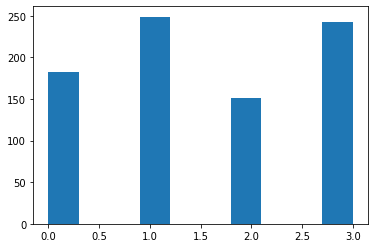

In [ ]:
import matplotlib.pyplot as plt
plt.hist(Labels)
# to_categorical(Labels)

In [ ]:
from scipy.ndimage import label
dnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = dnn.fit(Features, to_categorical(Labels), batch_size=10 ,epochs=10, validation_split=0.1, shuffle=True)

Epoch 1/10
75/75 [==============================] - 2s 12ms/step - loss: 1.3355 - accuracy: 0.3396 - val_loss: 2.1092 - val_accuracy: 0.0120
Epoch 2/10
75/75 [==============================] - 0s 4ms/step - loss: 1.3540 - accuracy: 0.3908 - val_loss: 1.6710 - val_accuracy: 0.1325
Epoch 3/10
75/75 [==============================] - 0s 4ms/step - loss: 1.3207 - accuracy: 0.3881 - val_loss: 1.7069 - val_accuracy: 0.0964
Epoch 4/10
75/75 [==============================] - 0s 4ms/step - loss: 1.2772 - accuracy: 0.4394 - val_loss: 1.8018 - val_accuracy: 0.1566
Epoch 5/10
75/75 [==============================] - 0s 4ms/step - loss: 1.2621 - accuracy: 0.4407 - val_loss: 1.9741 - val_accuracy: 0.2169
Epoch 6/10
75/75 [==============================] - 0s 4ms/step - loss: 1.2633 - accuracy: 0.4340 - val_loss: 2.0873 - val_accuracy: 0.0602
Epoch 7/10
75/75 [==============================] - 0s 4ms/step - loss: 1.2663 - accuracy: 0.4191 - val_loss: 1.7615 - val_accuracy: 0.0964
Epoch 8/10
75/75 [=

In [100]:
run=7

In [101]:
import warnings
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
warnings.filterwarnings("ignore")
class CNN:
    def __init__(self, epoch=20, batch_size=8, verbose=1, sr=22050):
        self.org_path = os.getcwd()
        self.set_epoch = epoch
        self.set_batch_size = batch_size
        self.set_verbose = verbose
        self.sr = sr

    def LoadData(self, DataPath):
        """Load data from the directory.

        Parameters
        ----------
        DataPath : string
            The path where you store the data. Note that the path must contain every split music data and
            MusicData.xlsx
        """
        os.chdir(DataPath)
        xlsx_module = xlrd.open_workbook('MusicData.xlsx')
        xlsx_sheet = xlsx_module.sheets()[0]
        data_info = []
        for i in range(1, xlsx_sheet.nrows):
            data_info.append(xlsx_sheet.row_values(i))
        music_data = []
        music_label = []
        data_len = []
        for i in range(len(data_info)):
            print("\rLoading data ({}/{})".format(i, len(data_info)), flush=True, end='')
            print(" : {}/{}".format(data_info[i][1], data_info[i][2] + data_info[i][5]), flush=True, end='')

            os.chdir(data_info[i][1])
            # raw_data, sr = librosa.load(data_info[i][2] + data_info[i][5], sr=22050, mono=True, offset=0.0, duration=4)
            raw_data, sr = librosa.load(data_info[i][2] + data_info[i][5], sr=self.sr, mono=True, offset=0.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            arousal_s = data_info[i][3] - 50
            valence_s = data_info[i][4] - 50
            if arousal_s >= 0 and valence_s >= 0:  # Joy
                music_label.append(0)
            elif arousal_s >= 0 and valence_s < 0:  # Tension
                music_label.append(1)
            elif arousal_s < 0 and valence_s >= 0:  # Peacefulness
                music_label.append(2)
            elif arousal_s < 0 and valence_s < 0:  # Sadness
                music_label.append(3)
            os.chdir('..')
        os.chdir(DataPath)
        for i, happy_file in enumerate(tqdm(happy_files)):
            # print(f'{i}/{len(happy_files)}')
            raw_data, sr = librosa.load(DataPath+'happy/'+happy_file, sr=self.sr, mono=True, offset=0.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(0)
            raw_data, sr = librosa.load(DataPath+'happy/'+happy_file, sr=self.sr, mono=True, offset=15.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(0)
            raw_data, sr = librosa.load(DataPath+'happy/'+happy_file, sr=self.sr, mono=True, offset=20.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(0)
        for i, angry_file in enumerate(tqdm(angry_files)):
            # print(f'{i}/{len(angry_files)}')
            raw_data, sr = librosa.load(DataPath+'angry/'+angry_file, sr=self.sr, mono=True, offset=0.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(1)
            raw_data, sr = librosa.load(DataPath+'angry/'+angry_file, sr=self.sr, mono=True, offset=15.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(1)
        for i, relax_file in enumerate(tqdm(relax_files)):
            # print(f'{i}/{len(relax_files)}')
            raw_data, sr = librosa.load(DataPath+'relax/'+relax_file, sr=self.sr, mono=True, offset=0.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(2)
            raw_data, sr = librosa.load(DataPath+'relax/'+relax_file, sr=self.sr, mono=True, offset=10.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(2)
            raw_data, sr = librosa.load(DataPath+'relax/'+relax_file, sr=self.sr, mono=True, offset=20.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(2)
        for i, sad_file in enumerate(tqdm(sad_files)):
            # print(f'{i}/{len(sad_files)}')
            raw_data, sr = librosa.load(DataPath+'sad/'+sad_file, sr=self.sr, mono=True, offset=0.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(3)
            raw_data, sr = librosa.load(DataPath+'sad/'+sad_file, sr=self.sr, mono=True, offset=15.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(3)
        for i, Q1_file in enumerate(tqdm(Q1_files)):
            raw_data, sr = librosa.load(DataPath+'Q1/'+Q1_file, sr=self.sr, mono=True, offset=0.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(0)
        for i, Q2_file in enumerate(tqdm(Q2_files)):
            raw_data, sr = librosa.load(DataPath+'Q2/'+Q2_file, sr=self.sr, mono=True, offset=0.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(1)
        for i, Q3_file in enumerate(tqdm(Q3_files)):
            raw_data, sr = librosa.load(DataPath+'Q3/'+Q3_file, sr=self.sr, mono=True, offset=0.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(3)
        for i, Q4_file in enumerate(tqdm(Q4_files)):
            raw_data, sr = librosa.load(DataPath+'Q4/'+Q4_file, sr=self.sr, mono=True, offset=0.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            music_label.append(2)
        music_label = np.array(music_label)
        data_len = np.array(data_len)

        plt.hist(music_label)
        plt.show()

        last_index = np.where(data_len == sr * 4)[0]
        new_music_data = []
        new_music_label = []
        for i in range(last_index.size):
            new_music_data.append(music_data[last_index[i]])
            new_music_label.append(music_label[i])
        new_music_data = np.array(new_music_data)
        new_music_label = np.array(new_music_label)

        new_music_data = np.reshape(new_music_data, [new_music_label.size, 1, self.sr*4, 1])
        train_index, test_index = self.split_data(new_music_label, train_size=0.7)
        train_data = new_music_data[train_index, :, :, :]
        train_label = to_categorical(new_music_label[train_index])
        test_data = new_music_data[test_index, :, :, :]
        test_label = to_categorical(new_music_label[test_index])

        return train_data, train_label, test_data, test_label

    def split_data(self, label, train_size=0.7):
        import random
        uni_label = np.unique(label)
        uni_label_num = [[] for i in range(uni_label.size)]
        train_index = np.array([], dtype='uint32')
        for i in range(uni_label.size):
            uni_label_num = list(np.where(label == uni_label[i])[0])
            train_index = np.hstack(
                [train_index, np.array(random.sample(uni_label_num, k=int(len(uni_label_num) * train_size)))])
        train_index = np.sort(train_index)
        test_index = np.setdiff1d(np.arange(label.size), train_index)

        return train_index, test_index

    def CreateModel(self, InputShape):
        """Create CNN model

        Parameters
        ----------
        InputShape :
            The shape of training data
        """
        sig_input = Input(shape=InputShape)
        x1_1=Conv2D(128,(1,256),kernel_initializer='random_uniform',padding='same',data_format='channels_last')(sig_input)
        x1_1=(Activation('relu'))(x1_1)
        x1_1=(BatchNormalization())(x1_1)
        x1_1=MaxPooling2D((1,80),strides=(1,40),data_format='channels_last')(x1_1)
        x1_2=Conv2D(128,(1,512),kernel_initializer='random_uniform',padding='same',data_format='channels_last')(x1_1)
        x1_2=(Activation('relu'))(x1_2)
        x1_2=(BatchNormalization())(x1_2)
        x1_o=add([x1_1,x1_2])
        x2=Conv2D(32,(1,1024),kernel_initializer='random_uniform',padding='same',data_format='channels_last')(x1_o)
        x2=(Activation('relu'))(x2)
        x2=(BatchNormalization())(x2)
        x2=MaxPooling2D((1,80),strides=(1,40),data_format='channels_last')(x2)
        y=(Flatten())(x2)
        y=(Dropout(0.4))(y)
        y=(Dense(units=64,activation='relu'))(y)
        y=(Dropout(0.4))(y)
        output=(Dense(units=4,activation='softmax'))(y)
        model = Model(sig_input, output)
        model.summary()
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model

    def Train(self, DataPath, train_data, train_label, test_data, test_label):
        """Train data with CNN model

        Parameters
        ----------
        DataPath : string
            The path where you store the data. Note that the path must contain every split music data and
            MusicData.xlsx
        """
        # train_data, train_label, test_data, test_label = self.LoadData(DataPath)
        model = self.CreateModel(train_data.shape[1:])
        checkpointer = ModelCheckpoint(filepath=f'{DataPath}cnn_model{run}.h5', verbose=1, save_best_only=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
        train_history = model.fit(x=train_data,
                                  y=train_label,
                                  validation_data=(test_data, test_label),
                                  epochs=self.set_epoch,
                                  batch_size=self.set_batch_size,
                                  verbose=self.set_verbose,
                                  callbacks=[checkpointer, reduce_lr],
                                  shuffle=True)
        # os.chdir(self.org_path)
        os.chdir(DataPath)
        # model.save('music_cnn.model')

        # %% Model accuracy
        y1 = train_history.history['accuracy']
        y2 = train_history.history['val_accuracy']
        x = np.arange(len(y1)) + 1
        plt.plot(x, y1, color='blue', label='Train')
        plt.plot(x, y2, color='red', label='Validation')
        plt.title("accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend(loc='upper left', shadow=True)
        plt.savefig(f'accuracy{run}', dpi=1500)
        plt.show()

        # %% Model loss value
        y1 = train_history.history['loss']


        y2 = train_history.history['val_loss']
        x = np.arange(len(y1)) + 1
        plt.plot(x, y1, color='blue', label='Train')
        plt.plot(x, y2, color='red', label='Validation')
        plt.title("loss")
        plt.xlabel("Epoch")
        plt.ylabel("loss")
        plt.legend(loc='upper right', shadow=True)
        plt.savefig(f'loss{run}', dpi=1500)
        plt.show()

    def Predict(self, ModelPath, InputData):
        """Predict the input with the given model

        Parameters
        ----------
        ModelPath : string
            The path where you store the model.
        InputData : string
            The path of input data, predict one data at one time.
        """
        raw_data, sr = librosa.load(InputData, sr=self.sr, mono=True, offset=0.0, duration=4)
        model = load_model(ModelPath)
        music_data = np.reshape(raw_data, [1, 1, self.sr*4, 1])
        score = model.predict(music_data)
        pre_label = np.argmax(score)

        return pre_label

In [ ]:
model = CNN()
train_data, train_label, test_data, test_label = model.LoadData(DataPath)
# result = model.Predict('/content/Music-emotion/music-emotion/music_cnn_model', DataPath+"Four Seasons_Summer 3rd movment/split_002.wav")
# print(result)

Loading data (449/450) : Autumn Island/split_007.wav

 53%|█████▎    | 53/100 [00:57<00:48,  1.03s/it]

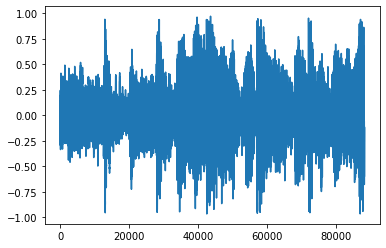

In [95]:
plt.plot(range(88200),train_data[800][0])

In [94]:
np.argmax(test_label, axis=1)

array([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 1, 0, 3, 0, 0, 0, 1, 0, 0, 1,
       0, 3, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 3, 3, 1, 3,
       3, 1, 3, 3, 1, 2, 3, 2, 2, 1, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 3, 2,
       3, 3, 3, 0, 2, 2, 0, 1, 2, 2, 0, 0, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 0, 2, 0, 3, 0, 3, 2, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1, 88200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 1, 88200, 12  32896       ['input_6[0][0]']                
                                8)                                                                
                                                                                                  
 activation_15 (Activation)     (None, 1, 88200, 12  0           ['conv2d_15[0][0]']              
                                8)                                                          

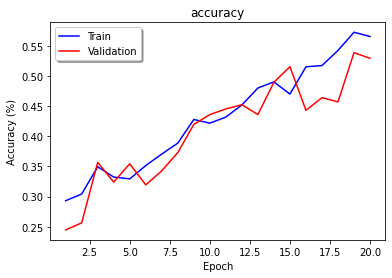

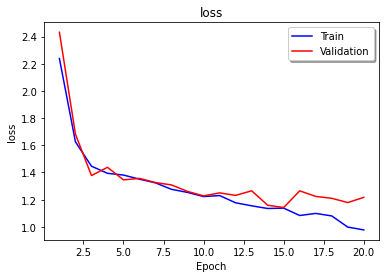

In [96]:
model = CNN()
model.Train(DataPath, train_data, train_label, test_data, test_label)

In [ ]:
result = model.Predict('/content/Music-emotion/music-emotion/music_cnn.model',DataPath+"/Four Seasons_Summer 3rd movment/split_002.wav")
print(result)

1/1 [==============================] - 0s 95ms/step
3


In [ ]:
!zip -r /content/mymodel.zip /content/Music-emotion/music-emotion/music_cnn.model

  adding: content/Music-emotion/music-emotion/music_cnn.model/ (stored 0%)
  adding: content/Music-emotion/music-emotion/music_cnn.model/saved_model.pb (deflated 89%)
  adding: content/Music-emotion/music-emotion/music_cnn.model/variables/ (stored 0%)
  adding: content/Music-emotion/music-emotion/music_cnn.model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/Music-emotion/music-emotion/music_cnn.model/variables/variables.index (deflated 70%)
  adding: content/Music-emotion/music-emotion/music_cnn.model/assets/ (stored 0%)
  adding: content/Music-emotion/music-emotion/music_cnn.model/keras_metadata.pb (deflated 92%)


In [ ]:
from google.colab import files
files.download("/content/mymodel.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>